In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *


import scoping.utils.learning_utils as lu
import random
import scipy.stats as st


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)


now=datetime.datetime.today()

random.seed(2022)

## First we say what query and project we are interested in

This is using the NACSOS platform

In [3]:
pid = 276 #project
p = Project.objects.get(pk=pid)

#qid = 8318
#qids = [9626, 9630, 9631] #the merged query below already includes filter on article and review so use that instead
qids = [9626, 9635] #A few ratings were done on 9626 before we filtered for articles and reviews
merged_query = Query.objects.get(pk=9635)
docids = set(Doc.objects.filter(query__in=qids).values_list('id',flat=True))
docs = Doc.objects.filter(id__in=docids)


#print(q.doc_set.count())
docs.count()

53867

### And we retrieve those documents that have been screened in that query, and get the majority rating

In [4]:
# First get only the ratings from updated tags  (e.g. after double coding disagreement)

import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'PY',
    'wosarticle__de',
    'wosarticle__wc'
]

# Add rated "maybe" docs & re-assesments here
update_tags = Tag.objects.filter(pk__in=[7654, 7655, 7369, 7375, 7376, 7400, 7491, 7490]) 
updated_dos = DocOwnership.objects.filter(
    tag__in=update_tags, 
    relevant__gt=0, #Only the ones in these that have been rated
     doc__content__iregex='\w'
)

dodf = pd.DataFrame.from_dict(updated_dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0 #rated irrelevant (keeping rated 1, relevant)
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN #mixed rating

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

updated_df = gdf

ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=updated_df['id']).values(*columns)
)
updated_df = pd.merge(ddf,updated_df)

updated_df.shape

(173, 8)

In [5]:
# Now get majority ratings from the rest of documents
# Majority ratings
dos = DocOwnership.objects.filter(
    query__in=qids, 
    relevant__gt=0,
    doc__content__iregex='\w',
).exclude(doc__id__in=updated_df["id"]) #exclude the updated ones you got above
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0 #rated irrelevant
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN #mixed rating

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

seen_df = gdf
ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)

seen_df = pd.concat([seen_df,updated_df]) #merge the udpated ones back in
print(seen_df.shape)
seen_df.head()

(2643, 8)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen
0,4869662,Facing climate risks has become a common probl...,Assessment of the Construction of a Climate Re...,2021.0,climate resilient cities; multi-level grey sys...,"[Environmental Sciences; Public, Environmental...",1.0,1.0
1,4848984,The California state government put restrictio...,Outdoor Residential Water Use Restrictions dur...,2021.0,None,"[Engineering, Environmental; Environmental Sci...",1.0,1.0
2,863784,Because phytoplankton communities exhibit seas...,Plasticity in phytoplankton annual periodicity...,2018.0,Biodiversity; Phenology; Re-oligotrophication;...,None,0.0,1.0
3,527034,Since the inception of the United Nations Fram...,One scheme to bind them all? Should emissions ...,2014.0,None,None,0.0,1.0
4,853293,Although households in the coastal areas of Ba...,"Cyclone, salinity intrusion and adaptation and...",2017.0,None,None,0.0,1.0


In [6]:
#For the nested cross-validation, we also need to know which document ratings come from random samples

# Insert the random queries here
rand_tags = Tag.objects.filter(pk__in= [6765,6754, 6764, 6769, 6770, 6776, 6777, 6783, 6784, 6788, 7370])
                               #[6764, 6769, 6770, 6776, 6777, 6783, 6784, 6788, 7370])
rand_dos = DocOwnership.objects.filter(
    tag__in=rand_tags, 
    relevant__gt=0, #Only the ones in these that have been rated
)

randdf = pd.DataFrame.from_dict(rand_dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))

print(f"Number of documents from random sample: {randdf.drop_duplicates(subset='doc_id').shape[0]}")

seen_df['random'] = 0
seen_df.loc[seen_df['id'].isin(randdf['doc_id']), 'random'] = 1

print(f"Of which rated relevant: {seen_df[(seen_df['random'] == 1) & (seen_df['relevant'] ==1)].shape[0]}")

seen_df.head()

Number of documents from random sample: 1166
Of which rated relevant: 145


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random
0,4869662,Facing climate risks has become a common probl...,Assessment of the Construction of a Climate Re...,2021.0,climate resilient cities; multi-level grey sys...,"[Environmental Sciences; Public, Environmental...",1.0,1.0,1
1,4848984,The California state government put restrictio...,Outdoor Residential Water Use Restrictions dur...,2021.0,None,"[Engineering, Environmental; Environmental Sci...",1.0,1.0,1
2,863784,Because phytoplankton communities exhibit seas...,Plasticity in phytoplankton annual periodicity...,2018.0,Biodiversity; Phenology; Re-oligotrophication;...,None,0.0,1.0,0
3,527034,Since the inception of the United Nations Fram...,One scheme to bind them all? Should emissions ...,2014.0,None,None,0.0,1.0,0
4,853293,Although households in the coastal areas of Ba...,"Cyclone, salinity intrusion and adaptation and...",2017.0,None,None,0.0,1.0,0


In [7]:
#ADDED FOR TEST: REDUCE DF SIZE 
testing=False
if testing:
    seen_df = seen_df.head(100)
    print(seen_df.shape)

### We have a separate list of documents in the query that have not been screened

In [7]:
t0 = time.time()
#docs = Doc.objects.filter(pk__lt=1000,query=merged_query)
docs = Doc.objects.filter(id__in=docids,
                          content__iregex='\w',
                          wosarticle__dt__iregex='article|review')
unseen_docs = docs.exclude(
    id__in=seen_df['id'],
)

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = np.NaN
unseen_df['seen'] = 0
unseen_df['random'] = np.NaN

print(unseen_df.shape)
print(f"time: {time.time()-t0}")
unseen_df.head()

(47819, 9)
time: 29.882988452911377


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random
0,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,2002.0,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,NaN,0,NaN
1,108,We provide a synthesis of what regional scient...,The Contributions of Regional Knowledge Networ...,2013.0,Africa; capacity building; global change; Lati...,[Ecology; Environmental Studies],NaN,0,NaN
2,157,The 'modernist' project that has come to domin...,Addressing the dynamics of agri-food systems: ...,2009.0,Agriculture; Agroecology; Agri-food system; Su...,[Environmental Sciences],NaN,0,NaN
3,195,"Within modern society, business organizations ...",Linking corporate climate adaptation strategie...,2011.0,Climate change; Food industry; Adaptation/miti...,[Green & Sustainable Science & Technology; Eng...,NaN,0,NaN
4,222,Human thermal comfort in urban outdoor places ...,Research and design for thermal comfort in Dut...,2012.0,Urban microclimate; Thermal comfort; Perceptio...,"[Engineering, Environmental; Environmental Sci...",NaN,0,NaN


In [244]:
#ADDED FOR TEST
if testing:
    unseen_df = unseen_df.head(100)
    print(unseen_df.shape)

### And we merge the two, with a column "seen" recording if a document has been seen or not

In [8]:
django.db.connection.close()

df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

#Save the below
y = df['relevant']
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head(10)

(50462, 9)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random
0,3792331,To construct a long-term energy plan for renew...,Climate change impacts on potential solar ener...,2020.0,Climate change; Impact assessment; Climate sce...,[Green & Sustainable Science & Technology; Ene...,NaN,0.0,NaN
1,280215,This paper outlines a process for exploring fo...,Modelling food system resilience: a scenario-b...,2015.0,None,None,NaN,0.0,NaN
2,1288320,Understanding the extent to which agriculture ...,The potential benefits of agricultural adaptat...,2018.0,Climate change; adaptation capacity; agricultu...,[Economics; Environmental Studies],NaN,0.0,NaN
3,129554,This study investigates future impacts of glob...,Potential influences of global warming on futu...,2013.0,Global warming; Nigeria; Ecological zone; Clim...,[Environmental Sciences; Environmental Studies],NaN,0.0,NaN
4,345398,"Zebra mussels (Dreissena polymorpha, Pallas, 1...",Effects of increasing temperatures on populati...,2007.0,global change; thermal tolerance; life history...,[Ecology],NaN,0.0,NaN
5,2276652,Urban energy transitions are key components of...,Smart gridlock? Challenging hegemonic framings...,2019.0,smart grids; living labs; scaling up; particip...,[Environmental Sciences; Meteorology & Atmosph...,NaN,0.0,NaN
6,695279,Ectotherms constitute the vast majority of ter...,Heritability of hsp70 expression in the beetle...,2014.0,Animal model; Tenebrio molitor; Thermal adapta...,[Entomology; Physiology; Zoology],NaN,0.0,NaN
7,425207,This paper addresses the importance of the cog...,Urban low-carbon transitions: cognitive barrie...,2015.0,Sustainable urban transformation; Cognitive di...,[Green & Sustainable Science & Technology; Eng...,NaN,0.0,NaN
8,3285233,"In recent years, the building sector has recei...",Assessing the impact of climate change on buil...,2020.0,Climate change; Building performance simulatio...,[Green & Sustainable Science & Technology; Ene...,NaN,0.0,NaN
9,501275,Climate change poses many challenges for the f...,How past sea-level changes can inform future p...,2014.0,coastal planning; future modelling; past coast...,"[Geography, Physical; Geosciences, Multidiscip...",NaN,0.0,NaN


In [9]:
df[df['seen'] ==1].shape

(2495, 9)

### We also get the assignments of these documents to categories, and add these as further columns in our dataframe
again we get the majority ratings

In [10]:
# first get only those ratings from the updated tags
dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=updated_df['id'],category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
updated_docusers = updated_dos.values_list('doc__id',"user__username")
dudf = dudf[dudf[['doc__id', 'user__username']].apply(tuple, axis=1).isin(updated_docusers)]
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
updated_gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()


dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=set(seen_df['id']) - set(updated_df['id']),category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()

#merge updated and old
gudf = pd.concat([gudf,updated_gudf])

print(gudf.shape)
gudf.head()

(816, 88)


,doc__id,10 - Other,10 - Resources,10 - biological<hidden>,10 - economic<hidden>,10 - financial<hidden>,"10 - governance, institutions or policy",10 - human capacity<hidden>,"10 - information, awareness or technology<hidden>",10 - physical<hidden>,...,"8 - Rivers, lakes and floods<hidden>",8 - Storms & hurricanes<hidden>,8 - Terrestrial ecosystems<hidden>,8 - Terrestrial natural systems,8 - Wildfire<hidden>,9 - Ex-ante,9 - Ex-post,6 - 1.10. Demonstration projects<hidden>,6 - 2.07. Binding requirements<hidden>,6 - 4.05. Expert advisory processes and performance reviews<hidden>
0,880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
1,11595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN
2,12792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
3,14276,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
4,18576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN


In [11]:
#Let's get rid of the <hidden> in the names
for col in gudf.columns:
    gudf.rename(columns={col:col.split("<")[0]},inplace=True)
    
#And check how many postive ratings we actually have (for now, including irrelevant docs)
for c in gudf.columns: 
    print(f"{int(gudf[c].sum()):03d} documents in class '{c}'")

1428567467 documents in class 'doc__id'
031 documents in class '10 - Other'
062 documents in class '10 - Resources'
005 documents in class '10 - biological'
017 documents in class '10 - economic'
021 documents in class '10 - financial'
193 documents in class '10 - governance, institutions or policy'
017 documents in class '10 - human capacity'
055 documents in class '10 - information, awareness or technology'
003 documents in class '10 - physical'
028 documents in class '10 - social or cultural'
574 documents in class '11 - countries'
618 documents in class '2 - Adaptation'
125 documents in class '2 - Mitigation'
149 documents in class '2 - Other'
450 documents in class '3 - No maladaptation or no evidence'
055 documents in class '3 - Yes - maladaptation'
133 documents in class '4 - 1. Nodality'
172 documents in class '4 - 3. Treasure'
260 documents in class '4 - 4. Authority'
130 documents in class '4 - 4. Organisation'
038 documents in class '5 - 1.01. Knowledge generation'
040 docum

In [12]:
#For many of these, in the end, we do not have enough to do predictions on, so let's merge
gudf.loc[(gudf["2 - Other"] == 1) | (gudf["2 - Mitigation"] == 1), "2 - Primarily not adaptation"] = 1

#For impact type, we simplified the coding scheme; merge to those simplified categories
impactMerge = {'8 - Coastal': ['8 - Coastal and marine','8 - Coastal erosion and/or sea level effects', '8 - Marine ecosystems', '8 - Storms & hurricanes'],
              '8 - Rivers': ['8 - Freshwater: rivers, lakes & soil moisture','8 - Rivers, lakes and floods',  '8 - Drought'], 
              '8 - Terrestrial': ['8 - Terrestrial natural systems','8 - Extreme heat', '8 - Glaciers, snow, ice and permafrost', '8 - Terrestrial ecosystems', '8 - Wildfire'], 
              '8 - Human': ['8 - Human and managed systems','8 - Food production', '8 - Livelihoods, health or economics',]
             }

for col in impactMerge:
    gudf[col] = np.nan
    for cat in impactMerge[col]:
        gudf.loc[gudf[cat] == 1 , col] = 1
        
#Same for barriers
barriersMerge = {'10 - Governance': ['10 - governance, institutions or policy',],
              '10 - Resources': ['10 - Resources', '10 - economic', '10 - financial', '10 - human capacity', '10 - information, awareness or technology'], 
              '10 - Other': ['10 - Other','10 - biological','10 - physical', '10 - social or cultural'], 
             }
 
for col in barriersMerge:
    gudf[col] = np.nan
    for cat in barriersMerge[col]:
        gudf.loc[gudf[cat] == 1 , col] = 1

#Only keep the columns we want (in order)
cols = ['doc__id',
        '2 - Adaptation', '2 - Mitigation', '2 - Other', "2 - Primarily not adaptation", #Retain both all classes and merged
        '3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
        '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation', #Top level NATO only for now
        '7 - International', '7 - National', '7 - Subnational ', #Governance level
        '8 - Coastal', '8 - Rivers', '8 - Terrestrial', '8 - Human', #Only retain impacts categories
        '9 - Ex-ante', '9 - Ex-post', #Study type
        '10 - Governance', '10 - Resources', '10 - Other' #Only retain merged for barriers
       ]

gudf = gudf[cols]

for c in gudf.columns: 
    print(f"{int(gudf[c].sum()):03d} documents in class '{c}'")

1428567467 documents in class 'doc__id'
618 documents in class '2 - Adaptation'
125 documents in class '2 - Mitigation'
149 documents in class '2 - Other'
271 documents in class '2 - Primarily not adaptation'
450 documents in class '3 - No maladaptation or no evidence'
055 documents in class '3 - Yes - maladaptation'
133 documents in class '4 - 1. Nodality'
172 documents in class '4 - 3. Treasure'
260 documents in class '4 - 4. Authority'
130 documents in class '4 - 4. Organisation'
163 documents in class '7 - International'
313 documents in class '7 - National'
348 documents in class '7 - Subnational '
114 documents in class '8 - Coastal'
160 documents in class '8 - Rivers'
097 documents in class '8 - Terrestrial'
161 documents in class '8 - Human'
142 documents in class '9 - Ex-ante'
589 documents in class '9 - Ex-post'
193 documents in class '10 - Governance'
090 documents in class '10 - Resources'
035 documents in class '10 - Other'


In [23]:
gudf.columns

Index(['doc__id', '2 - Adaptation', '2 - Mitigation', '2 - Other',
       '2 - Primarily not adaptation', '3 - No maladaptation or no evidence',
       '3 - Yes - maladaptation', '4 - 1. Nodality', '4 - 3. Treasure',
       '4 - 4. Authority', '4 - 4. Organisation', '7 - International',
       '7 - National', '7 - Subnational ', '8 - Coastal', '8 - Rivers',
       '8 - Terrestrial', '8 - Human', '9 - Ex-ante', '9 - Ex-post',
       '10 - Governance', '10 - Resources', '10 - Other'],
      dtype='object')

## And merge

In [13]:
df = pd.merge(df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)
print(df.shape)
df.head()

(50462, 31)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random,2 - Adaptation,...,7 - Subnational,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,9 - Ex-ante,9 - Ex-post,10 - Governance,10 - Resources,10 - Other
0,3792331,To construct a long-term energy plan for renew...,Climate change impacts on potential solar ener...,2020.0,Climate change; Impact assessment; Climate sce...,[Green & Sustainable Science & Technology; Ene...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,280262,Mid-season drainage (MSD) decreases methane em...,Interannual variations in methane emission fro...,2016.0,Methane; Rice paddy; Mid-season drainage; Eddy...,"[Agriculture, Multidisciplinary; Ecology; Envi...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1288320,Understanding the extent to which agriculture ...,The potential benefits of agricultural adaptat...,2018.0,Climate change; adaptation capacity; agricultu...,[Economics; Environmental Studies],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,129554,This study investigates future impacts of glob...,Potential influences of global warming on futu...,2013.0,Global warming; Nigeria; Ecological zone; Clim...,[Environmental Sciences; Environmental Studies],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,345398,"Zebra mussels (Dreissena polymorpha, Pallas, 1...",Effects of increasing temperatures on populati...,2007.0,global change; thermal tolerance; life history...,[Ecology],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df.columns

Index(['id', 'content', 'title', 'PY', 'wosarticle__de', 'wosarticle__wc',
       'relevant', 'seen', 'random', '2 - Adaptation', '2 - Mitigation',
       '2 - Other', '2 - Primarily not adaptation',
       '3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
       '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority',
       '4 - 4. Organisation', '7 - International', '7 - National',
       '7 - Subnational ', '8 - Coastal', '8 - Rivers', '8 - Terrestrial',
       '8 - Human', '9 - Ex-ante', '9 - Ex-post', '10 - Governance',
       '10 - Resources', '10 - Other'],
      dtype='object')

### Finally, we have a set of documents from other projects
These will NOT count towards the relevant classifier, but will be used to see if we can boost performance for the categories. We simply add all for now and will select an appropriately sized subset later.

Note that these are taken from the same platform, so document IDs match.

In [14]:
#From impacts paper: similar impacts categories used
idf = pd.read_csv("data/MaxImpacts_labelled_documents.csv")
idf.drop_duplicates(subset = 'id', keep = False, inplace=True) #There shouldn't be any, but there are... dropping all to be sure
[print(c) for c in idf.columns]
idf.shape

id
content
title
wosarticle__de
wosarticle__wc
ar5
seen
relevant
random_sample
representative_relevant_sample
physical_tags
12 - Coastal and marine Ecosystems
12 - Human and managed
12 - Mountains, snow and ice
12 - Rivers, lakes, and soil moisture
12 - Terrestrial ES
10 - places
11 - Africa
11 - Asia
11 - Australasia
11 - Central & South America
11 - Europe
11 - Global
11 - North America
11 - Open ocean
11 - Polar Regions
11 - Small Islands
13 - Coastal erosion and/or sea level effects
13 - Food production
13 - Glaciers, snow, ice and/or permafrost
13 - Livelihoods, health and/or economics
13 - Marine ecosystems
13 - Rivers, lakes, floods and/or drought
13 - Terrestrial ecosystems
13 - Wildfire
14 - Coastal human systems
14 - Cryosphere
14 - Droughts
14 - Marine (eco-)systems
14 - River floods
14 - Terrestrial (eco-)systems
15 - 01. Extreme water levels
15 - 02. Sea ice retreat
15 - 03. Glacier retreat
15 - 04. Changes in strong precipitation
15 - 05. Shifts in phenology (ocean)
15 - 

(2629, 246)

In [15]:
idf['8 - Coastal'] = np.nan
idf.loc[idf['12 - Coastal and marine Ecosystems'] == 1, '8 - Coastal'] = 1
idf['8 - Human'] = np.nan
idf.loc[idf['12 - Human and managed'] == 1, '8 - Human'] = 1
idf['8 - Rivers'] = np.nan
idf.loc[(idf['12 - Mountains, snow and ice'] == 1) | (idf['12 - Rivers, lakes, and soil moisture'] ==1), '8 - Rivers'] = 1
idf['8 - Terrestrial'] = np.nan
idf.loc[idf['12 - Terrestrial ES'] ==1, '8 - Terrestrial'] =1


idf_add = idf[idf[['8 - Coastal', '8 - Rivers', '8 - Terrestrial', '8 - Human']].any(axis=1)]
idf_add = idf_add[['id', 'content', 'title', 'relevant', '8 - Coastal', '8 - Rivers', '8 - Terrestrial', '8 - Human']]
idf_add['random'] = -1
idf_add['relevant'] = -1
idf_add.head()

,id,content,title,relevant,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,random
15,11461,Disasters are most acutely experienced at the ...,Managing the risks from climate extremes at th...,-1,NaN,1.0,NaN,NaN,-1
32,96849,"In this study, change in rainfall, temperature...",Recent climatic trends and linkages to river d...,-1,NaN,1.0,NaN,NaN,-1
39,1306727,Climate change is predicted to alter the geogr...,Changes in the Geographic Distribution of the ...,-1,NaN,NaN,1.0,NaN,-1
51,105783,1. Lake Victoria endured multiple stresses ove...,Multiple stressors cause rapid ecosystem chang...,-1,NaN,NaN,NaN,1.0,-1
55,556134,We examined the long-term variability in the a...,"Response of yellowtail, Seriola quinqueradiata...",-1,1.0,NaN,NaN,NaN,-1


In [16]:
#Forthcoming mitigation policy paper uses policy categories that are broadly similar
mdf = pd.read_csv("data/MaxMitigatonPolicy_labelled_documents.csv")
mdf.drop_duplicates(subset = 'id', keep = False,  inplace=True) #There shouldn't be any, but there are... dropping all to be sure
[print(c) for c in mdf.columns]
mdf.shape

id
title
content
0 - relevant
10 - 3. Quantitative
10 - 4. Qualitative
2 - 0. Mitigation
2 - 1. Adaptation
3 - 0. Not policy related
3 - 1. Analysis of an existing policy / concrete proposal
3 - 2. Analysis of a generic policy
3 - 3. Broader governance and policy
4 - 1. Economic instruments
4 - 2. Regulatory Instruments
4 - 3. Information, education and training
4 - 4. Governance, strategies and targets
4 - 5. Agreements
5 - 1.02. Carbon pricing
5 - 1.02. Subsidies
5 - 1.03. Non-carbon taxes
5 - 1.04. Direct Investment / spending
5 - 2.05. Trade policy
5 - 2.06. Quotas
5 - 2.07. Regulation on transactions
5 - 2.08. Information requirements
5 - 2.09. Spatial and land-use planning
5 - 2.10. Other regulation
5 - 2.11. Standards
5 - 3.12. Public Information/awareness campaigns
5 - 3.13. Behavioural interventions
5 - 3.14. Education and training
5 - 3.15. Standardized labels, reporting and accounting standards and certification schemes
5 - 3.16. Publication of data / analysis
5 - 4.17. Plan

(2580, 103)

In [17]:
mdf['2 - Mitigation'] = np.nan
mdf['2 - Primarily not adaptation'] = np.nan
mdf.loc[mdf['2 - 0. Mitigation'] == 1, '2 - Mitigation'] = 1
mdf.loc[mdf['2 - 0. Mitigation'] == 1, '2 - Primarily not adaptation'] = 1
    
#NATO
mdf['4 - 3. Treasure'] = np.nan
mdf.loc[mdf['4 - 1. Economic instruments'] == 1, '4 - 3. Treasure'] = 1
mdf['4 - 4. Authority'] = np.nan
mdf.loc[(mdf['4 - 2. Regulatory Instruments'] == 1) | 
        (mdf['4 - 5. Agreements'] == 1) | 
        (mdf['5 - 4.17. Planning'] == 1), '4 - 4. Authority'] = 1
mdf['4 - 1. Nodality'] = np.nan
mdf.loc[mdf['4 - 3. Information, education and training'] ==1, '4 - 1. Nodality'] =1
mdf['4 - 4. Organisation'] = np.nan
mdf.loc[(mdf['5 - 4.18. Government administration & management'] ==1) | (mdf['5 - 4.19. Institutions'] ==1), '4 - 4. Organisation'] =1

#Level
mdf['7 - International'] = np.nan
mdf.loc[mdf['7 - 0. Supranational and international'] ==1, '7 - International'] =1
mdf['7 - National'] = np.nan
mdf.loc[mdf['7 - 1. National'] ==1, '7 - National'] =1
mdf['7 - Subnational '] = np.nan
mdf.loc[(mdf['7 - 2. Sub-national / regional'] ==1) | (mdf['7 - 3. Local'] ==1), '7 - Subnational '] =1

#Ex-post/-ante
mdf['9 - Ex-post'] = np.nan
mdf.loc[mdf['9 - 0. Ex-post'] ==1, '9 - Ex-post'] =1
mdf['9 - Ex-ante'] = np.nan
mdf.loc[(mdf['9 - 2. Ex-ante (IAM)'] ==1) |(mdf['9 - 1. Ex-ante'] ==1), '9 - Ex-ante'] =1

mcols = ['2 - Mitigation', 
         '4 - 3. Treasure', '4 - 4. Authority', '4 - 1. Nodality', '4 - 4. Organisation',
         '7 - International', '7 - National', '7 - Subnational ',
         '9 - Ex-post', '9 - Ex-ante'
        ]    
    
mdf_add = mdf[mdf[mcols].any(axis=1)]
mdf_add = mdf_add[['id', 'content', 'title'] + mcols]

mdf_add['random'] = -1
mdf_add['relevant'] = -1
mdf_add.head()

,id,content,title,2 - Mitigation,4 - 3. Treasure,4 - 4. Authority,4 - 1. Nodality,4 - 4. Organisation,7 - International,7 - National,7 - Subnational,9 - Ex-post,9 - Ex-ante,random,relevant
0,156,Magma power is the production of electricity f...,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1
1,337,A study conducted by the Prognos economic rese...,Energy forecast till 2020 for the German Gover...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1
4,3556,We calculate carbon dioxide (CO2) emissions em...,Will economic restructuring in China reduce tr...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1,-1
7,4793,The European Union's Emissions Trading Scheme ...,An emerging equilibrium in the EU emissions tr...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,-1,-1
9,5220,In this paper it is argued that climate change...,Dual climate change responsibility: on moral d...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1


In [18]:
#First merge the two new dfs, combining if needed
print(mdf_add.shape, idf_add.shape)
imdf = pd.merge(mdf_add, idf_add, on=['id','content', 'title', 'relevant', 'random'], how='outer')
print(imdf.shape)
#Then insert all
df = pd.concat([df, imdf], ignore_index = True).fillna(0).drop_duplicates(subset='id', keep='first').reset_index(drop=True)
print(df.shape)
print(df.columns)
df.tail()

(1887, 15) (418, 9)
(2305, 19)
(52591, 31)
Index(['id', 'content', 'title', 'PY', 'wosarticle__de', 'wosarticle__wc',
       'relevant', 'seen', 'random', '2 - Adaptation', '2 - Mitigation',
       '2 - Other', '2 - Primarily not adaptation',
       '3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
       '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority',
       '4 - 4. Organisation', '7 - International', '7 - National',
       '7 - Subnational ', '8 - Coastal', '8 - Rivers', '8 - Terrestrial',
       '8 - Human', '9 - Ex-ante', '9 - Ex-post', '10 - Governance',
       '10 - Resources', '10 - Other'],
      dtype='object')


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random,2 - Adaptation,...,7 - Subnational,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,9 - Ex-ante,9 - Ex-post,10 - Governance,10 - Resources,10 - Other
52586,92387,"Since 2000, a disease displaying white-syndrom...",Australian subtropical white syndrome: a trans...,0.0,0,0,-1.0,0.0,-1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52587,540038,Cold related mortality among people aged over ...,Causes for the recent changes in cold- and hea...,0.0,0,0,-1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
52588,122016,The Hawaiian honeycreepers (Drepanidae) repres...,Interactions of climate change with biological...,0.0,0,0,-1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
52589,723776,Vector-borne diseases are among those most sen...,Modelling the effects of past and future clima...,0.0,0,0,-1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
52590,744179,Widespread reports of disappearing tree specie...,Tree mortality in the African Sahel indicates ...,0.0,0,0,-1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
remerge = True
if remerge:
    dfOld = pd.read_csv("predictions/ForBERT_2022-05-24 14:41:09.075032.csv")
    df1 = pd.merge(df, dfOld[['id', '0 - relevance - prediction', 'y_k_prediction_SVM-rbf']], left_on = 'id', right_on = 'id')
    
    cols = ['id', 'content', 'title', 'relevant', 'seen', 'random',
            '2 - Adaptation', '2 - Mitigation', '2 - Other', #Adaptation vs mitigation
            #'3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
            '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation', #Top level NATO only for now
            '7 - International', '7 - National', '7 - Subnational ', #Governance level
            '8 - Coastal', '8 - Rivers', '8 - Terrestrial', '8 - Human',
            '9 - Ex-ante', '9 - Ex-post', #Study type
            'y_k_prediction_SVM-rbf', '0 - relevance - prediction' #For comparisson
    ]

    bertdf = df1[cols].fillna(value=0)
    bertdf.loc[bertdf['seen'] ==0, 'relevant'] = None
    for c in cols:
        bertdf.loc[bertdf[c] ==0, c] = None
    print(bertdf.columns)
    bertdf.to_csv(f'predictions/ForBERT_{now}.csv', index=False, encoding='utf-8')
    bertdf.head()

Index(['id', 'content', 'title', 'relevant', 'seen', 'random',
       '2 - Adaptation', '2 - Mitigation', '2 - Other', '4 - 1. Nodality',
       '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation',
       '7 - International', '7 - National', '7 - Subnational ', '8 - Coastal',
       '8 - Rivers', '8 - Terrestrial', '8 - Human', '9 - Ex-ante',
       '9 - Ex-post', 'y_k_prediction_SVM-rbf', '0 - relevance - prediction'],
      dtype='object')


In [29]:
 bertdf

(0, 24)

In [28]:
df[(bertdf['8 - Coastal'] ==1) & (df['random'] ==1)].shape

(21, 31)

### We have a look at the distribution of relevant and not relevant documents


Text(0, 0.5, 'Number of documents')

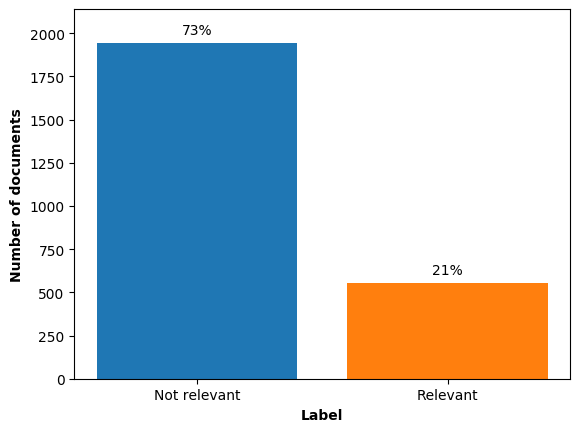

In [166]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_xticklabels(["Not relevant", "Relevant"])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Label', weight="bold")
ax.set_ylabel('Number of documents', weight="bold")

### Now we "vectorize" the data, representing each document as a weighted count of its words and phrases (bag of words and bigrams). Or if we already did this previously, then we reload the vectorized data

In [263]:
import pickle
import scipy
revectorize = True


y = df['relevant']
#x is the vectors (ab_X given below)

t0 = time.time()
if revectorize:
    vec = TfidfVectorizer( #NB: default to normalize using Euclidian distance (norm='l2')
        ngram_range=(1,2), #unigrams and bigrams
        min_df=10, max_df=0.95, #Occurring in at least 10 docs and in no more than 95% of docs
        strip_accents='unicode', 
        max_features=10000, #Only look at 10k most common words if there are more
        use_idf=1,
        smooth_idf=1, sublinear_tf=1, #Sublinear helps deal with different text lengths
        stop_words="english",tokenizer=lu.tokenize #Take out English stopwords
    )
    vec.fit(df.loc[seen_index,'content'].astype(str))
    ab_X = vec.transform(df['content'].astype(str))
    if testing == True:
        with open ('data/TESTING_vec.pickle','wb') as f:
            pickle.dump(vec, f)
    else:
        with open ('data/vec.pickle','wb') as f: 
            pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('X.npz', ab_X)
    print(f"Vectorizing done - time: {(time.time()-t0)//3600} hours and {(time.time()-t0)//60} mins")
else:
    with open ('data/vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('X.npz')
    print("Vectors loaded from file")
    
    
print(ab_X.shape)

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Vectorizing done - time: 1.0 hours and 11.0 mins
(52590, 4586)


We can do an alternative way of vectorizing too using doc2vec, which may work better with SVM

Loosly following: https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint.ipynb

Note that this takes even longer, especially for larger vector sizes (normal values 100-300)

In [60]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_string as preprocess
print(f"Using gensim version {gensim.__version__}")

revectorize = True
#testing=False

vector_size = 300
if testing: epochs = 3 
else: epochs = 10


y = df['relevant']

t0 = time.time()
if revectorize:
    #A gensim corpus for Doc2Vec requires both text and a tag
    corpus = [TaggedDocument(
                    words=preprocess(str(r['title']) + " " + str(r['content'])), #Title + abstract
                    tags=[r['id']]) #Here, we just use the ID as tag
              for i, r in df.iterrows()]


    model_d2v = Doc2Vec(vector_size=vector_size,  workers = 6, epochs=epochs, #workers sets threads normally, but not working in jupyter hub
                    min_count=10, max_vocab_size = 10000,
                    seed=42) 
    model_d2v.build_vocab(corpus)
    model_d2v.train(corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
    
    model_d2v.save(r"data/model_d2v") #Also saves the vectors automatically
    
    print(f"Model done - time: {(time.time()-t0)//360} hours and {(time.time()-t0)//60} mins")
    
    #Normalize
    model_d2v.init_sims(replace=True)
    print(f"Normalize done - time: {(time.time()-t0)//360} hours and {(time.time()-t0)//60} mins")
    
    #To get the vectors we now do:
    ab_X_d2v = np.zeros((len(df), vector_size))
    for i in range(0, len(df)):
        ab_X_d2v[i] = model_d2v.docvecs[i]
    print(f"Vectors done - time: {(time.time()-t0)//360} hours and {(time.time()-t0)//60} mins")

else:
    model_d2v = Doc2Vec.load(r"data/model_d2v")
    ab_X_d2v = np.load("data/model_d2v.docvecs.vectors_docs.npy")
    print("Models and vectors loaded")
    
        

Using gensim version 3.7.1
Model done - time: 3.0 hours and 20.0 mins
Normalize done - time: 3.0 hours and 22.0 mins
Vectors done - time: 3.0 hours and 22.0 mins


### We build 3 types of classifiers, and test these with k-fold cross validation

In [264]:
#Slightly modified from the standard code on the platform 
def cross_validate_models(X,y,clf_models, seen_index, n_splits=10, classes=None,
    upsample=False,roundup=False, df=None, returnAll = False,
    stratified_k=False, test_index=None, p_threshold=None):    
    
    from sklearn import metrics as me
    
    if stratified_k:
        label_encoder = LabelEncoder()
        kf = StratifiedKFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],label_encoder.fit_transform(y[seen_index]))
    else:
        kf = KFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],y[seen_index])
    i=0    
    
    def tpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[1]
    def fpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[0]
    def prec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[0]
    def rec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[1]    
    
    scores = [
        # name, function, on y when multiclas, on each y when multiclass, # proba
        ('p',me.precision_score, True, True, False),
        ('r',me.recall_score, True, True, False),
        ('f1', me.f1_score, True, True, False),
        ('e', me.accuracy_score, True, True, False),
        ('i', None, False, False, False),
        #('auc', me.roc_auc_score, True, True, True),
        #('tpr', tpr, False, True, True),
        #('fpr', fpr, False, True, True),
        #('prec', prec, False, True, True),
        #('rec', rec, False, True, True)
    ]    
    
    if classes:
        scores += [
            ('cov_err', coverage_error, True, False, False),
            ('LRAP', label_ranking_average_precision_score, True, False, False),
            ('LRL', label_ranking_loss, True, False, False)
        ]    
        
    for model in clf_models:
        for m in scores:
            model[m[0]] = []
        metrics = ['e']
        if classes:
            for j, y_class in enumerate(classes):
                for m in scores:
                    if m[1]:
                        model[f'{m[0]}\n{y_class}'] = []                
                        
                metrics += [f'p\n{y_class}', f'r\n{y_class}']    
                
    if test_index is not None:
        test_preds = []    
    for k_train, k_test in kfs:
        k_train = seen_index[k_train]
        k_test = seen_index[k_test]
        if test_index is not None:
            k_test = test_index
        if upsample:
            ros = RandomOverSampler(random_state=42)
            if classes:
                lp = LabelPowerset()
                yt = lp.transform(y)
                X_train, y_resampled = ros.fit_resample(X[k_train],yt[k_train])
                y_train = lp.inverse_transform(y_resampled).todense()
            else:
                X_train, y_train = ros.fit_resample(X[k_train],y[k_train].todense())
        else:
            X_train = X[k_train]
            y_train = y[k_train]
        i+=1
        print(i)
        for model in clf_models:
            clf = model['model']
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(X_train,y_train)
            predictions = clf.predict(X[k_test])
            try:
                predictions_proba = clf.predict_proba(X[k_test])
            except:
                predictions_proba = predictions
                print("WARNING! Can't predict probabilities with this model, just using binary predictions")
                
            if hasattr(predictions_proba,"todense"):
                predictions_proba = predictions_proba.todense()
            if hasattr(predictions,"todense"):
                predictions = predictions.todense()
            if test_index is not None:
                test_preds.append(predictions_proba)
            if p_threshold is not None:
                predictions = np.where(predictions_proba>=p_threshold,1,0)[:,1]           
            
            if classes:
                if roundup:
                    for j, c in enumerate(predictions_proba.argmax(axis=1)):
                        predictions[j,c] = 1
                for m in scores:
                    if m[4]:
                        y_pred = predictions_proba
                    else:
                        y_pred = predictions                    
                    if not m[1] or not m[2]:
                        continue
                    try:
                        model[m[0]].append(m[1](y[k_test],y_pred,average="weighted"))
                    except TypeError:
                        model[m[0]].append(m[1](y[k_test],y_pred))
                    except ValueError:
                        pass
                    
                for j, y_class in enumerate(classes):
                    # if y[k_train,i].sum() == 0:
                    #     print("no labels for {y_class}")
                    for m in scores:
                        if not m[1]:
                            continue
                        if m[3]: # if do this metric on each class
                            if m[4]: # if use probabilities
                                y_pred = predictions_proba
                            else:
                                y_pred = predictions
                            try:
                                model[f'{m[0]}\n{y_class}'].append(m[1](y[k_test,j],y_pred[:,j]))
                            except:
                                model[f'{m[0]}\n{y_class}'].append(None)
                    if df is not None:
                        df.loc[k_test,f"{y_class} - k_prediction"] = predictions_proba[:,j]
                        df.loc[k_test,f"{y_class} - k_prediction_binary"] = predictions[:,j]
            else:
                for m in scores:
                    if not m[1]:
                        continue
                    model[m[0]].append(m[1](y[k_test],predictions))
                if df is not None:
                    if returnAll is True:
                        df.loc[k_test, f"y_k_prediction_{model['title']}"] = predictions_proba[:,1]
                        df.loc[k_test, f"y_k_prediction"] = predictions_proba[:,1] #Still append the last one
                    else:
                        df.loc[k_test, f"y_k_prediction"] = predictions_proba[:,1]    
                    
    if classes:
        if df is not None:
            return clf_models, metrics, df
        return clf_models, metrics
    else:
        if df is not None:
            return clf_models, df
        elif test_index is not None:
            return clf_models, np.array(test_preds)
        return clf_models

In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)



#NB: keep the preferred model last if you want to use the y_k prediction as it overwrites with every new model
#Unless you set returnAll to True
models = [
    {
        'title': 'Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    },
#     {
#         'title':"NN-prec",
#         'model': MLPClassifier(
#             solver='lbfgs', 
#             activation= 'tanh',
#             alpha=0.1,
#             hidden_layer_sizes=(50,),
#             learning_rate = 'adaptive',
#             max_iter = 500,
#             random_state=2020
#         )
#     },
        {
        'title':"N. Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            activation= 'tanh',
            alpha=0.005,
            hidden_layer_sizes=(100), 
            random_state=2020
        )
    },
    {
        'title': 'SVM-lin',
        'model': SVC(kernel='linear',class_weight='balanced', C=1, probability=True, random_state= 42)
    },
    {
        'title': 'SVM-rbf',
        'model': SVC(kernel='rbf',class_weight='balanced', C=1, gamma=0.5, probability=True, random_state= 42)
    },
]

#Train, using the "seen_index" to make sure we only use the ones we labelled in this project
models, df = cross_validate_models(ab_X, y, models, seen_index, df=df, returnAll=True)

1
2
3
4
5
6
7
8
9
10


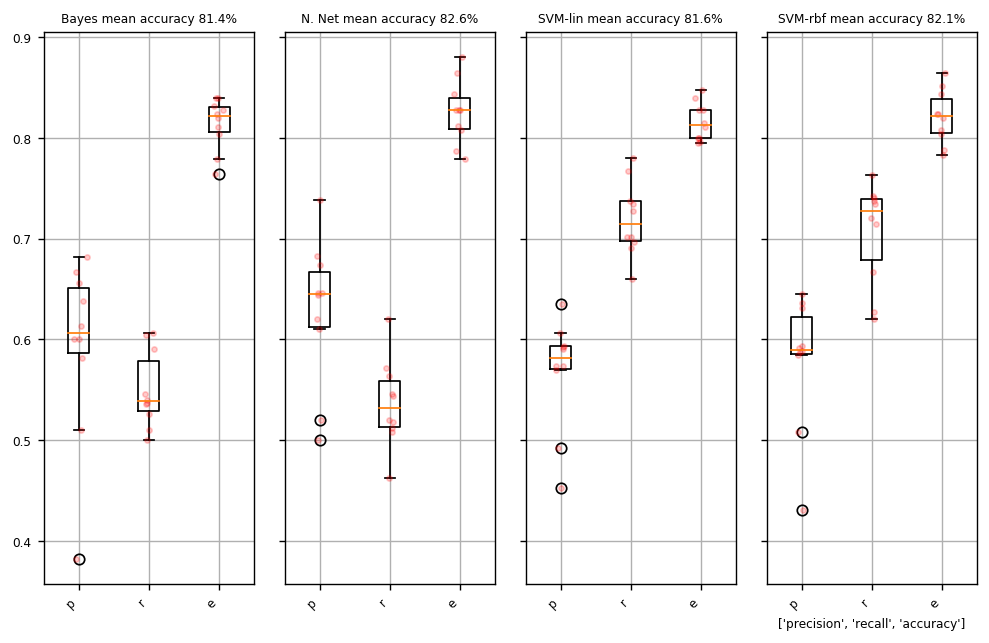

In [266]:
fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.xlabel(['precision', 'recall', 'accuracy'])
plt.show()

1


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


2


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


9


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


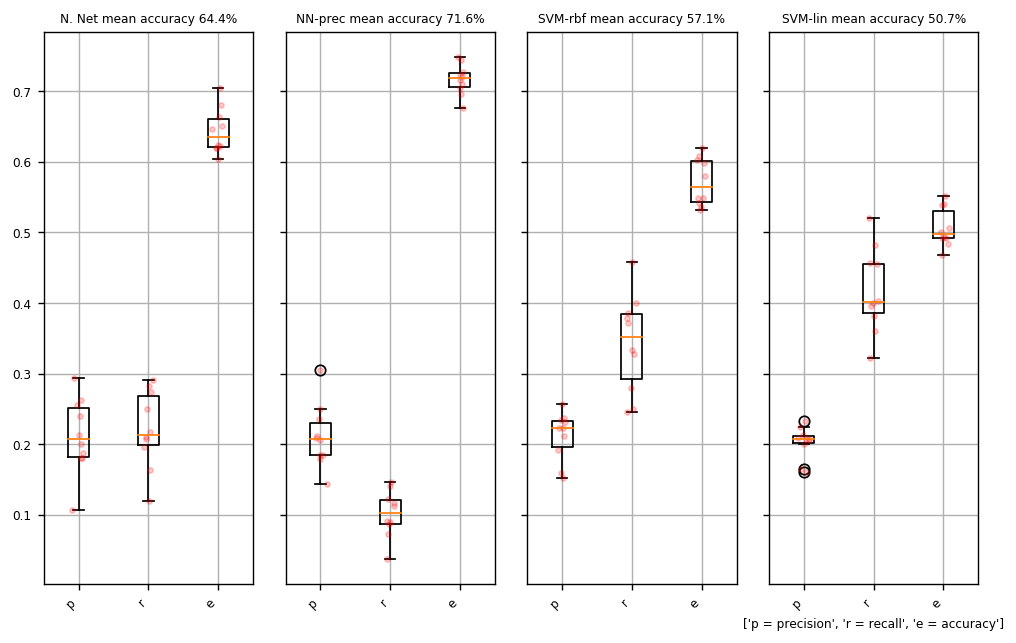

In [61]:
#Same for doc2vec
models = [
    {
        'title':"N. Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            activation= 'tanh',
            alpha=0.005,
            hidden_layer_sizes=(50,50,50), 
            random_state=2020
        )
    },
    {
        'title':"NN-prec",
        'model': MLPClassifier(
            solver='lbfgs', 
            activation= 'tanh',
            alpha=0.1,
            hidden_layer_sizes=(50,),
            learning_rate = 'adaptive',
            max_iter = 500,
            random_state=2020
        )
    },
    #Bayes cannot handle negative values -- leaving for now. Normalize later?
#     {
#         'title': 'Bayes', 
#         'model': MultinomialNB(alpha=0.1)     
#     },
    {
        'title': 'SVM-rbf',
        'model': SVC(kernel='rbf',class_weight='balanced', C=1, gamma=0.5, probability=True, random_state= 42)
    },
        {
        'title': 'SVM-lin',
        'model': SVC(kernel='linear',class_weight='balanced', C=1, probability=True, random_state= 42)
    }
    
]

models2, df = cross_validate_models(ab_X_d2v, y, models, seen_index,df=df)#, returnAll=False)

fig, axs = plt.subplots(1, len(models2),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.xlabel(['p = precision', 'r = recall', 'e = accuracy'])
plt.show()

In [18]:
#Function altered above from standard on the platform (under learning utensils) to append all scores
df.loc[seen_index, df.columns[-len(models)-1:]]

,y_k_prediction_Bayes,y_k_prediction,y_k_prediction_NN-prec,y_k_prediction_N. Net,y_k_prediction_SVM-lin,y_k_prediction_SVM-rbf
27,0.046255,0.133665,2.370610e-02,1.090153e-03,0.148831,0.133665
35,0.625634,0.528800,1.577051e-01,1.921826e-03,0.524529,0.528800
48,0.001088,0.011702,1.780137e-05,1.433975e-12,0.015115,0.011702
53,0.041387,0.019587,4.848514e-06,8.464881e-14,0.028356,0.019587
67,0.442632,0.431148,5.865358e-01,1.816695e-01,0.481054,0.431148
...,...,...,...,...,...,...
50363,0.777833,0.284192,1.221866e-01,7.387027e-03,0.205047,0.284192
50370,0.000939,0.010165,4.373090e-06,1.260964e-14,0.012214,0.010165
50415,0.000677,0.008435,2.076387e-07,2.522575e-18,0.010035,0.008435
50419,0.196056,0.123824,1.283488e-02,3.753955e-05,0.194608,0.123824


In [267]:
df['dif_NN-SVM'] = df['y_k_prediction_N. Net'] - df['y_k_prediction_SVM-rbf']
for n in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f"Difference of more than {n}: {len(df.loc[df['dif_NN-SVM'].abs()>n])}")
print()
          
lnnet = len(df.loc[(df['y_k_prediction_N. Net'] > 0.5) 
       & (df['y_k_prediction_SVM-rbf'] < 0.5) 
       & (df['dif_NN-SVM'].abs() > 0.2)])
       
lsvm = len(df.loc[(df['y_k_prediction_N. Net'] < 0.5) 
       & (df['y_k_prediction_SVM-rbf'] > 0.5) 
       & (df['dif_NN-SVM'].abs() > 0.2)])

print(f"Excluded in SVM, included in N. Net with >0.2 difference: {lnnet}")
print(f"Excluded in N. Net, included in SVM with >0.2 difference: {lsvm}") 
          


Difference of more than 0.1: 1204
Difference of more than 0.2: 720
Difference of more than 0.3: 424
Difference of more than 0.4: 229
Difference of more than 0.5: 98

Excluded in SVM, included in N. Net with >0.2 difference: 98
Excluded in N. Net, included in SVM with >0.2 difference: 67


### Simple tuning
Finding the best hyper-parameters for these test models. Used to make intermediate predictions chiefly; for final model, use nested method

In [255]:
#Tuning SVM
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Split the dataset in two parts
X_train, X_test, y_train, y_test = train_test_split(
                                    ab_X_d2v[seen_index], 
                                    y[seen_index], test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma': ["auto", "scale", 0.05, 0.1, 0.5, 1],
                     'C': [0.01, 0.1, 1, 10, 50]},
                    
                    {'kernel': ['linear'], 
                     'C': [0.1, 0.5, 1, 10, 50]}]

scores = ['f1'] #'precision', 'recall',

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(class_weight='balanced'), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("\nDetailed classification report:\n")
    #Now apply to the test set to get an idea of performance/if we're overfitting
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, target_names=['training', 'test']))
    print("\n\n")

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.391 (+/-0.234) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
0.391 (+/-0.234) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.391 (+/-0.234) for {'C': 0.01, 'gamma': 0.05, 'kernel': 'rbf'}
0.391 (+/-0.234) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.391 (+/-0.234) for {'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}
0.391 (+/-0.234) for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 0.1, 'gamma': 0.05, 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.449 (+/-0.001) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.489 

In [257]:
#Tuning Neural net
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Split the dataset in two parts
X_train, X_test, y_train, y_test = train_test_split(
                                    ab_X_d2v[seen_index], 
                                    y[seen_index], test_size=0.25, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{
                    'learning_rate': ['adaptive', 'constant'],
                    'hidden_layer_sizes': [(50,50), (50,100,50), (100,), (50,)],#, (10)],
                     'activation': ['tanh', 'relu'],
                     'solver': ['lbfgs'], #'adam' leads to higher precision but drop in recall
                     'alpha': [0.005, 0.05, 0.5, 1] 
                    }]

scores = ['f1']#, "precision", "recall"] #'precision', 'recall', 

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    mlp = MLPClassifier(max_iter=100)
    clf = GridSearchCV(
        mlp, tuned_parameters, n_jobs=-1, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("\nDetailed classification report:\n")
    #Now apply to the test set to get an idea of performance/if we're overfitting
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, target_names=['training', 'test']))
    print("\n\n")
    

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}

Grid scores on development set:

0.507 (+/-0.049) for {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.516 (+/-0.046) for {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.499 (+/-0.044) for {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.493 (+/-0.030) for {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.502 (+/-0.060) for {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.506 (+/-0.059) for {'activation': 'tanh', 'alpha': 0.005, 'hid

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
clf


In [ ]:
#Tuning Random Forest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Split the dataset in two parts
X_train, X_test, y_train, y_test = train_test_split(
    ab_X[seen_index], y[seen_index], test_size=0.25, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{
                    'n_estimators': [200, 500, 1000],
                    'max_features': ['auto', 'log2'],
                    'max_depth' : [None, 2,4,6,8,12],
                    'criterion' :['gini', 'entropy']
                    }]

scores = ['f1', "recall", 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    rfc = RandomForestClassifier(random_state= 2020)
    clf = GridSearchCV(
        rfc, tuned_parameters, n_jobs=-1, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("\nDetailed classification report:\n")
    #Now apply to the test set to get an idea of performance/if we're overfitting
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, target_names=['training', 'test']))
    print("\n\n")
    

### Fit to unseen data
We can choose the best performing model (for our purposes) and fit it on our unseen data, in order to predict the probability that our unseen documents are relevant

In [269]:
clf = SVC(kernel='rbf',class_weight='balanced', C=1, gamma=0.5, probability=True, random_state= 2020)

# clf= MLPClassifier(
#             solver='lbfgs', 
#             activation= 'tanh',
#             alpha=0.005,
#             hidden_layer_sizes=(100), 
#             random_state=2020
#         )

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexes/range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


4719 out of 47818 documents are predicted to be relevant


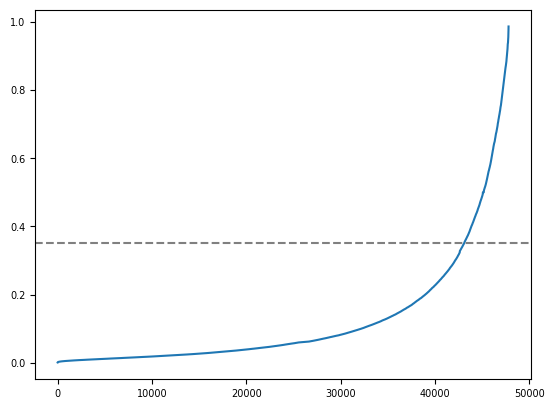

In [270]:
plt.close()

threshold = 0.35

df['0 - relevance - prediction'] = None
df.loc[unseen_index,'0 - relevance - prediction'] = y_pred[:,1]

predicted_index = df[df['0 - relevance - prediction']>threshold].index

fig, ax = plt.subplots()

pdf = df.sort_values('0 - relevance - prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['0 - relevance - prediction'])
ax.axhline(threshold,linestyle="--",color="grey")

rel = df[pdf['0 - relevance - prediction']>threshold].shape[0]
tot = pdf[pdf['0 - relevance - prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','y_k_prediction']].to_csv(f'predictions/{now}_svm.csv',index=False)#removed doctables/ from dir

plt.show()

### Saving the outcome

In [23]:
#Added to write relevant docs to csv
#threshold = 0.33# set if you didn't set it above
RelevantDocs  = df[(df['0 - relevance - prediction'] >= threshold) | (df['relevant'] == 1)]
RelevantDocs[['id', 'PY', 'title', 'content']].to_csv(f'predictions/{now}_PredictedRelevant.csv', index = False)

RelevantDocs.shape

(5438, 104)

In [24]:
#writing a smaller DF with just the IDs, human-made labels, and machine prediction
outdf = df[['id', 'relevant', 'seen', '0 - relevance - prediction']]
outdf.loc[outdf['seen'] ==0, 'relevant'] = None
outdf = outdf[['id', 'relevant', '0 - relevance - prediction']]
outdf.columns = ['id', 'label', 'prediction']

outdf.to_csv(f'predictions/IdLabelPrediction_{now}.csv', index=False)
outdf.head()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,label,prediction
0,1639184,NaN,0.0636457
1,335928,NaN,0.193312
2,1288398,NaN,0.5
3,668975,NaN,0.00510185
4,3963682,NaN,0.023389


In [271]:
#Df output to be used for BERT
cols = ['id', 'content', 'title', 'relevant', 'seen', 'random',
        '2 - Adaptation', '2 - Mitigation', '2 - Other', #Adaptation vs mitigation
        #'3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
        '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation', #Top level NATO only for now
        '7 - International', '7 - National', '7 - Subnational ', #Governance level
        '9 - Ex-ante', '9 - Ex-post', #Study type
        'y_k_prediction_SVM-rbf', '0 - relevance - prediction' #For comparisson
]

bertdf = df[cols]
bertdf.loc[bertdf['seen'] ==0, 'relevant'] = None
for c in cols:
    bertdf.loc[bertdf[c] ==0, c] = None

bertdf.to_csv(f'predictions/ForBERT_{now}.csv', index=False, encoding='utf-8')
bertdf.head()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,4 - 1. Nodality,4 - 3. Treasure,4 - 4. Authority,4 - 4. Organisation,7 - International,7 - National,7 - Subnational,9 - Ex-ante,9 - Ex-post,y_k_prediction_SVM-rbf,0 - relevance - prediction
0,4914081.0,Aviation emissions of nitrogen oxides (NOx) al...,Greater fuel efficiency is potentially prefera...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0161114
1,280262.0,Mid-season drainage (MSD) decreases methane em...,Interannual variations in methane emission fro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0141873
2,1288320.0,Understanding the extent to which agriculture ...,The potential benefits of agricultural adaptat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0594079
3,129554.0,This study investigates future impacts of glob...,Potential influences of global warming on futu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0257975
4,345398.0,"Zebra mussels (Dreissena polymorpha, Pallas, 1...",Effects of increasing temperatures on populati...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00858222


In [31]:
#create a new query that can be used for topic modelling for example
newq, created = Query.objects.get_or_create(
    project=p,
    creator=User.objects.get(username="eeajs@leeds.ac.uk"),
    title=f"{now}_Predicted relevantSVM"
)

T = Doc.query.through
dqs = [T(doc_id=did, query=newq) for did in list(RelevantDocs['id'])]
T.objects.bulk_create(dqs)
newq.r_count = newq.doc_set.count()
newq.save()

In [92]:
tag, created = Tag.objects.get_or_create(
     query=merged_query,
     title=f"{now}_Predicted relevantNN" #this will be given in the system as the tag name
)

for i, row in RelevantDocs.iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [123]:
#May also want to assign tags to false positives/negatives
FalsePositives = df[(df['y_k_prediction_N. Net'] >= threshold) & (df['relevant'] ==0)].sort_values('y_k_prediction_N. Net')
FalseNegatives = df[(df['y_k_prediction_N. Net'] <= threshold) & (df['relevant'] ==1)].sort_values('y_k_prediction_N. Net')

print(f"False positives: {FalsePositives.shape[0]} -- False negatives: {FalseNegatives.shape[0]}")

tag, created = Tag.objects.get_or_create(
     query=merged_query,
     title=f"{now}_FalsePositivesNN" #this will be given in the system as the tag name
)
for i, row in FalsePositives.head(25).iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
    
tag.update_tag()
    
tag, created = Tag.objects.get_or_create(
     query=merged_query,
     title=f"{now}_FalseNegativesNN" #this will be given in the system as the tag name
)
for i, row in FalseNegatives.head(25).iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
    
tag.update_tag()

False positives: 205 -- False negatives: 258


In [121]:
for i, row in FalsePositives.head(25).iterrows():
    print(row['id'])

760421
1293330
1795218
252419
3828541
144170
2393213
18681
467254
4806816
153032
89030
1288344
2402921
320851
3789155
451586
315752
4296816
492794
775263
2303616
4916755
4377579
221142


### Evaluation of model

In [27]:
#SIMPLE EXAMPLE TO GET AN IDEA FOR HOW MUCH ADDED TRAINING DATA ADDS
#Requires re-training so will take a while
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#clf = SVC(kernel='rbf',class_weight='balanced',probability=True)

#y = df['relevant']

#WITH A RANDOM SAMPLE
scores = []
steps = np.linspace(0.05,1,10,endpoint=True)

#basically: take a random sample from the relevance column, use the index to create a matching sample from ab_x for different sizes
for n in steps:
    ysample = y[seen_index].sample(n=math.floor(y[seen_index].shape[0]*n))
    score = cross_val_score(clf,
                            ab_X[ysample.index],
                            ysample, 
                            cv=5,  scoring='f1')
    scores.append([len(ysample), score.mean(), score.std()*2])

scores

[[124, 0.20317460317460317, 0.3514502223009028],
 [388, 0.37160909266172426, 0.21450980710773546],
 [651, 0.5602272403881727, 0.10628660082496952],
 [914, 0.6440612165612165, 0.05563132407155552],
 [1178, 0.6002892386891336, 0.08380447599504756],
 [1441, 0.6270759895454698, 0.05509622526693949],
 [1704, 0.614464865752958, 0.08914898932027827],
 [1968, 0.6304209702186712, 0.05424936265028659],
 [2231, 0.6409476304173629, 0.0284766902173747],
 [2495, 0.6434862609836093, 0.04194037190387367]]

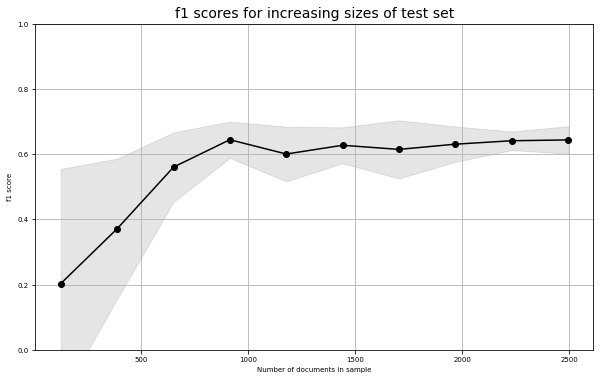

In [28]:
plt.close()
fig, ax = plt.subplots(figsize=(10,6))

xplot = [score[0] for score in scores]
yplot = [score[1] for score in scores]
yerr = [score[2] for score in scores]

ax.plot(xplot, yplot, 'k-o')

ax.fill_between(xplot,np.subtract(yplot,yerr), np.add(yplot, yerr),
                 color='gray', alpha=0.2)

ax.set_ylim(bottom=0, top=1)
ax.set_ylabel('f1 score')
ax.set_xlabel('Number of documents in sample')
ax.set_title('f1 scores for increasing sizes of test set', fontsize=14)
ax.grid()

plt.show()

KeyError: 'auc'

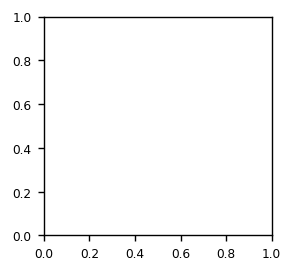

In [272]:
# #Using the original k-fold crossvalidation: Area under curve plots
# from scipy import interp
# fig = plt.figure(dpi=125, figsize=(8,5))
# for j, model in enumerate(models):
#     ax = fig.add_subplot(2,3,j+1)
#     mean_fpr = np.linspace(0, 1, 100)
#     mean_auc = np.mean(model[f'auc'])
#     std_auc = np.std(model[f'auc'])
#     tprs = []
#     for i in range(len(model['i'])):
#         viz = ax.plot(
#             model[f'fpr'][i],
#             model[f'tpr'][i],
#             lw=0.5,
#             alpha=0.5,
#             color=f"C1"
#         )
#         interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
#         interp_tpr[0] = 0.0
#         tprs.append(interp_tpr)
        
#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     ax.plot(mean_fpr, mean_tpr, color='b',
#     label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#     lw=1, alpha=.8)
#     ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
#         label='Chance', alpha=.8)

#     ax.legend(fontsize=5)
#     ax.set_aspect("equal")
#     ax.set_title(model['title'],fontsize=8)
#     ax.set_ylabel('True positive rate')
#     ax.set_xlabel('False positive rate')
    
#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                     label=r'$\pm$ 1 std. dev.')
    
        
# fig.tight_layout()

KeyError: 'auc'

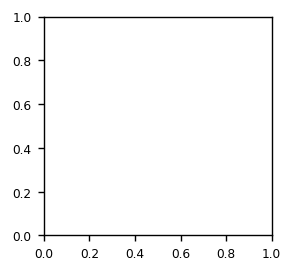

In [273]:
# #Precission-recall plots 
# from scipy import interp
# fig = plt.figure(dpi=125, figsize=(8,5))
# for j, model in enumerate(models):
#     ax = fig.add_subplot(2,3,j+1)
#     mean_fpr = np.linspace(0, 1, 100)
#     mean_auc = np.mean(model[f'auc'])
#     std_auc = np.std(model[f'auc'])
#     tprs = []
#     for i in range(len(model['i'])):
#         viz = ax.plot(
#             model[f'rec'][i],
#             model[f'prec'][i],
#             lw=0.5,
#             alpha=0.5,
#             color=f"C1"
#         )
#     ax.set_ylabel('precision')
#     ax.set_xlabel('recall')
#     ax.set_title(model['title'],fontsize=8)
        
# fig.tight_layout()

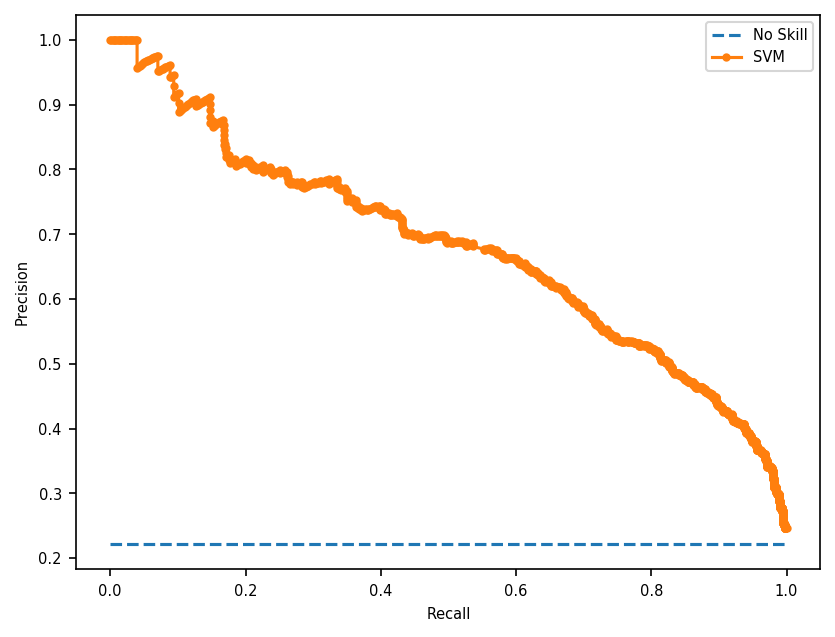

In [274]:
from sklearn.metrics import f1_score, auc

#predict probabilities
#lr_probs = clf.predict_proba(testX)
#r_probs = lr_probs[:, 1] #keep positive outcomes

fig, ax = plt.subplots(dpi=150)

lr_probs = df.loc[seen_index,'y_k_prediction_SVM-rbf'] #use y_k_prediction instead if using unaltered code
lr_true = df.loc[seen_index,'relevant']

# predict class values
#yhat = clf.predict(testX)

# summarize scores
lr_precision, lr_recall, _ = lr_precision, lr_recall, thresholds = precision_recall_curve(lr_true, lr_probs)

#lr_f1, lr_auc = f1_score(lr_true, lr_probs), auc(lr_true, lr_probs)
#print('For sample: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(lr_true[lr_true==1]) / len(lr_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='SVM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show() 

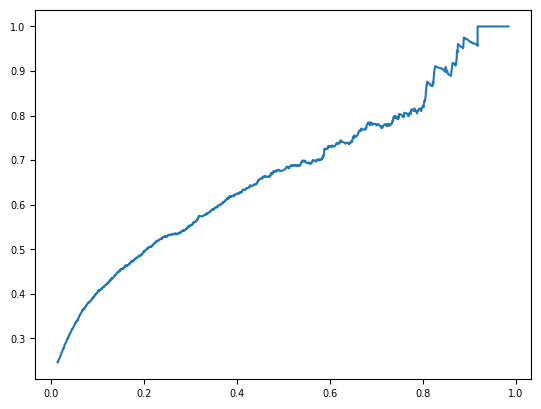

In [275]:
plt.plot(thresholds,lr_precision[:-1])

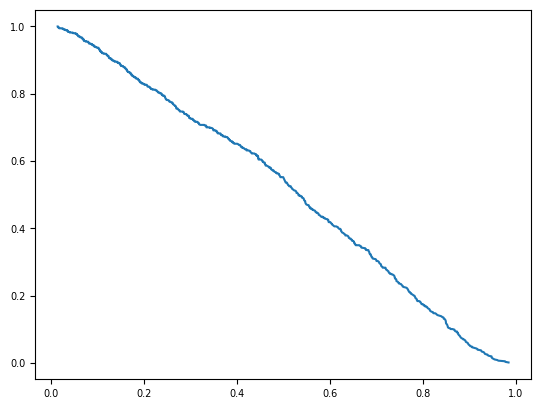

In [276]:
plt.plot(thresholds,lr_recall[:-1])

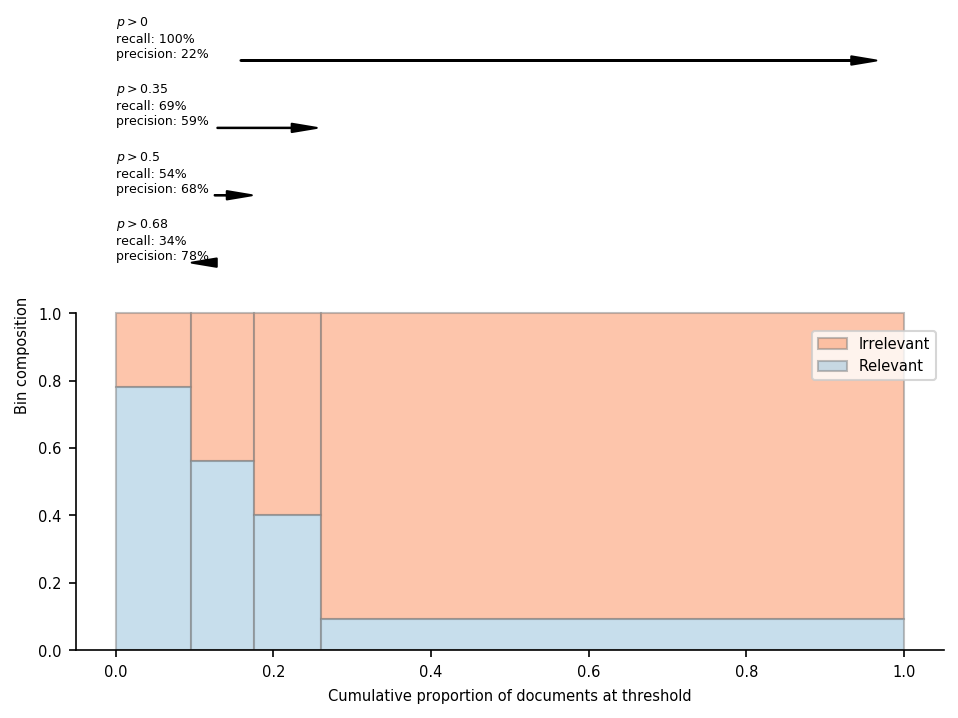

In [277]:
#If we want to play with the thresholds, we can use this function to see what the added/removed data looks like
import seaborn as sns

def precision_recall_bins(lr_true, lr_probs, bt):    
    fig, ax = plt.subplots(dpi=150)    
    categories = []
    
    for i in range(len(bt)-1):
        categories.append((bt[i+1],bt[i]))    
        
        l = 0
    for i,c in enumerate(categories):
        y_thresh_pred = np.where(lr_probs>c[0],1,0)
        y_bin_pred = np.where(np.logical_and(lr_probs<=c[1],lr_probs>c[0]),1,0)        
        
        bin_p = precision_score(lr_true,y_bin_pred)
        thresh_p = precision_score(lr_true,y_thresh_pred)   
        thresh_r = recall_score(lr_true,y_thresh_pred)           
        width = y_bin_pred.sum()/lr_true.shape[0]        
        
        if i==0:
            rl = "Relevant"
            il = "Irrelevant"
        else:
            rl=None
            il=None
            
        ax.bar(l, 1-bin_p,bottom=bin_p, width=width, align="edge",color="#fc8d59",ec="grey",alpha=0.5,label=il)
        ax.bar(l, bin_p, width=width, align="edge",color="#91bfdb",ec="grey",alpha=0.5,label=rl)        
        
        ly = 1.15+0.2*i        
        ax.annotate(
            f"$p>{c[0]}$ \nrecall: {thresh_r:.0%}\nprecision: {thresh_p:.0%}",
            (l+width,ly),(0,ly),
            arrowprops=dict(facecolor='black', shrink=0.04,width=0.2,headwidth=4),
            va="bottom", fontsize=6
        )
        
        l += width    
        
        sns.despine()    
        
        ax.spines['left'].set_bounds(0, 1)    
        
        ax.set_ylim(ymax=ly)
    ax.set_yticks([t for t in ax.get_yticks() if t <=1])
    ax.set_ylabel("Bin composition")
    ax.set_xlabel("Cumulative proportion of documents at threshold")    
    ax.legend(loc="right")    
    fig.tight_layout()
    
precision_recall_bins(lr_true, lr_probs, [1,0.68, 0.5, 0.35, 0]) #Start with 1, end with 0 so we see whole dataset

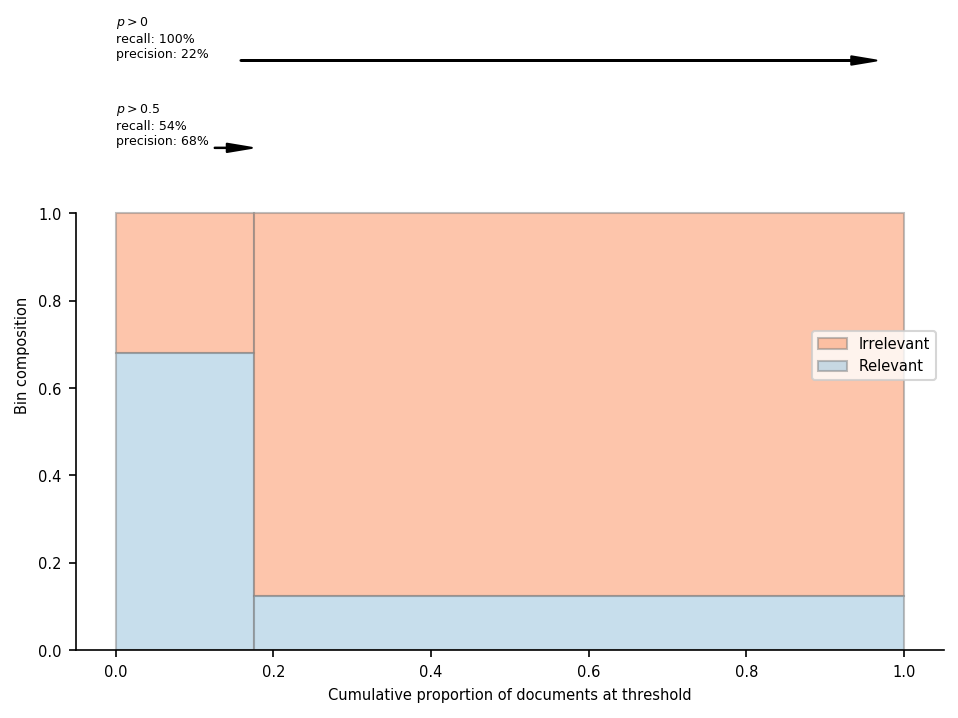

In [278]:
 precision_recall_bins(lr_true, lr_probs, [1,0.5, 0])

### Getting false positives/-negatives for a given threshold

In [281]:
#highest predicted
df.sort_values("y_k_prediction_SVM-rbf",ascending=False).head()

,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random,2 - Adaptation,...,10 - Governance,10 - Resources,10 - Other,y_k_prediction_Bayes,y_k_prediction,y_k_prediction_N. Net,y_k_prediction_SVM-lin,y_k_prediction_SVM-rbf,dif_NN-SVM,0 - relevance - prediction
46030,1782402,Three hundred and fifty municipalities across ...,Institutionalizing the urban governance of cli...,2015.0,Cities; Adaptation; Governance; Local governme...,[Environmental Sciences; Meteorology & Atmosph...,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.931153,0.984298,1.0,0.982289,0.984298,0.015702,None
28504,1628209,With poverty alleviation and sustainable devel...,Implementing climate change adaptation: lesson...,2019.0,Climate change; adaptation finance; public pol...,[Environmental Studies; Public Administration],1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.988588,0.977570,1.0,0.980250,0.977570,0.022430,None
17294,4912656,Local strategies and policies are key in clima...,Transforming Local Climate Adaptation Organiza...,2021.0,climate adaptation; local government; transfor...,[Meteorology & Atmospheric Sciences],1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.977453,0.976638,1.0,0.983113,0.976638,0.023362,None
11624,400718,"The GLCC, one of the first, and strongest, nat...",Four goals,2013.0,0,0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.873672,0.962283,1.0,0.945472,0.962283,0.037717,None
42956,2345601,Context: Human health is threatened by climate...,Minigrants to Local Health Departments: An Opp...,2019.0,climate change; emergency preparedness; local ...,"[Public, Environmental & Occupational Health]",1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.892341,0.960121,1.0,0.939882,0.960121,0.039879,None


In [286]:
#playing with the threshold (kind of irrelevant given additional analysis above, but easy reference)
threshold = 0.45
likely = np.where(df['y_k_prediction']>threshold,1,0)
p = precision_score(df.loc[seen_index,"relevant"],likely[seen_index])
r = recall_score(df.loc[seen_index,"relevant"],likely[seen_index])

print(f"Threshold: {threshold}, precision: {p:.2g}, recall: {r:.2g}")

Threshold: 0.45, precision: 0.66, recall: 0.6


In [288]:
#print false positives just above the border
threshold = 0.5
fp_both = df[(df['relevant']==0) & (df[f'y_k_prediction_SVM-rbf']>threshold) & (df[f'y_k_prediction_N. Net']>threshold)]
print(fp_both.shape)
django.db.connection.close()
for i, row in fp_both.sort_values('y_k_prediction_SVM-rbf',ascending=True).head(3).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(f"SVM:{row['y_k_prediction_SVM-rbf']} Neural Net: {row['y_k_prediction_N. Net']}")
    print(d.docownership_set.filter(query=merged_query).values('user__username','relevant','finish','tag__title'))

(110, 38)

COLLABORATIVE STRATEGIES FOR SEA LEVEL RISE ADAPTATION IN HAMPTON ROADS, VIRGINIA
INTRODUCTION The Hampton Roads region is located in southeastern Virginia where the Chesapeake Bay meets the Atlantic Ocean. The region includes seventeen municipal governments and has a large federal government presence with 26 federal agencies represented (See Figure 1). The region has a population that exceeds 1.7 million and is home to the deepest water harbor on the U.S. East Coast. Hampton Roads' economy is dependent on the local waterways and houses the world's largest naval facility, the sixth largest containerized cargo complex and supports a thriving shipbuilding and repair industry as well as a tourism industry. However, the region's vast coastline also contributes to its vulnerability from climate change. Hampton Roads is experiencing sea level rise at twice the global rate with regional projections in the January 2017 National Oceanic and Atmospheric Administration (NOAA) report, G

In [289]:
#False postives
fp = df[(df['relevant']==0) & (df[f'y_k_prediction']>0.5)]
print(fp.shape)
django.db.connection.close()

#print highest scoring ones
for i, row in fp.sort_values('y_k_prediction',ascending=False).head(3).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query=merged_query).values('user__username','relevant','finish','tag__title'))

(139, 38)

Bookkeeping rather than climate policy making: national mitigation strategies in Western Europe
Climate change mitigation is a wicked problem that cuts horizontally across sectors and vertically across levels of government. To address it effectively, governments around the world, in particular in the EU, have developed several generations of multi-sectoral national mitigation strategies (NMS) since the early 1990s. Although NMS became the main effort to systematically coordinate mitigation policies, few works have studied them comparatively so far. The present article fills this gap by analysing how the EU-15 group of countries operationalized climate protection through NMS. First, we introduce the three roles policy strategies usually aim to fulfil: besides being policy documents they also represent governance processes (supposed to coordinate sectoral implementation), and capacity-building efforts. Empirically, we then explore the rationale, origins and prevalence of NMS. 

In [290]:
#False negatives
fn_both = df[(df['relevant']==1) & (df[f'y_k_prediction_SVM-rbf']<threshold) & (df[f'y_k_prediction_N. Net']<threshold)]
print(fn_both.shape)
django.db.connection.close()
for i, row in fn_both.sort_values('y_k_prediction_SVM-rbf',ascending=True).head(3).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query=merged_query).values('user__username','relevant','finish','tag__title'))

(203, 38)

Adaptation of Agricultural and Food Systems to a Changing Climate and Increasing Urbanization
Climate change will pose risks for the world’s food supply in the coming decades; this comes at a time when the global demand for food is expected to soar based on 2050 world population estimates. It is important to recognize that climate change will necessitate temporal and geographical shifts in food production, but will most likely not result in the collapse of our food systems. However, because of differences in the severity of how climate change will affect agriculture, regional and temporal changes in production and harvest-time will challenge the existing and sometimes outdated agricultural infrastructure with respect to collection, storage, transportation, and distribution of food. Increasing regional and global urbanization will further perturb these systems. Adaptation to climate change with respect to crop and food animal production will have to occur at multiple temporal

In [ ]:
#create a tag so I can check them out on the platform
tempq = merged_query 

tag, created = Tag.objects.get_or_create(
    title=f"false negatives{now}".format(now),
    query=tempq
)
tag.save()

for i, row in fn_both.sort_values('y_k_prediction_SVM-rbf',ascending=True).head(30).iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [ ]:
tag, created = Tag.objects.get_or_create(
    title=f"false positives{now}".format(now),
    query=tempq
)
tag.save()

for i, row in fp_both.sort_values('y_k_prediction_SVM-rbf',ascending=False).head(30).iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

# Now we want to look at categories
First, let's have a look at the numbers per category and then let's zoom in for mitigation and adaptation

In [291]:
df.columns

Index(['id', 'content', 'title', 'PY', 'wosarticle__de', 'wosarticle__wc',
       'relevant', 'seen', 'random', '2 - Adaptation', '2 - Mitigation',
       '2 - Other', '2 - Primarily not adaptation',
       '3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
       '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority',
       '4 - 4. Organisation', '7 - International', '7 - National',
       '7 - Subnational ', '8 - Coastal', '8 - Rivers', '8 - Terrestrial',
       '8 - Human', '9 - Ex-ante', '9 - Ex-post', '10 - Governance',
       '10 - Resources', '10 - Other', 'y_k_prediction_Bayes',
       'y_k_prediction', 'y_k_prediction_N. Net', 'y_k_prediction_SVM-lin',
       'y_k_prediction_SVM-rbf', 'dif_NN-SVM', '0 - relevance - prediction'],
      dtype='object')

In [33]:
cols = ['2 - Adaptation', '2 - Mitigation', '2 - Other', '2 - Primarily not adaptation',
        '3 - No maladaptation or no evidence', '3 - Yes - maladaptation',
        '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation', 
        '7 - International', '7 - National','7 - Subnational ', 
        '8 - Coastal', '8 - Rivers', '8 - Terrestrial',
        '8 - Human', '9 - Ex-ante', '9 - Ex-post', 
        '10 - Governance','10 - Resources', '10 - Other']

for c in cols:
    if df.loc[df['relevant'] == -1, c].sum() >= 1:
        print(f"{int(df.loc[df['relevant']==1, c].sum()):03d} relevant documents in class '{c}'", 
             f" --- Additional from other projects: {df.loc[df['relevant'] == -1, c].sum()}")
              
    else: 
         print(f"{int(df.loc[df['relevant']==1, c].sum()):03d} relevant documents in class '{c}'")

437 relevant documents in class '2 - Adaptation'
081 relevant documents in class '2 - Mitigation'  --- Additional from other projects: 1682.0
094 relevant documents in class '2 - Other'
173 relevant documents in class '2 - Primarily not adaptation'
292 relevant documents in class '3 - No maladaptation or no evidence'
039 relevant documents in class '3 - Yes - maladaptation'
084 relevant documents in class '4 - 1. Nodality'  --- Additional from other projects: 43.0
125 relevant documents in class '4 - 3. Treasure'  --- Additional from other projects: 402.0
197 relevant documents in class '4 - 4. Authority'  --- Additional from other projects: 396.0
102 relevant documents in class '4 - 4. Organisation'  --- Additional from other projects: 46.0
115 relevant documents in class '7 - International'  --- Additional from other projects: 338.0
235 relevant documents in class '7 - National'  --- Additional from other projects: 456.0
250 relevant documents in class '7 - Subnational '  --- Additio

In [293]:
df['categories'] = df['2 - Mitigation'] + df['2 - Adaptation'] + df['2 - Other']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen mitigation documents:", df.loc[df['seen']==1,'2 - Mitigation'].sum())
print("seen adaptation documents", df.loc[df['seen']==1,'2 - Adaptation'].sum())
print("seen impact documents", df.loc[df['seen']==1,'2 - Other'].sum())
print("seen in multiple", df.loc[df['categories']>=2,].shape[0])
print("seen non-mit/ad documents",df.loc[(df['seen']==1) & (df['categories']==0),].shape[0])

seen documents: 2495
seen mitigation documents: 105.0
seen adaptation documents 514.0
seen impact documents 114.0
seen in multiple 110
seen non-mit/ad documents 1859


## We want to do multiclass prediction now
Let's start predicting for one category. We name the classes and create a matrix of class labels

In [294]:
classes = ["2 - Mitigation","2 - Adaptation", "2 - Other"]
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

(52590, 3)


and cross validate a model to see how well we can predict

In [199]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='rbf', C=0.5, class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)


1
2
3
4
5
6


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
9


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


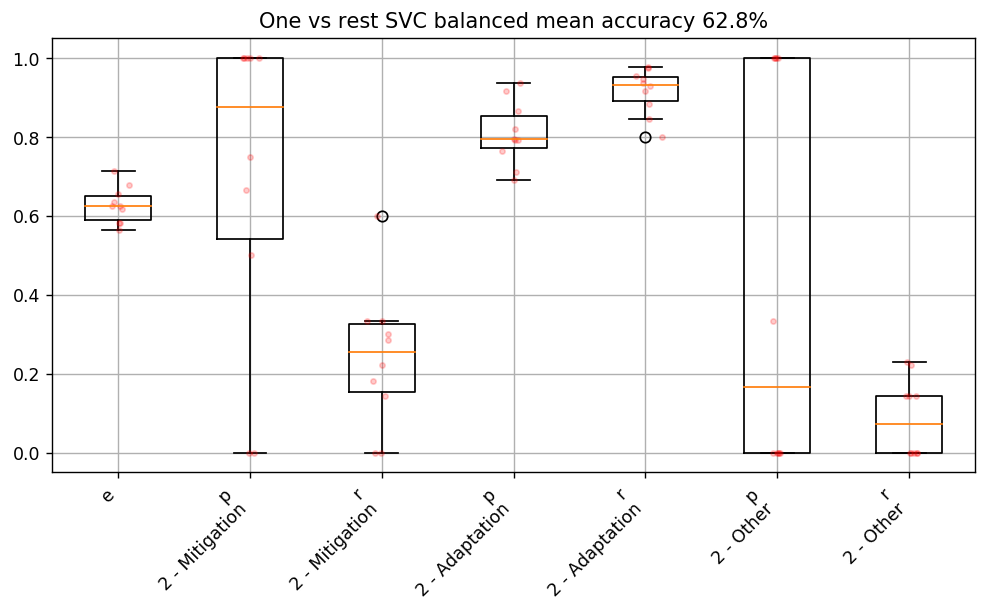

In [200]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

seen documents: 2495
relevant adaptation documents: 437.0
relevant non-adaptation documents 173.0
(52590, 2)
1
2
3
4
5
6
7
8
9
10


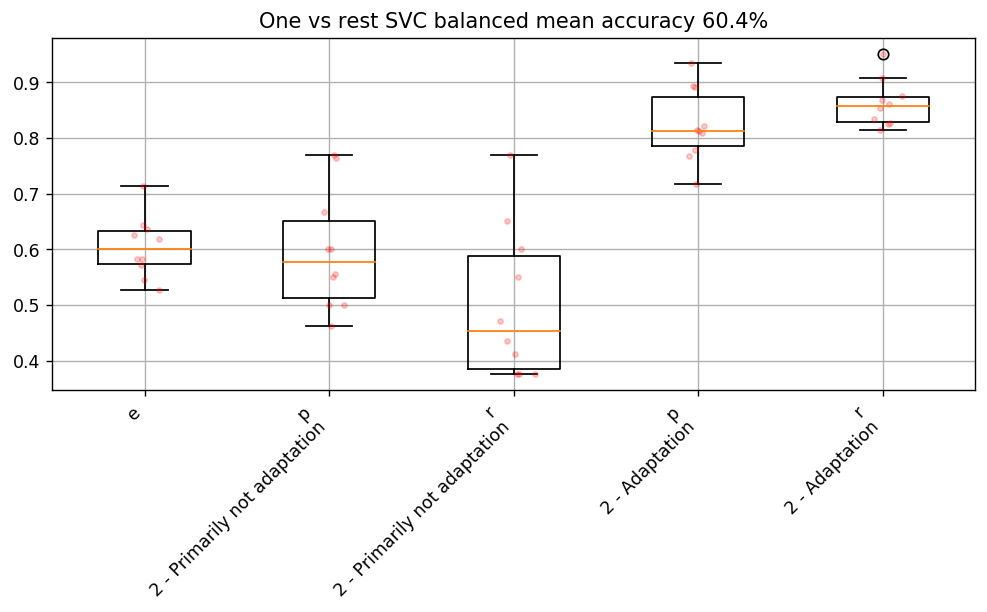

In [202]:
#Given performance, we may want to try on the merged class instead

classes  = ["2 - Primarily not adaptation", "2 - Adaptation"]

print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("relevant adaptation documents:", df.loc[df['relevant']==1,"2 - Adaptation"].sum())
print("relevant non-adaptation documents", df.loc[df['relevant']==1,"2 - Primarily not adaptation"].sum())

y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

In [204]:
#A look at some of the false 
df[(df['2 - Primarily not adaptation'] == 0) & 
   (df['2 - Primarily not adaptation - k_prediction'] >= 0.7)].title.head(20).to_list()

["China's Land Resources Dilemma: Problems, Outcomes, and Options for Sustainable Land Restoration",
 'REDD plus policy strategy in Cameroon: Actors, institutions and governance',
 'The WFD Implementation in the European Member States',
 'Ecological restoration as a strategy for mitigating and adapting to climate change: lessons and challenges from Brazil',
 'Focal points for sustainable development strategies-Text mining-based comparative analysis of voluntary national reviews',
 'Securing biodiversity, securing our future: A national Mission on biodiversity and human well-being for India',
 'Importance of local participation in achieving equity in benefitsharing mechanisms for REDD+: A case study from the juma sustainable development reserve',
 'Capacity building for implementation of nationally determined contributions under the Paris Agreement',
 'Four goals',
 'An update on the Clean Development Mechanism in Africa in times of market crisis',
 'River Basin Management Planning in t

In [301]:
#Now let's use some of the ones from different projects. First, defina a func as we will want to do that more often
#Get the indices of a sample (sample size should be relatively small to not bias the classifier too much)
def additionalIndex(df, cols, n_sample):
    if type(cols) == str: cols= [cols]
    
    additionalIndex = set()
    
    for c in cols:
        samples_present = df.loc[df['random'] == -1, c].sum()
        if samples_present < n_sample:
            print(f"{c} - warning: not enough samples. Using max. number of samples instead: {samples_present}")
            additionalIndex = additionalIndex.union(set(df[(df['random'] == -1) & (df[c] == 1)].index))
        else:
            sample = df[df['random'] == -1].sample(n = n_sample)
            additionalIndex = additionalIndex.union(set(sample.index))
    
    return([int(x) for x in additionalIndex])

2 - Adaptation - warning: not enough samples. Using max. number of samples instead: 0.0
2 - Other - warning: not enough samples. Using max. number of samples instead: 0.0
1
2
3
4
5
6
7
8
9
10


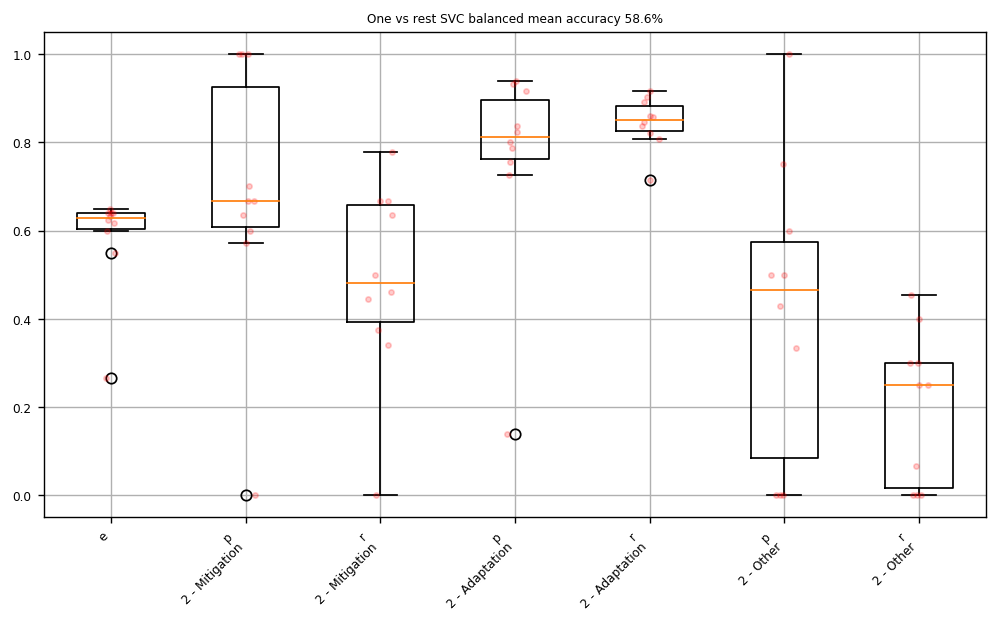

In [310]:
classes = ["2 - Mitigation","2 - Adaptation", "2 - Other"]

y = np.matrix(df[classes])

add = additionalIndex(df, classes, 50)

rel_index_add = np.array(df[df["relevant"]==1].index.union(add))
rel_index_add = rel_index_add.astype(int)

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index_add, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

In [306]:
rel_index_add = list(df[df["relevant"]==1].index.union(add))
rel_index_add

[112,
 344,
 349,
 425,
 515,
 591,
 1036,
 1141,
 1277,
 1333,
 1336,
 1423,
 1516,
 1556,
 1582,
 1627,
 1763,
 1810,
 1899,
 1912,
 2214,
 2274,
 2586,
 2620,
 2640,
 2754,
 2794,
 2901,
 2919,
 3064,
 3126,
 3144,
 3432,
 3584,
 3657,
 3719,
 3725,
 3811,
 3835,
 3885,
 3967,
 4299,
 4337,
 4391,
 4468,
 4556,
 4668,
 4710,
 4776,
 4860,
 4919,
 4959,
 5031,
 5101,
 5132,
 5209,
 5227,
 5291,
 5339,
 5341,
 5358,
 5385,
 5458,
 5469,
 5482,
 5784,
 5901,
 5905,
 6007,
 6426,
 6445,
 6612,
 6642,
 6840,
 6936,
 7057,
 7254,
 7261,
 7326,
 7416,
 7548,
 7562,
 7645,
 7658,
 7757,
 7790,
 8004,
 8081,
 8161,
 8284,
 8304,
 8373,
 8416,
 8531,
 8547,
 8658,
 8773,
 8830,
 8853,
 8877,
 9191,
 9229,
 9283,
 9366,
 9642,
 9688,
 9788,
 9838,
 9936,
 10311,
 10387,
 11024,
 11148,
 11225,
 11249,
 11292,
 11377,
 11480,
 11503,
 11551,
 11590,
 11624,
 11626,
 11633,
 11735,
 11849,
 11872,
 11884,
 12029,
 12127,
 12188,
 12411,
 12431,
 12525,
 12684,
 12721,
 12753,
 12774,
 12804,
 13

seen documents: 2495
seen maldaptation documents: 48.0
seen non-maladaptation documents 368.0
(52590, 2)
1


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7
8


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


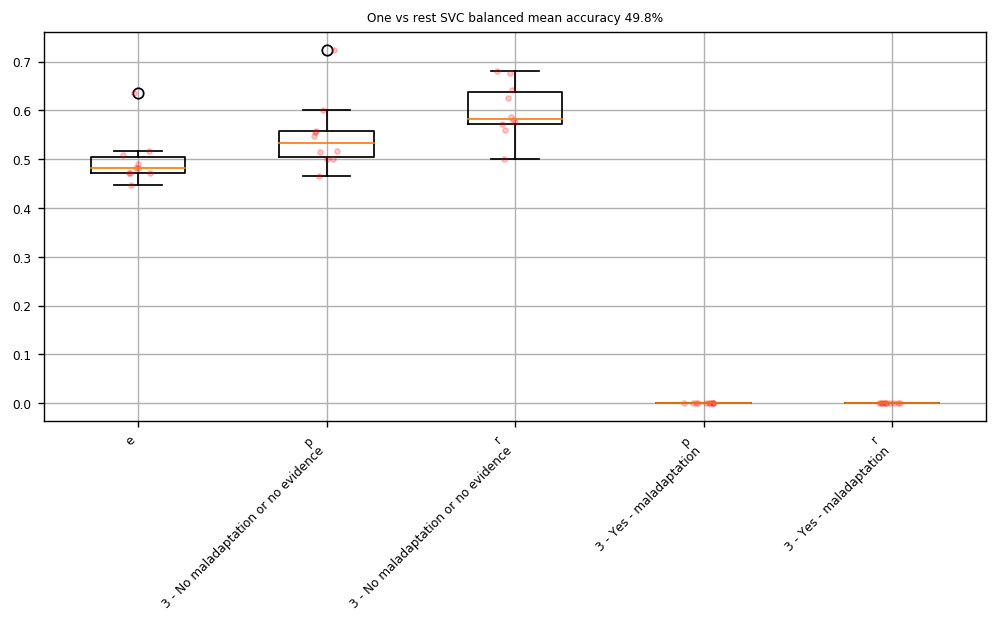

In [229]:
#All in one go example for maladaptation
classes  = ['3 - No maladaptation or no evidence', '3 - Yes - maladaptation']

print("seen maldaptation documents:", df.loc[df['seen']==1,'3 - Yes - maladaptation'].sum())
print("seen non-maladaptation documents", df.loc[df['seen']==1,'3 - No maladaptation or no evidence'].sum())

y = np.matrix(df[classes])
print(y.shape)



rel_index= df.loc[df["relevant"]==1,].index


multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

seen documents: 2495
Number of 7 - International documents: 115.0
Number of 7 - National documents: 235.0
Number of 7 - Subnational  documents: 250.0
(50469, 3)
1
2
3
4
5
6
7
8
9
10


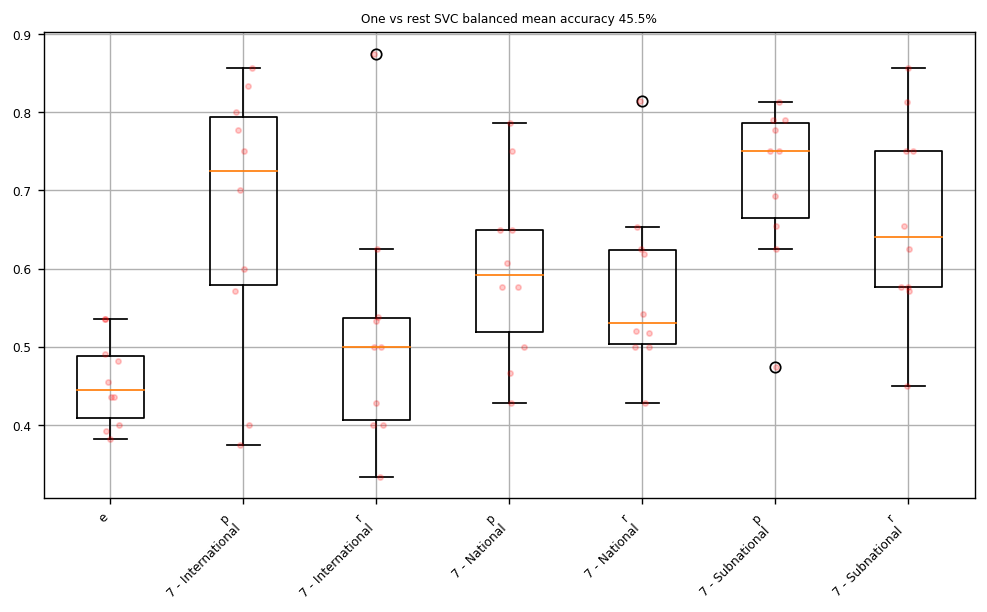

In [41]:
#All in one go example for Level
classes  = ['7 - International', '7 - National', '7 - Subnational ',]

print("seen documents:",df.loc[df['seen']==1,].shape[0])
for c in classes: 
    print(f"Number of {c.split('. ')[-1]} documents:", df.loc[df['relevant']==1,c].sum())
          
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

seen documents: 2495
Number of coastal documents: 81.0
Number of rivers documents: 118.0
Number of terrestrial documents: 69.0
Number of human documents: 110.0
(50469, 4)
1
2
3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
5
6
7


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
9
10


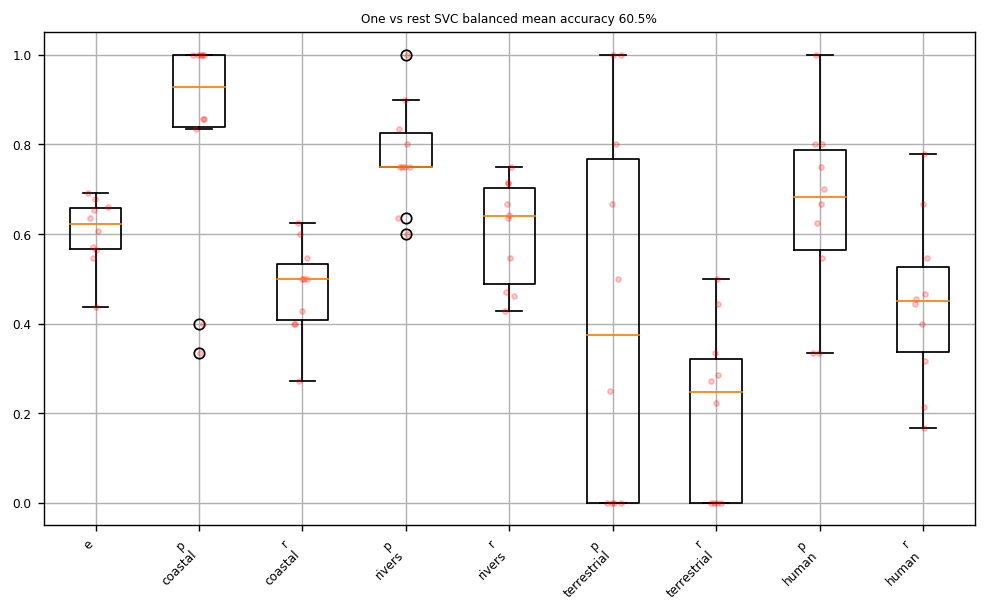

In [42]:
#All in one go example for impacts

#Here, we will want to merge too
mergedCols = {'coastal': ['8 - Coastal and marine','8 - Coastal erosion and/or sea level effects', '8 - Marine ecosystems', '8 - Storms & hurricanes'],
              'rivers': ['8 - Freshwater: rivers, lakes & soil moisture','8 - Rivers, lakes and floods',  '8 - Drought'], 
              'terrestrial': ['8 - Terrestrial natural systems','8 - Extreme heat', '8 - Glaciers, snow, ice and permafrost', '8 - Terrestrial ecosystems', '8 - Wildfire'], 
              'human': ['8 - Human and managed systems','8 - Food production', '8 - Livelihoods, health or economics',]
             }

for col in mergedCols:
    df[col] = np.nan
    df.loc[df['seen']==1,col] = 0
    for cat in mergedCols[col]:
        df.loc[df[cat] == 1 , col] = 1


classes  = list(mergedCols.keys())

print("seen documents:",df.loc[df['seen']==1,].shape[0])
for c in classes: 
    print(f"Number of {c.split('. ')[-1]} documents:", df.loc[df['relevant']==1,c].sum())
          
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

seen documents: 2495
Number of barriers documents: 211.0
(50469, 1)
1
2
3
4
5
6


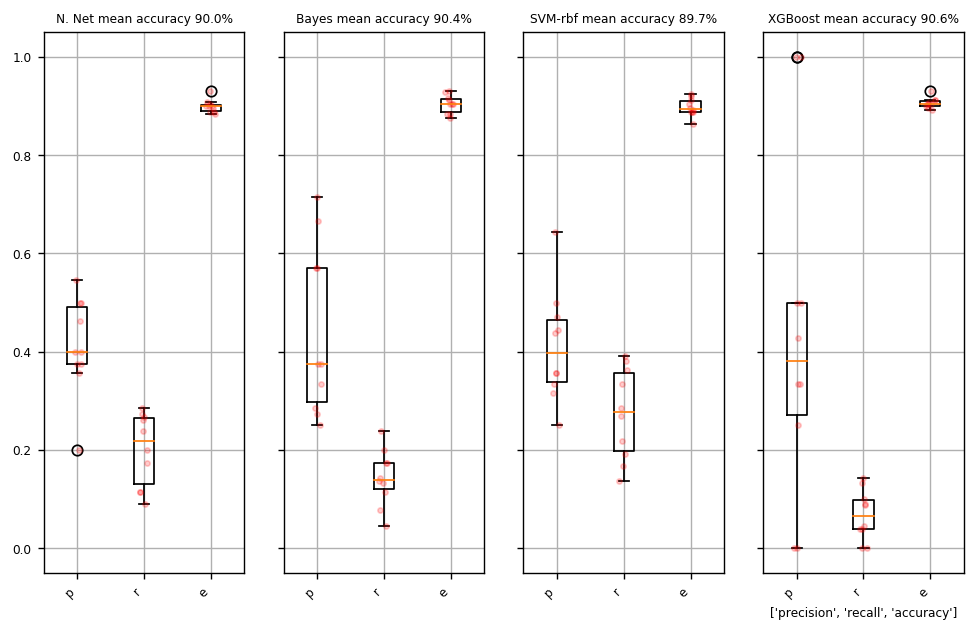

In [43]:
#All in one go example for barriers
#Not many examples, let's try Yes/No barriers first
#Add new column with NaN for not relevant, 0 for relevant but not in either, 1 for matching any col
barrierCols = ['10 - governance, institutions or policy', '10 - Resources', '10 - Other','10 - biological', '10 - economic', '10 - financial', '10 - human capacity', '10 - information, awareness or technology', '10 - physical', '10 - social or cultural',]
df['barriers'] = np.nan
df.loc[df['seen']==1,"barriers"] = 0
for col in barrierCols:
    df.loc[df[col] == 1, "barriers"] = 1


classes  = ['barriers']

print("seen documents:",df.loc[df['seen']==1,].shape[0])
for c in classes: 
    print(f"Number of {c.split('. ')[-1]} documents:", df.loc[df['relevant']==1,c].sum())
          
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

#NB: we have effectively a binary classifier again
#Given how imbalanced the data is, let's try XGBoost
#TODO: add weights? https://stackoverflow.com/questions/56505564/handling-unbalanced-data-in-gradientboostingclassifier-using-weighted-class
from sklearn.ensemble import GradientBoostingClassifier
y_bar = df['barriers']
models = [
    {
        'title':"N. Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            activation= 'tanh',
            alpha=0.005,
            hidden_layer_sizes=(50,50,50), 
            random_state=2020
        )
    },
    {
        'title': 'Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    },
    {
        'title': 'SVM-rbf',
        'model': SVC(kernel='rbf',class_weight='balanced', C=1, gamma=0.5, probability=True, random_state= 42)
    },
    
    {
        'title': 'XGBoost',
        'model': GradientBoostingClassifier()
    }
    
]

models, df = cross_validate_models(ab_X, y_bar, models, seen_index,df=df, returnAll=False)

fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.xlabel(['precision', 'recall', 'accuracy'])
plt.show()

seen documents: 2495
Number of governance documents: 159.0
Number of resources documents: 109.0
Number of other documents: 46.0
(50469, 3)
1


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
6


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  re

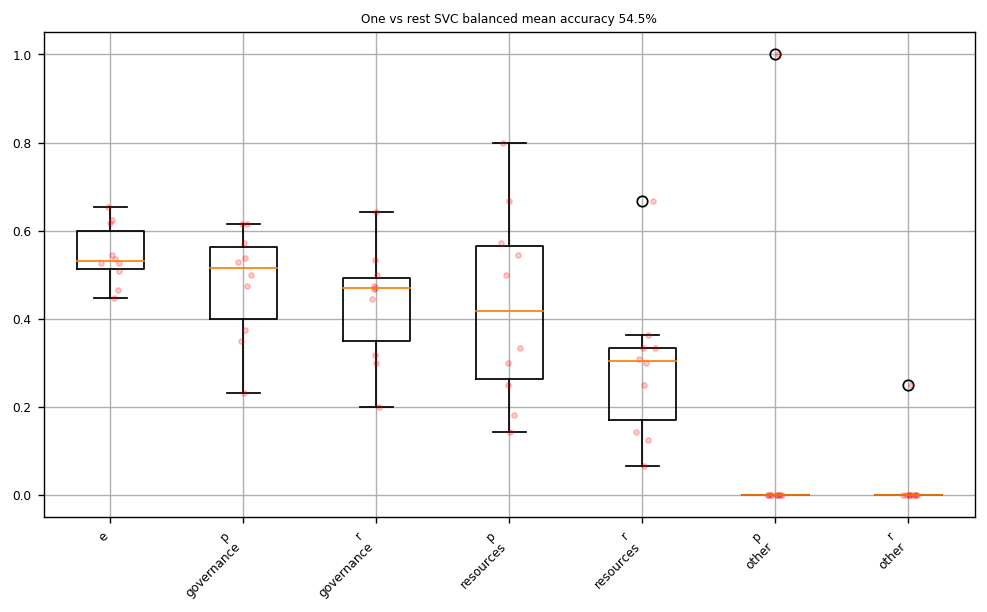

In [44]:
#Let's see if we can predict merged sub-categories
mergedCols = {'governance': ['10 - governance, institutions or policy',],
              'resources': ['10 - Resources', '10 - economic', '10 - financial', '10 - human capacity', '10 - information, awareness or technology'], 
              'other': ['10 - Other','10 - biological','10 - physical', '10 - social or cultural'], 
             }
 
for col in mergedCols:
    df[col] = np.nan
    df.loc[df['seen']==1,col] = 0
    for cat in mergedCols[col]:
        df.loc[df[cat] == 1 , col] = 1


classes  = list(mergedCols.keys())

print("seen documents:",df.loc[df['seen']==1,].shape[0])
for c in classes: 
    print(f"Number of {c.split('. ')[-1]} documents:", df.loc[df['relevant']==1,c].sum())
          
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

seen documents: 2495
Number of 9 - Ex-ante documents: 77.0
Number of 9 - Ex-post documents: 451.0
(50469, 2)
1
2
3
4
5
6
7
8
9
10


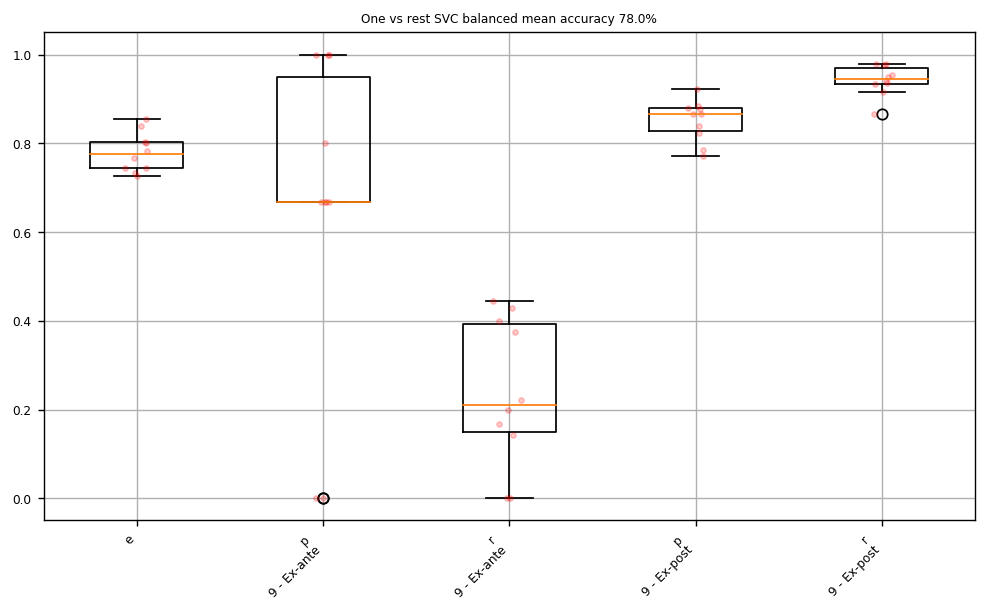

In [45]:
#All in one go example for ex-ante vs ex-post
classes  = ['9 - Ex-ante', '9 - Ex-post']

print("seen documents:",df.loc[df['seen']==1,].shape[0])
for c in classes: 
    print(f"Number of {c.split('. ')[-1]} documents:", df.loc[df['relevant']==1,c].sum())
          
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

seen documents: 2495
Number of Nodality documents: 107.0
Number of Treasure documents: 145.0
Number of Authority documents: 226.0
Number of Organisation documents: 111.0
Number of No NATO documents: 158
(50469, 5)
1
2
3
4
5
6
7
8
9
10


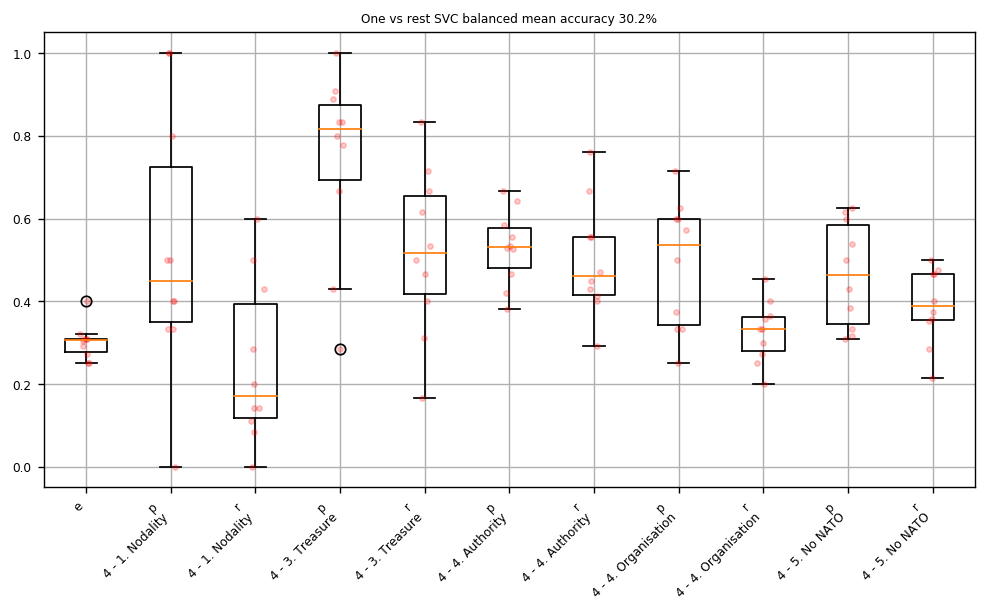

In [46]:
#All in one go example for NATO top level

#Add none column for relevant docs without any NATO categories

classes  = ['4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation',]

#Add none column for relevant docs without any NATO categories
df["4 - 5. No NATO"]=0
df.loc[(df['relevant'] == 1) & (df[classes].sum(axis=1) ==0), "4 - 5. No NATO"] = 1
df[df['relevant'] ==1].head(10)

classes  = ['4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation', "4 - 5. No NATO"]

print("seen documents:",df.loc[df['seen']==1,].shape[0])
for c in classes: 
    print(f"Number of {c.split('. ')[-1]} documents:", df.loc[df['seen']==1,c].sum())


y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)

fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

In [43]:
#With better formatting and the overall relevance included in one graph

boxplotdf = pd.DataFrame()
boxplotdf['Category'] = descriptives
gendf = pd.DataFrame({'Category' : ['e\n1 - Relevance', 'p\n1 - Relevance', 'r\n1 - Relevance']})

#get scores as list
boxplotdf['Scores'] = [multimodels[0][des] for des in boxplotdf['Category']]
gendf['Scores'] = [models[len(models)-1][des] for des in ['e', 'p', 'r']]

#merge the general and the multi-model
boxplotdf = pd.concat([gendf, boxplotdf], axis=0, ignore_index=True).reset_index()

#make a new row for each in list (basically: unfold the list to new variable, add new variable as column & drop old column)
s = boxplotdf.apply(lambda x: pd.Series(x['Scores']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Scores'
boxplotdf = boxplotdf.drop('Scores', axis=1).join(s)

#Get the category and the metric separately
new = boxplotdf["Category"].str.split("\n1 - ", n = 1, expand = True)
boxplotdf["Metric"]= new[0]
boxplotdf.drop(columns =["Category"], inplace = True) 
boxplotdf["Category"]= new[1] 

#rename
di = {'e': "Accuracy",
      'p': "Precision",
      'r': "Recall"}
boxplotdf.replace({"Metric": di}, inplace=True)

#plot 
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6),dpi=150)
ax = sns.boxplot(x="Category", y="Scores", hue="Metric",
                 data=boxplotdf, palette="Set2", linewidth = 2)

ax = sns.swarmplot(x="Category", y="Scores", hue="Metric", dodge=True, #add points
                   data=boxplotdf, color="grey", alpha = 0.75, size=4
                  ) 


ax.set_ylabel('Score', fontsize = 10, weight = 'bold')
ax.set_xlabel('Classifier', fontsize = 10, weight = 'bold')

title = 'Performance of Category Classifier '
subtitle = 'Accuracy, precision and recall per classifier for 10 k-fold cross-validation'
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=subtitle, fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
#l = plt.legend()
ax.legend(handles[0:3], labels[0:3],
          fontsize=10, title_fontsize='10', loc = 'lower left',
          facecolor = 'white', edgecolor='grey')


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'{title}_{subtitle}.png')


KeyError: 'e\n1 - Mitigation'

In [40]:
for des in descriptives: 
    print(f'{des} - - {statistics.mean(multimodels[0][des])}')
    print()
    
print ('- - - - - ')
for des in ['e', 'p', 'r']:
    print(f'{des} - - {statistics.mean(multimodels[0][des])}')
    print()
    
statistics.mean(multimodels[0]['r\n1 - Impact'])

KeyError: 'e\n1 - Mitigation'

In [ ]:
boxplotdf = pd.DataFrame()
boxplotdf['Category'] = descriptives
gendf = pd.DataFrame({'Category' : ['e\n1 - Relevance', 'p\n1 - Relevance', 'r\n1 - Relevance']})

#get scores as list
boxplotdf['Scores'] = [multimodels[0][des] for des in boxplotdf['Category']]
gendf['Scores'] = [models[0][des] for des in ['e', 'p', 'r']]

#merge the general and the multi-model
boxplotdf = pd.concat([gendf, boxplotdf], axis=0, ignore_index = True)

#make a new row for each in list (basically: unfold the list to new variable, add new variable as column & drop old column)
s = boxplotdf.apply(lambda x: pd.Series(x['Scores']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Scores'
boxplotdf = boxplotdf.drop('Scores', axis=1).join(s)

boxplotdf

In [ ]:
df.columns

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, ab_X[seen_index],y[seen_index], cv=5, scoring='recall_samples')

In [96]:
y


matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Multi-matrix

In [47]:
def multimatrix(classes, cols, df=df, norm=True, seen_index=seen_index):
    y_pred = np.array(list(df.loc[seen_index,cols].values))
    y = np.matrix(df[classes])
    y_true = y[seen_index]

    confusion_matrix = np.zeros(shape=(len(classes)+1,len(classes)+1),dtype=float)

    #Calculate for each cell if they match
    for j, c in enumerate(classes): #rows
        for k, c in enumerate(classes): #cols
            n = 0
            for i in range(len(seen_index)):
                if j==k:
                    if y_true[i,j]+y_pred[i,k]==2:
                        n+=1
                else:
                    if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                        n+=1/y_pred[i,].sum()
            confusion_matrix[j,k]=n

        sums_pred = y_pred.sum(axis=1).ravel()
        confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
        sums_true = y_true.sum(axis=1).ravel()
        confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
        confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


    if norm is not False:
        confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)


    #Start plotting
    fig, ax = plt.subplots(dpi=125, figsize=(8,8))
    if norm is not False:
        mat = ax.imshow(confusion_matrix, cmap="Blues", vmin=0, vmax=np.nanmax(confusion_matrix), origin="lower")
    else:
        mat = ax.imshow(confusion_matrix, cmap="Blues",origin="lower")

    yclasses = classes + ["None predicted"]
    for j, c in enumerate(yclasses):
        for k, c in enumerate(classes):
            n  = confusion_matrix[j,k]
            if n > np.nanmax(confusion_matrix)/2:
                color="#e8dcdc"
            else:
                color="#403d3d"
            if norm is not False:
                ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
            else:
                ax.text(k,j, f"{confusion_matrix[j,k]:.1f}",ha="center",color=color)

        if j < len(yclasses)-1:
            #Add number of samples at the end
            ax.text(j,len(yclasses)-0.25,f"{np.nansum(y_true[:,j]):,.0f}",ha="center",va="center")
            ax.text(len(classes)-0.25, j, f"{np.nansum(y_pred[:,j]):,.0f}",ha="center",va="center")


    ax.set_xticks(list(range(len(classes)))) 
    ax.set_xticklabels([x.split(". ")[-1] for x in classes],rotation=45,ha="right")


    ax.set_yticks(list(range(len(yclasses))))
    ax.set_yticklabels([x.split(". ")[-1] for x in yclasses],ha="right")
    ax.set_xlabel("True value", fontsize = 10, weight = 'bold')
    ax.set_ylabel("Predicted value", fontsize = 10, weight = 'bold')

    ax.set_xlim(right=len(classes)-0.5)

    cbar = fig.colorbar(mat, ax=ax, pad=0.15, shrink = 0.5)
    if norm is not False:
        cbar.set_label("% of True values")

    title = "Confusion matrix for predicted categories"
    ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

    fig.tight_layout(rect=[0, 0, 1, 0.98])
    
    return(fig, ax)

['4 - 1. Nodality - k_prediction_binary', '4 - 3. Treasure - k_prediction_binary', '4 - 4. Authority - k_prediction_binary', '4 - 4. Organisation - k_prediction_binary', '4 - 5. No NATO - k_prediction_binary']


<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

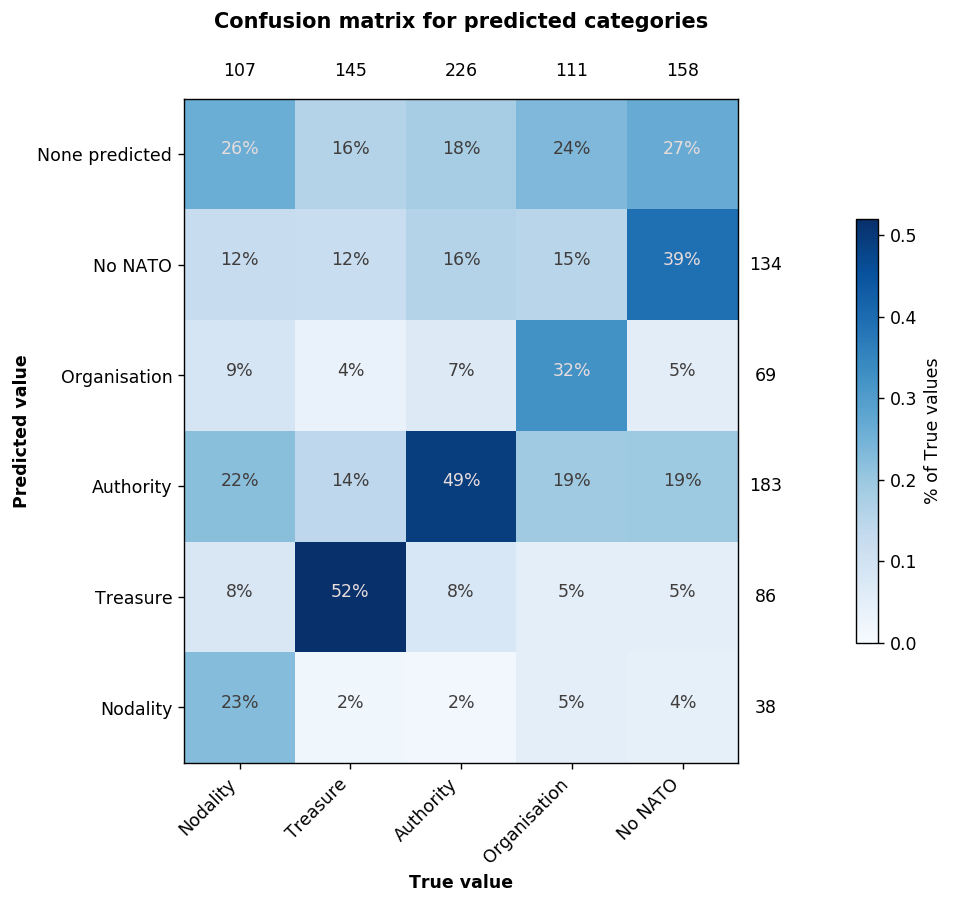

In [48]:
import seaborn as sns
sns.reset_defaults()
classes  = ['4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation', "4 - 5. No NATO"]
cols = [f"{c} - k_prediction_binary" for c in classes]
print(cols)

fig, ax = multimatrix(classes, cols, df=df,  norm=True)

fig.show

<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

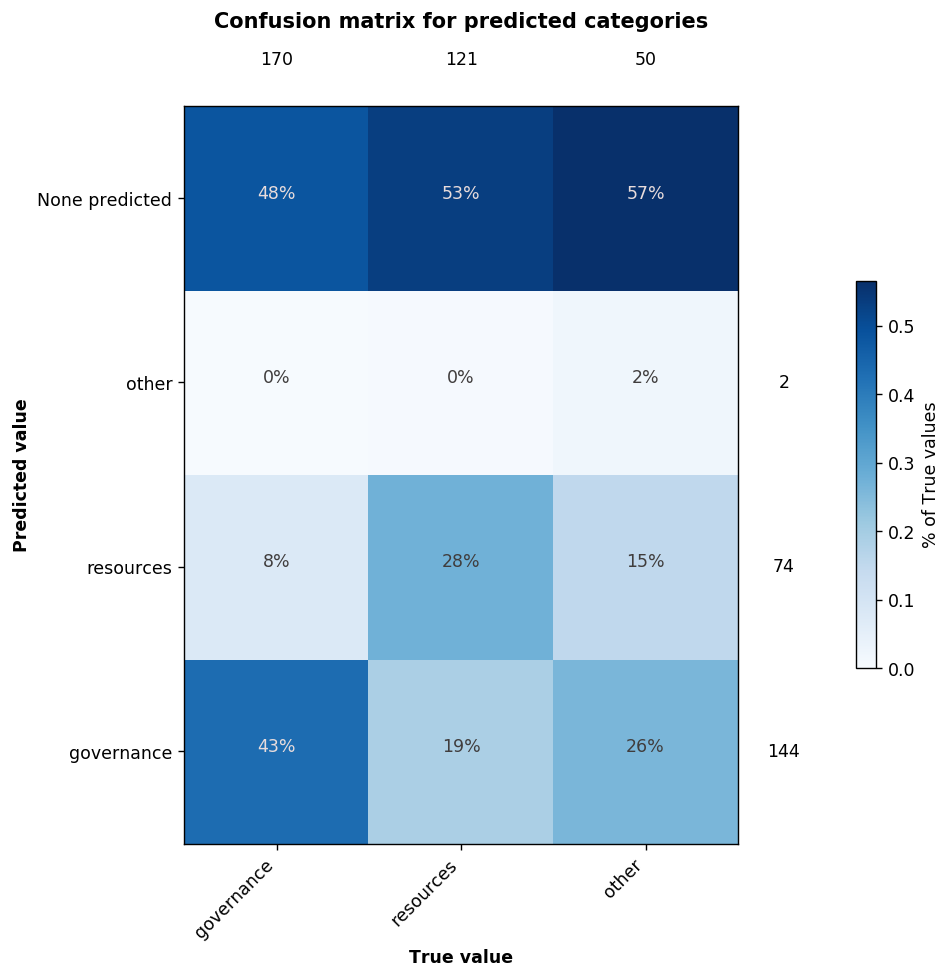

In [49]:
classes  = ['governance', 'resources', 'other']
cols = [f"{c} - k_prediction_binary" for c in classes]

fig, ax = multimatrix(classes, cols, df=df,  norm=True)

fig.show

<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

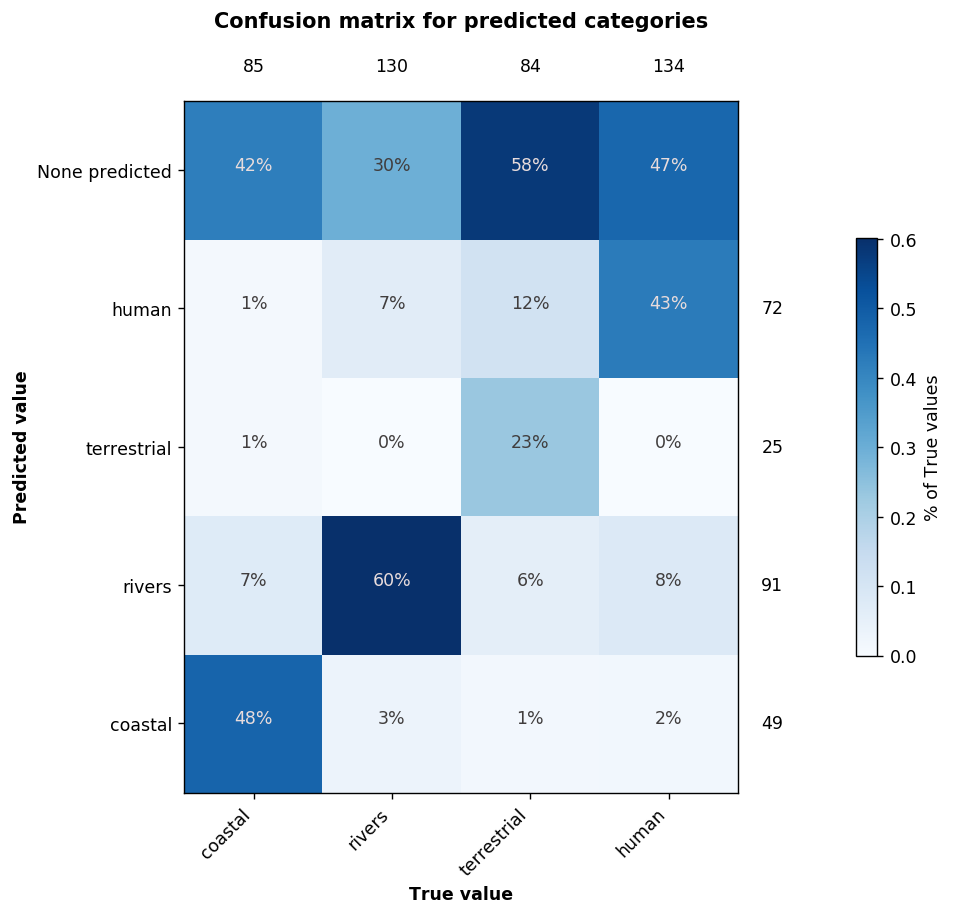

In [50]:
classes  = ['coastal', 'rivers', 'terrestrial', 'human'] 
cols = [f"{c} - k_prediction_binary" for c in classes]

fig, ax = multimatrix(classes, cols, df=df,  norm=True)

fig.show

<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

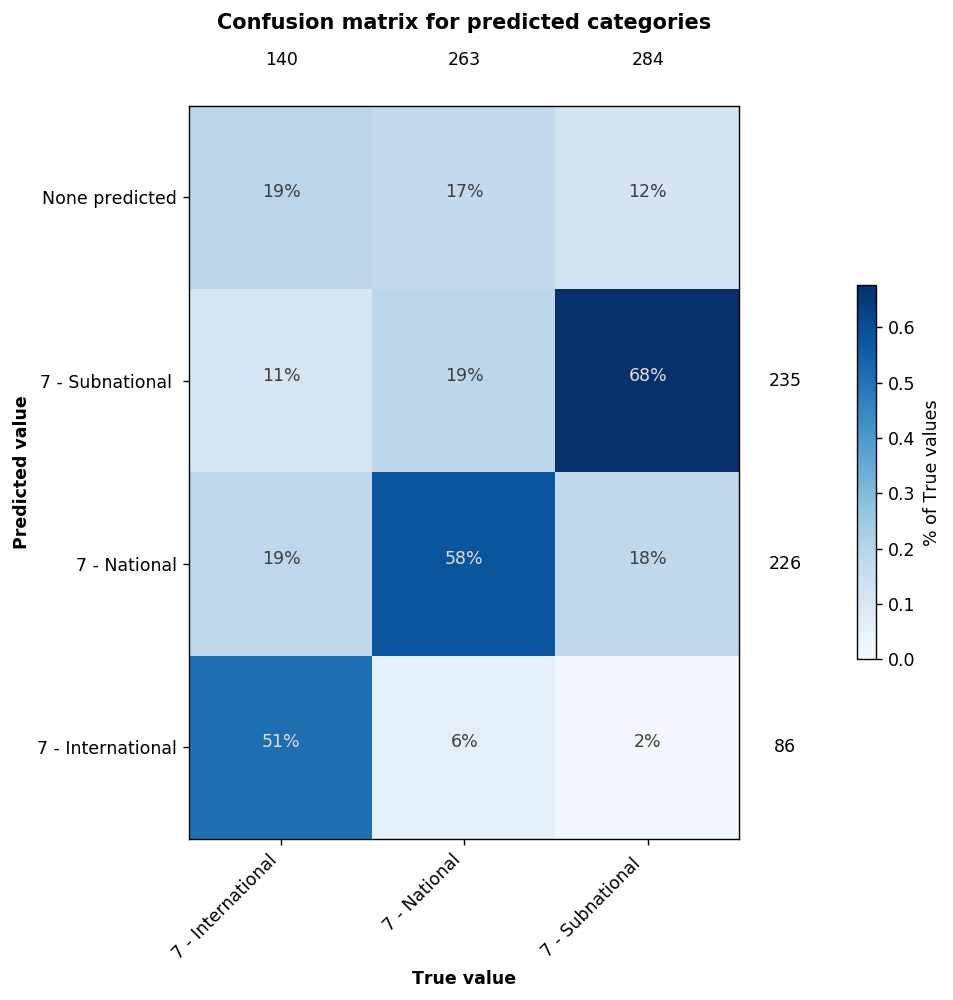

In [51]:
classes  = ['7 - International', '7 - National', '7 - Subnational ',]

cols = [f"{c} - k_prediction_binary" for c in classes]

fig, ax = multimatrix(classes, cols, df=df,  norm=True)

fig.show

In [52]:
model_df = pd.DataFrame(multimodels)
model_df.to_csv(f"predictions/{now}_multimodels.csv",index=False)

### Fitting multi-class

In [ ]:
predicted_index = df[df['0 - relevance - prediction']>0.33].index
LabeledRelevant_index = df[df['relevant']==1].index

clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
classes = ["1 - Mitigation","1 - Adaptation", "1 - Impact"]
y = np.matrix(df[classes])
y.shape

clf.fit(ab_X[seen_index],y[seen_index]) #fit on the labeled as relevant data
predictions = clf.predict_proba(ab_X[predicted_index]) #get probability scores for those predicted to be relevant
binary = clf.predict(ab_X[predicted_index]) #get binary scores too

In [ ]:
#Add predictions to the dataframe or nan if no prediction
for i,c in enumerate(classes):
    df[f"{c} - prediction"] = np.NaN
    
    df.loc[predicted_index, f"{c} - prediction"] = predictions[:, i]

In [ ]:
#Check
print(df[df['1 - Adaptation - prediction'] > .1].shape)
df[df['1 - Adaptation - prediction'] > .1].head(20)

### False positives & Negatives
First, let's look into the high number of adaptation docs being classified as impact

In [ ]:
#Just because I got tired of getting the titles confused, import markdown display
from IPython.display import Markdown, display
def printmd(string): 
    display(Markdown(string))
    
confusion = df[
   (df['1 - Adaptation'] == 1) 
   & (df['1 - Adaptation - k_prediction_binary'] == 0) 
   & (df['1 - Impact - k_prediction_binary'] == 1)
    ]

for i, row in confusion.sort_values('1 - Impact - k_prediction',ascending=False).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    printmd(f"**{row['title']}**")
    print(row['content'])
    #print(row['id'])
    printmd(f"*Impact prediction: {row['1 - Impact - k_prediction']} -- Adaptation prediction: {row['1 - Adaptation - k_prediction']}*" )
    #print(d.docownership_set.filter(query=qid).values('user__username','relevant','finish','tag__title'))

In [ ]:
#Listing all false positives and false negatives
#NB: this includes docs belonging to multiple classes where only one was classified wrongly
classes_pred = [(c, c+" - k_prediction_binary") for c in classes[0:-1]]

c_fp = pd.DataFrame(columns = df.columns)
c_fn = pd.DataFrame(columns = df.columns)

for c, c_p in classes_pred:
    c_fn = c_fn.append(df[(df[c]==1) & (df[c_p]==0)])
    c_fp = c_fp.append(df[(df[c]==0) & (df[c_p]==1)])
    
print(f"False negatives: {c_fn.shape[0]} \nFalse positives: {c_fp.shape[0]}")

In [ ]:
df['categories'] = df['1 - Mitigation'] + df['1 - Adaptation'] + df['1 - Impact']
print(f"Total categorised: {df.loc[df['categories']>=1].shape[0]}")

In [ ]:
#create a tag so I can check them out on the platform
tempq = merged_query

tag, created = Tag.objects.get_or_create(
    title=f"Categories f neg {now}".format(now),
    query=tempq
)
tag.save()

for i, row in c_fn.iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [ ]:
#same for false positives
tag, created = Tag.objects.get_or_create(
    title=f"Categories f pos {now}".format(now),
    query=tempq
)
tag.save()

for i, row in c_fp.iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

#### To CSV

In [ ]:
columns = ['1 - Adaptation', '1 - Mitigation', '1 - Impact' ]
ycols = [col + ' - k_prediction' for col in columns]
pcols = [col + ' - prediction' for col in columns]
outdf = df[['id', 'relevant', 'seen']]
outdf[ycols] = df[ycols]
outdf[pcols] = df[pcols]
outdf.head()

In [ ]:
#writing a smaller DF with just the IDs, human-made labels, and machine prediction
#outdf = df[['id', 'relevant', 'seen', '0 - relevance - prediction']]
outdf.loc[outdf['seen'] ==0, 'relevant'] = None
for n, ycol in enumerate(ycols):
    outdf[ycol] = np.where(outdf['seen'] == 1, outdf[ycol], outdf[pcols[n]])
       
outdf = outdf.rename(columns={
    'relevant': 'label',
    '1 - Impact - k_prediction': 'impact',
    '1 - Adaptation - k_prediction': 'adaptation',
    '1 - Mitigation - k_prediction': 'mitigation'
})

outdf = outdf[['id', 'label', 'adaptation', 'mitigation', 'impact']].dropna(thresh=5)

outdf.to_csv(f'IdCategoryPrediction.csv', index=False)
outdf.head()

In [ ]:
outdf.shape

In [ ]:
outdf.to_csv(f'IdCategoryPrediction.csv', index=False)
outdf.shape

## A look at the BERT outcomes

In [133]:
cdf = pd.read_csv(r'data/finalDf_bothAndLvl.csv', encoding='UTF-8')
#Scores have _x for predictions made without the documents from other projects and _y for those with those docs
#Governance level got stuck in a local optimum so war ran again, suffix _z
print(cdf.columns)
cdf = cdf[(cdf['relevant_high'] == 1) | (cdf['relevant'] == 1) ]
print(cdf.shape)
cdf.head()

Index(['id', 'content', 'title', 'relevant', 'seen', 'random',
       '2 - Adaptation', '2 - Mitigation', '2 - Other', '4 - 1. Nodality',
       '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation',
       '7 - International', '7 - National', '7 - Subnational ', '8 - Coastal',
       '8 - Rivers', '8 - Terrestrial', '8 - Human', '9 - Ex-ante',
       '9 - Ex-post', 'y_k_prediction_SVM-rbf', '0 - relevance - prediction',
       'text', 'labels', 'exclude_score', 'include_score', 'relevant_high',
       '2 - Adaptation_pred_x', '2 - Mitigation_pred_x', '2 - Other_pred_x',
       '4 - 1. Nodality_pred_x', '4 - 3. Treasure_pred_x',
       '4 - 4. Authority_pred_x', '4 - 4. Organisation_pred_x',
       '7 - International_pred_x', '7 - National_pred_x',
       '7 - Subnational _pred_x', '8 - Coastal_pred_x', '8 - Rivers_pred_x',
       '8 - Terrestrial_pred_x', '8 - Human_pred_x', '9 - Ex-ante_pred_x',
       '9 - Ex-post_pred_x', '2 - Adaptation_pred_y', '2 - Mitigation_pred_y',
   

,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,4 - 1. Nodality,...,7 - Subnational _pred_y,8 - Coastal_pred_y,8 - Rivers_pred_y,8 - Terrestrial_pred_y,8 - Human_pred_y,9 - Ex-ante_pred_y,9 - Ex-post_pred_y,7 - International_pred_z,7 - National_pred_z,7 - Subnational _pred_z
0,505468,A large number of small- to medium-sized commu...,Community pond rehabilitation to deal with cli...,NaN,NaN,NaN,0,0,0,0,...,0.089521,0.009210,0.563965,0.044284,0.037773,0.619294,0.936461,0.013613,0.022471,0.961818
1,3286707,The purpose of this paper is to demonstrate th...,Vulnerability to global environmental changes:...,NaN,NaN,NaN,0,0,0,0,...,0.060196,0.002654,0.002554,0.001832,0.005508,0.003031,0.012849,0.001559,0.017716,0.100522
2,1962940,The issue of climate change has shed a new lig...,Migratory issues in climate adaptation policie...,NaN,NaN,NaN,0,0,0,0,...,0.271336,0.004293,0.002899,0.003895,0.078200,0.006712,0.995119,0.053642,0.857579,0.003639
3,1047270,(1) As on-the-ground projects come into existe...,Women's Empowerment and Climate Change Adaptat...,NaN,NaN,NaN,0,0,0,0,...,0.271515,0.003063,0.001947,0.002233,0.005309,0.002465,0.052423,0.007457,0.016662,0.070956
4,770190,Small rural coastal communities located in Atl...,Climatic and Environmental Changes Affecting C...,NaN,NaN,NaN,0,0,0,0,...,0.148760,0.991254,0.088781,0.048947,0.070579,0.008394,0.801332,0.002592,0.009204,0.564695


In [120]:
classes_pred = ['2 - Adaptation_pred', '2 - Mitigation_pred', '2 - Other_pred',
       '4 - 1. Nodality_pred', '4 - 3. Treasure_pred', '4 - 4. Authority_pred',
       '4 - 4. Organisation_pred', '7 - International_pred',
       '7 - National_pred', '7 - Subnational _pred', 
        '8 - Coastal_pred', '8 - Rivers_pred', '8 - Terrestrial_pred', '8 - Human_pred',
       '9 - Ex-ante_pred','9 - Ex-post_pred',]
clist = []
for c in classes_pred:
    clist.append(cdf[cdf[f"{c}_y"] >0.5].shape[0])
    print(f"{cdf[cdf[f'{c}_x'] >0.5].shape[0]:04d} vs ",
          f"{cdf[cdf[f'{c}_y'] >0.5].shape[0]:04d} without and with documents from other projects ", 
          f"for {c.split('-', maxsplit=1)[1].split('_pred')[0]}")
print("Governance level re-do:")
for c in ['7 - International_pred', '7 - National_pred', '7 - Subnational _pred']:          
    print(f"{cdf[cdf[f'{c}_z'] >0.5].shape[0]:04d} for {c.split('-', maxsplit=1)[1].split('_pred')[0]}")

3543 vs  3485 without and with documents from other projects  for  Adaptation
0925 vs  0706 without and with documents from other projects  for  Mitigation
1458 vs  0774 without and with documents from other projects  for  Other
0511 vs  0198 without and with documents from other projects  for  1. Nodality
0831 vs  0362 without and with documents from other projects  for  3. Treasure
0763 vs  0736 without and with documents from other projects  for  4. Authority
0866 vs  0094 without and with documents from other projects  for  4. Organisation
0495 vs  1010 without and with documents from other projects  for  International
0348 vs  0027 without and with documents from other projects  for  National
2000 vs  0000 without and with documents from other projects  for  Subnational 
0554 vs  0494 without and with documents from other projects  for  Coastal
1076 vs  1006 without and with documents from other projects  for  Rivers
0384 vs  0450 without and with documents from other projects  fo

In [60]:
#Calculate average difference
for c in classes_pred: 
    dif = cdf[f'{c}_x'] - cdf[f'{c}_y']
    print(f"{dif.mean():+.2} average difference for {c.split('-', maxsplit=1)[1].split('_pred')[0]}")

+0.013 average difference for  Adaptation
+0.033 average difference for  Mitigation
+0.13 average difference for  Other
-0.048 average difference for  1. Nodality
+0.017 average difference for  3. Treasure
-0.082 average difference for  4. Authority
+0.022 average difference for  4. Organisation
-0.13 average difference for  International
+0.039 average difference for  National
+0.15 average difference for  Subnational 
+0.014 average difference for  Coastal
+0.015 average difference for  Rivers
+0.0086 average difference for  Terrestrial
+0.032 average difference for  Human
+0.056 average difference for  Ex-ante
-0.23 average difference for  Ex-post


In [134]:
#Extra labels seems to make a real difference for Ex-ante and Ex-post
#Makes sense also b/c ex-ante only had 77 positive examples (one of the lowest numbers)
#And the re-do for governance level seems to have worked

renameSelected = {f"{c}_x": f"{c.split('_')[0]}_pred" for c in classes_pred if not (c.startswith('9') or c.startswith('7') or c.startswith('2'))}
renameSelected['9 - Ex-ante_pred_y'] = '9 - Ex-ante_pred'
renameSelected['9 - Ex-post_pred_y'] = '9 - Ex-post_pred'
renameSelected['7 - International_pred_z'] = '7 - International_pred'
renameSelected['7 - National_pred_z'] = '7 - National_pred'
renameSelected['7 - Subnational _pred_z'] = '7 - Subnational _pred'
renameSelected['2 - Adaptation_pred_y'] = '2 - Adaptation_pred'
renameSelected['2 - Mitigation_pred_y'] = '2 - Mitigation_pred'
renameSelected['2 - Other_pred_y'] = '2 - Other_pred'
          
cdf.rename(columns = renameSelected, inplace=True)

cdf.columns

Index(['id', 'content', 'title', 'relevant', 'seen', 'random',
       '2 - Adaptation', '2 - Mitigation', '2 - Other', '4 - 1. Nodality',
       '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation',
       '7 - International', '7 - National', '7 - Subnational ', '8 - Coastal',
       '8 - Rivers', '8 - Terrestrial', '8 - Human', '9 - Ex-ante',
       '9 - Ex-post', 'y_k_prediction_SVM-rbf', '0 - relevance - prediction',
       'text', 'labels', 'exclude_score', 'include_score', 'relevant_high',
       '2 - Adaptation_pred_x', '2 - Mitigation_pred_x', '2 - Other_pred_x',
       '4 - 1. Nodality_pred', '4 - 3. Treasure_pred', '4 - 4. Authority_pred',
       '4 - 4. Organisation_pred', '7 - International_pred_x',
       '7 - National_pred_x', '7 - Subnational _pred_x', '8 - Coastal_pred',
       '8 - Rivers_pred', '8 - Terrestrial_pred', '8 - Human_pred',
       '9 - Ex-ante_pred_x', '9 - Ex-post_pred_x', '2 - Adaptation_pred',
       '2 - Mitigation_pred', '2 - Other_pred', '4 - 

In [132]:
renameSelected

{'2 - Adaptation_pred_x': '2 - Adaptation_pred',
 '2 - Mitigation_pred_x': '2 - Mitigation_pred',
 '2 - Other_pred_x': '2 - Other_pred',
 '4 - 1. Nodality_pred_x': '4 - 1. Nodality_pred',
 '4 - 3. Treasure_pred_x': '4 - 3. Treasure_pred',
 '4 - 4. Authority_pred_x': '4 - 4. Authority_pred',
 '4 - 4. Organisation_pred_x': '4 - 4. Organisation_pred',
 '7 - International_pred_z': '7 - International_pred',
 '7 - National_pred_z': '7 - National_pred',
 '7 - Subnational _pred_z': '7 - Subnational _pred',
 '8 - Coastal_pred_x': '8 - Coastal_pred',
 '8 - Human_pred_x': '8 - Human_pred',
 '8 - Rivers_pred_x': '8 - Rivers_pred',
 '8 - Terrestrial_pred_x': '8 - Terrestrial_pred',
 '9 - Ex-ante_pred_y': '9 - Ex-ante_pred',
 '9 - Ex-post_pred_y': '9 - Ex-post_pred'}

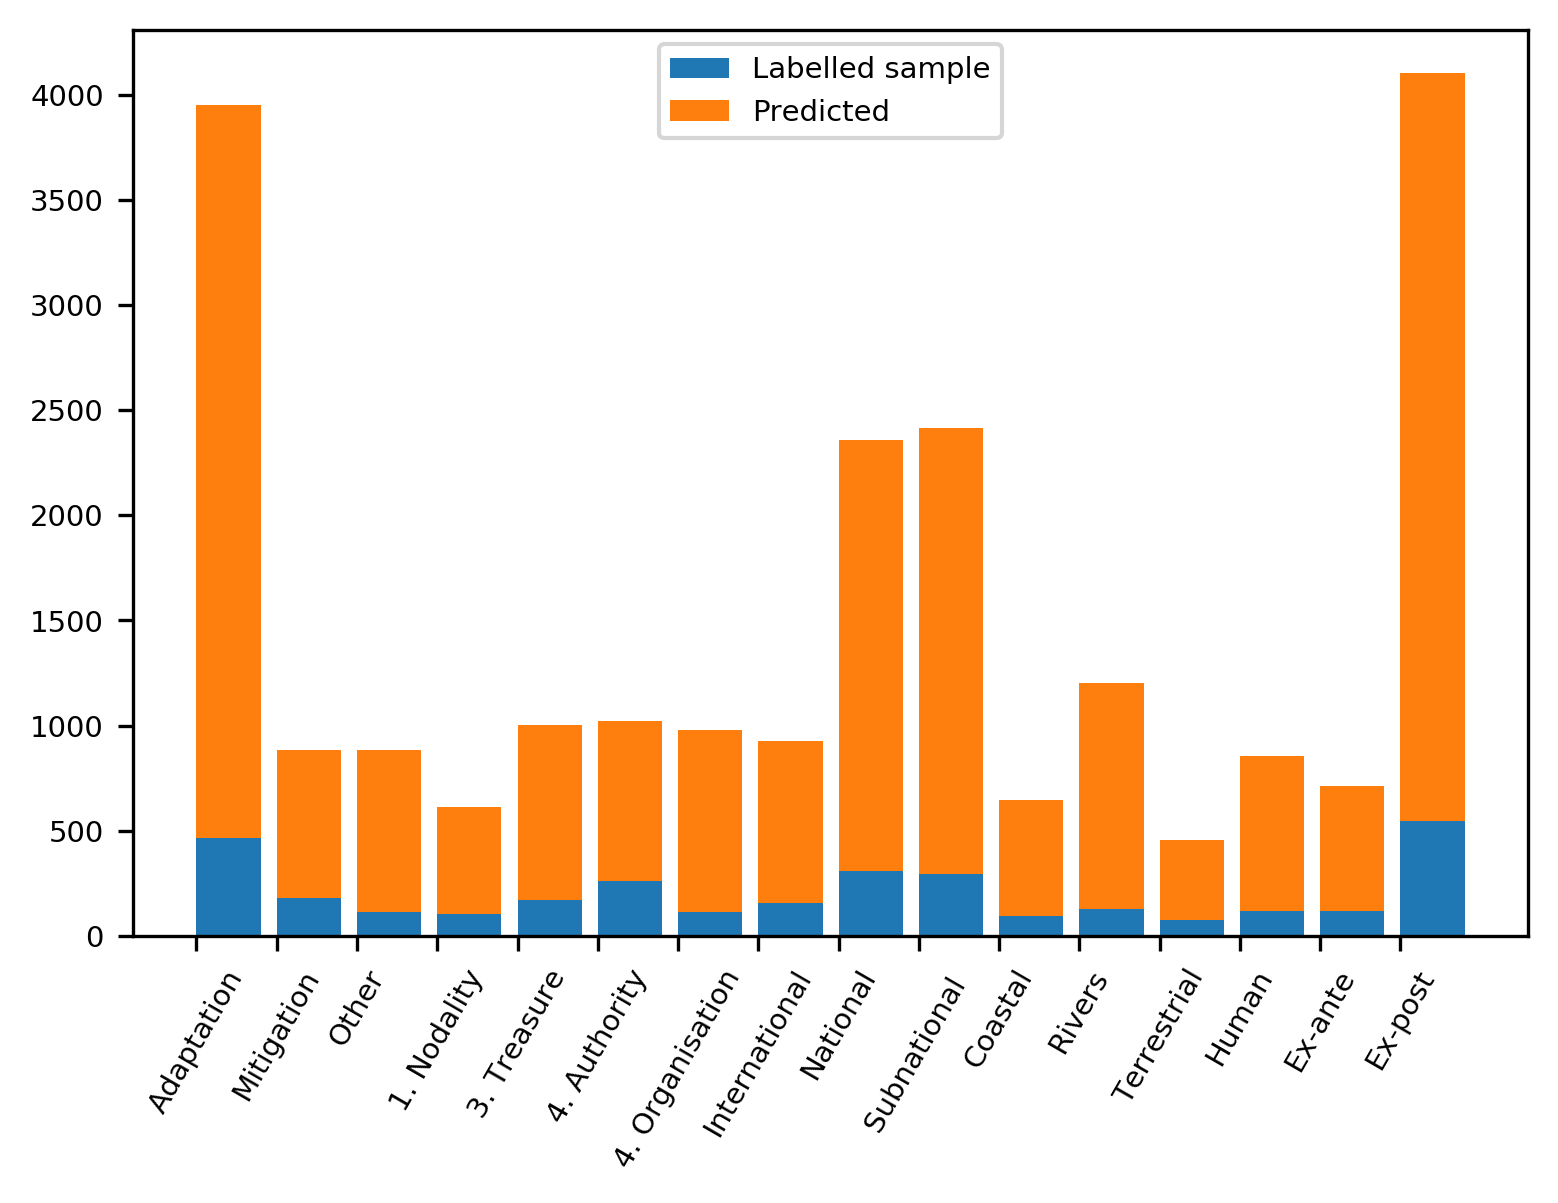

In [135]:
#Plot as bar chart
cvalues = [cdf[cdf[c] >0.5].shape[0] for c in classes_pred] #Predicted
labelCols = [c.split("_pred")[0] for c in classes_pred]
lvalues = [cdf[cdf[c] >0.5].shape[0] for c in labelCols] #Labelled
cnames = [c.split('- ', maxsplit=1)[1] for c in labelCols]
fig, ax = plt.subplots(dpi=300)
plt.bar(x = cnames, height = lvalues, align='edge', label='Labelled sample')
plt.bar(x = cnames, height = cvalues, align='edge', label = 'Predicted',  bottom=lvalues)
plt.xticks(rotation=60)
plt.legend()
fig.patch.set_facecolor("white")
plt.show()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


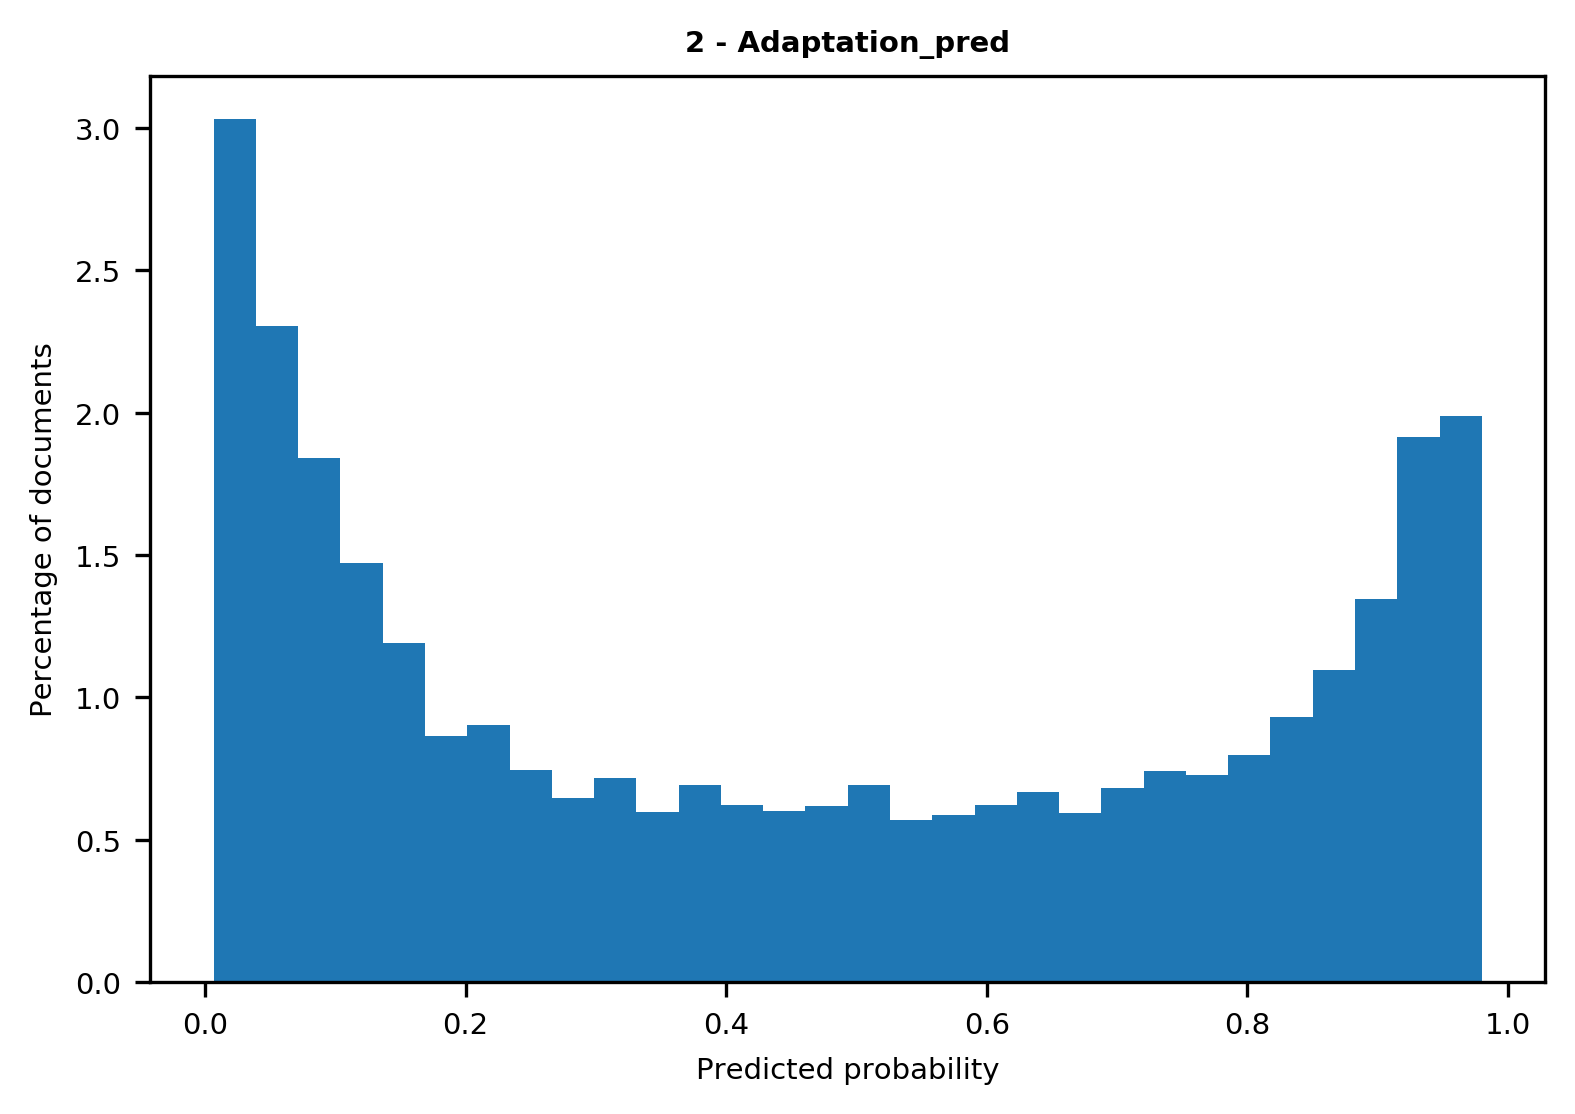

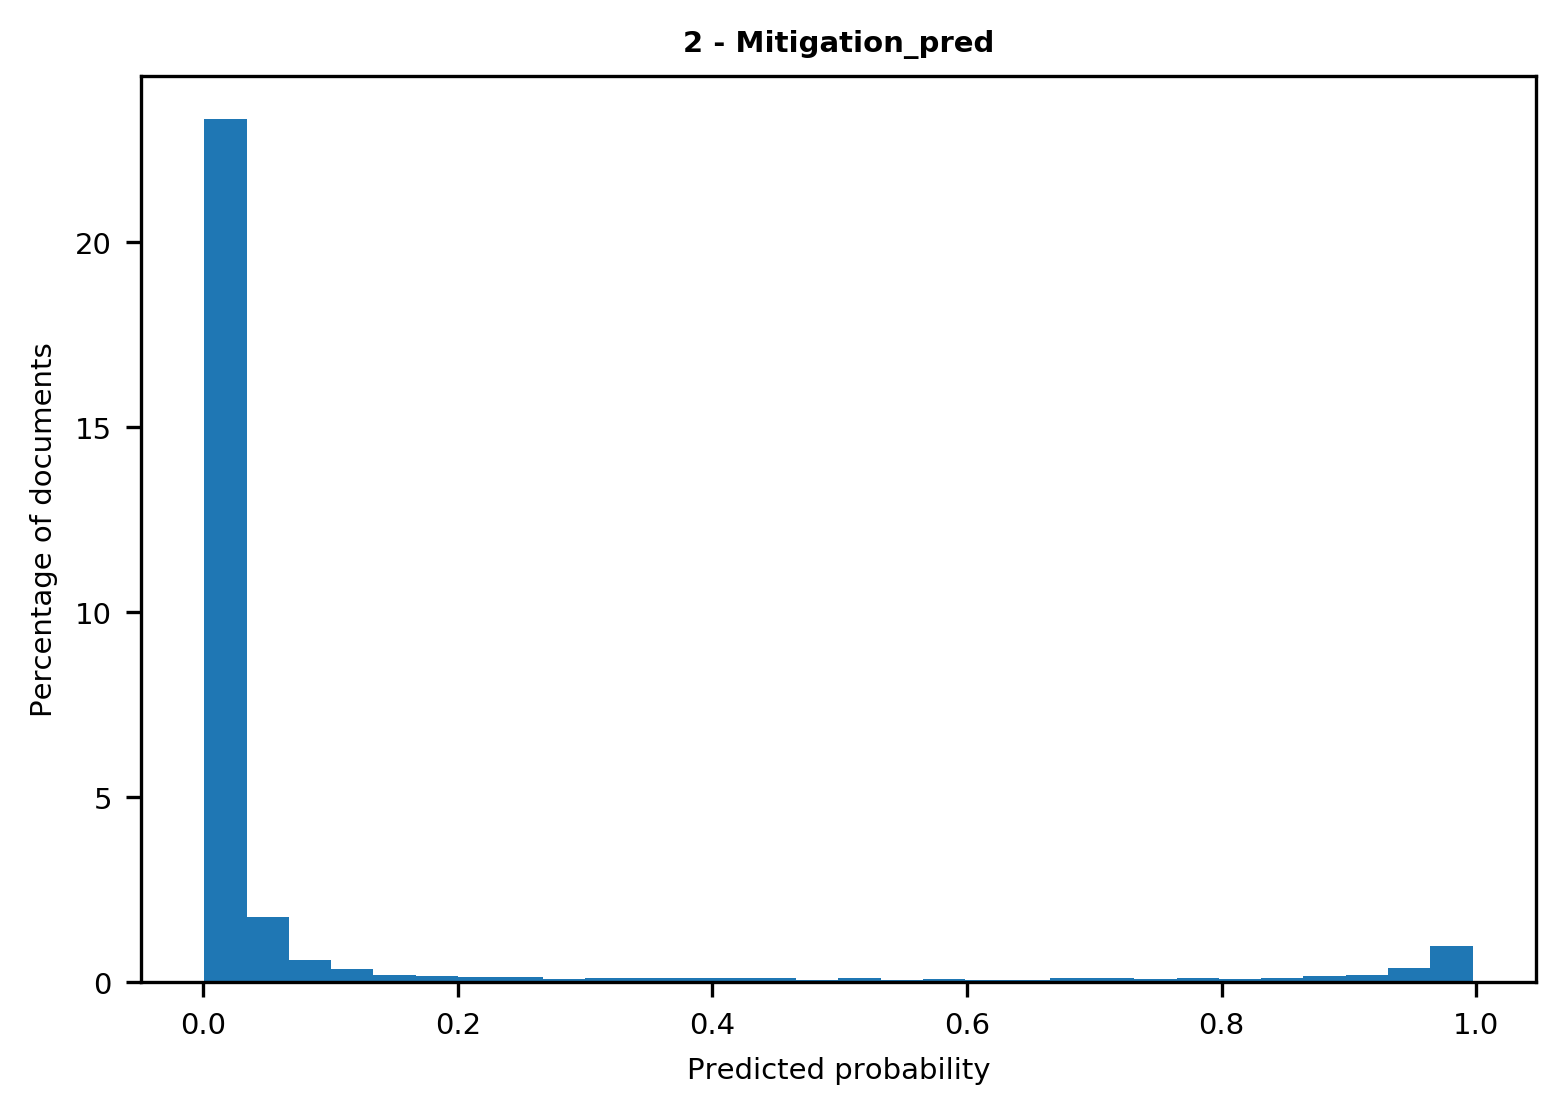

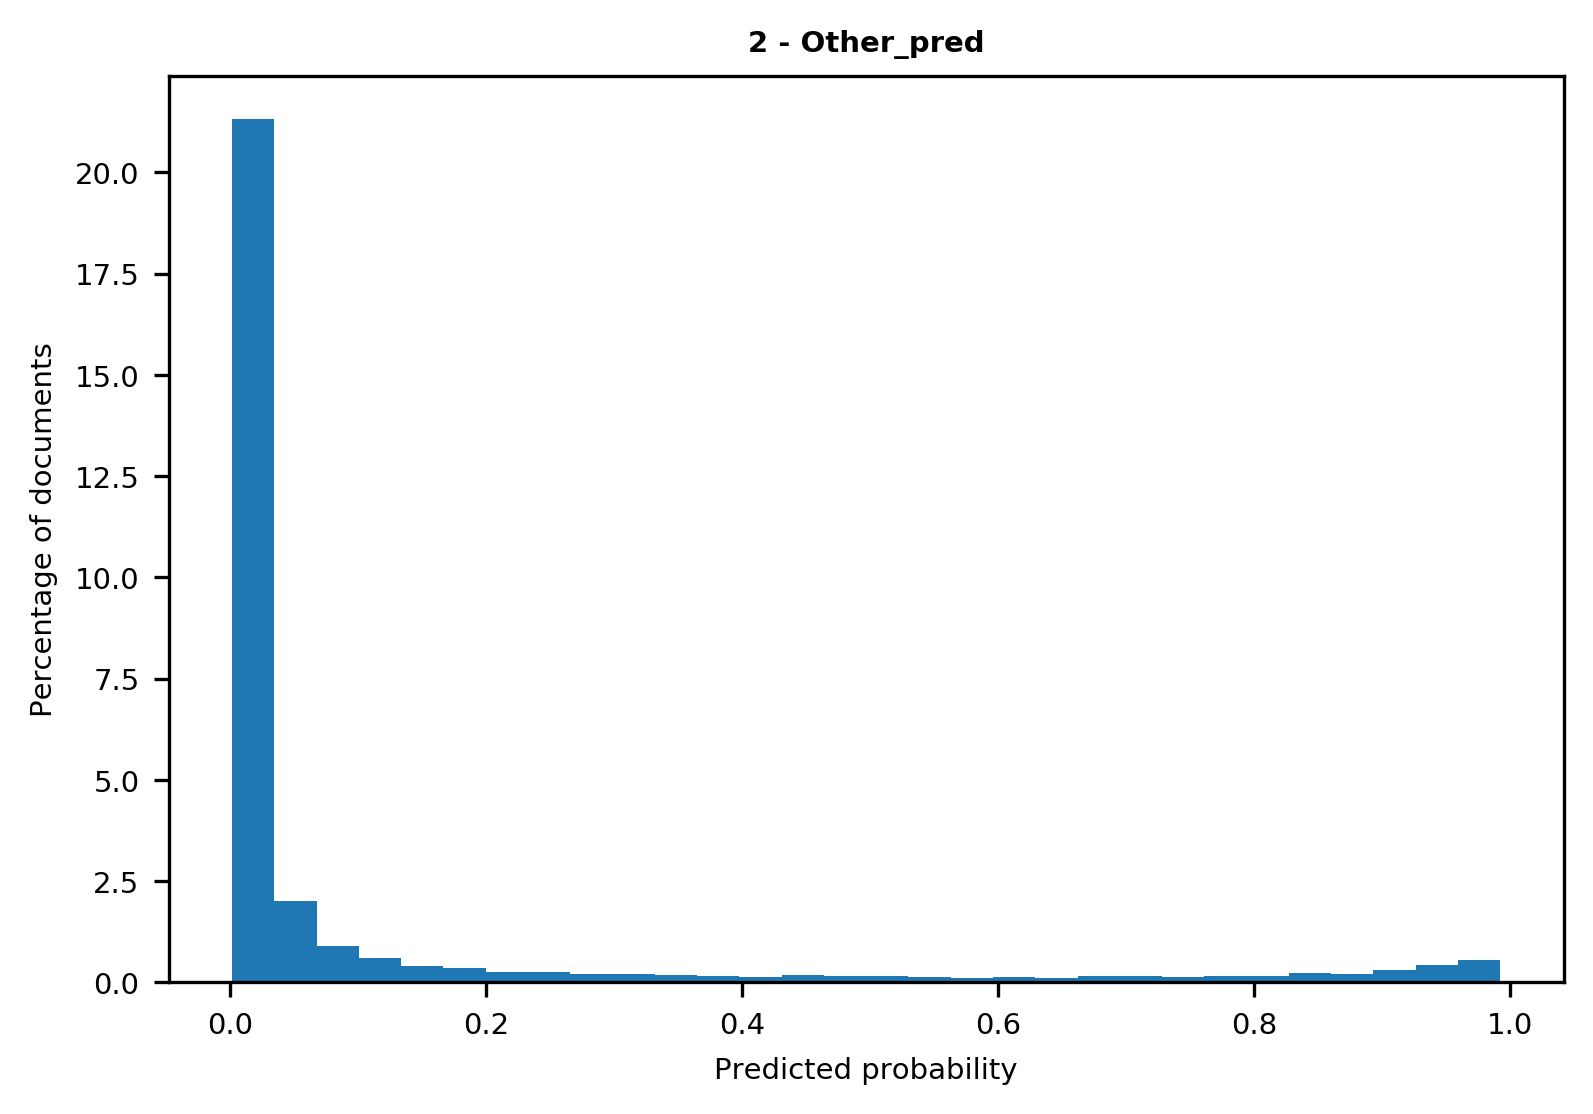

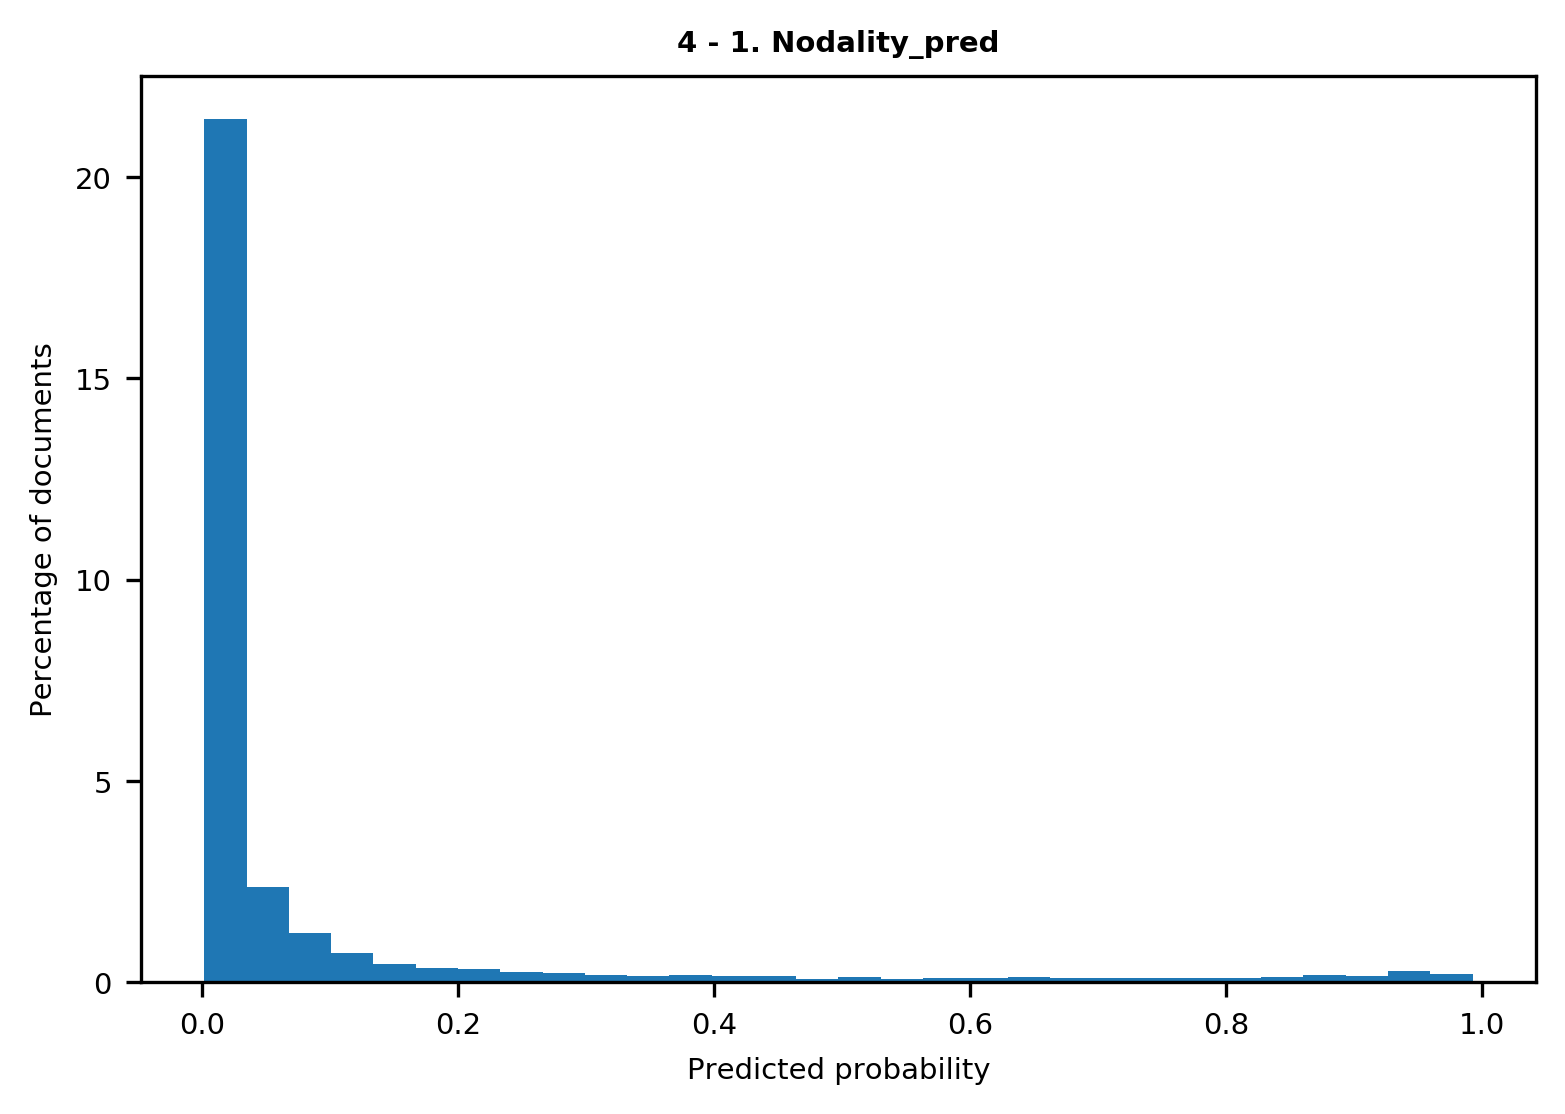

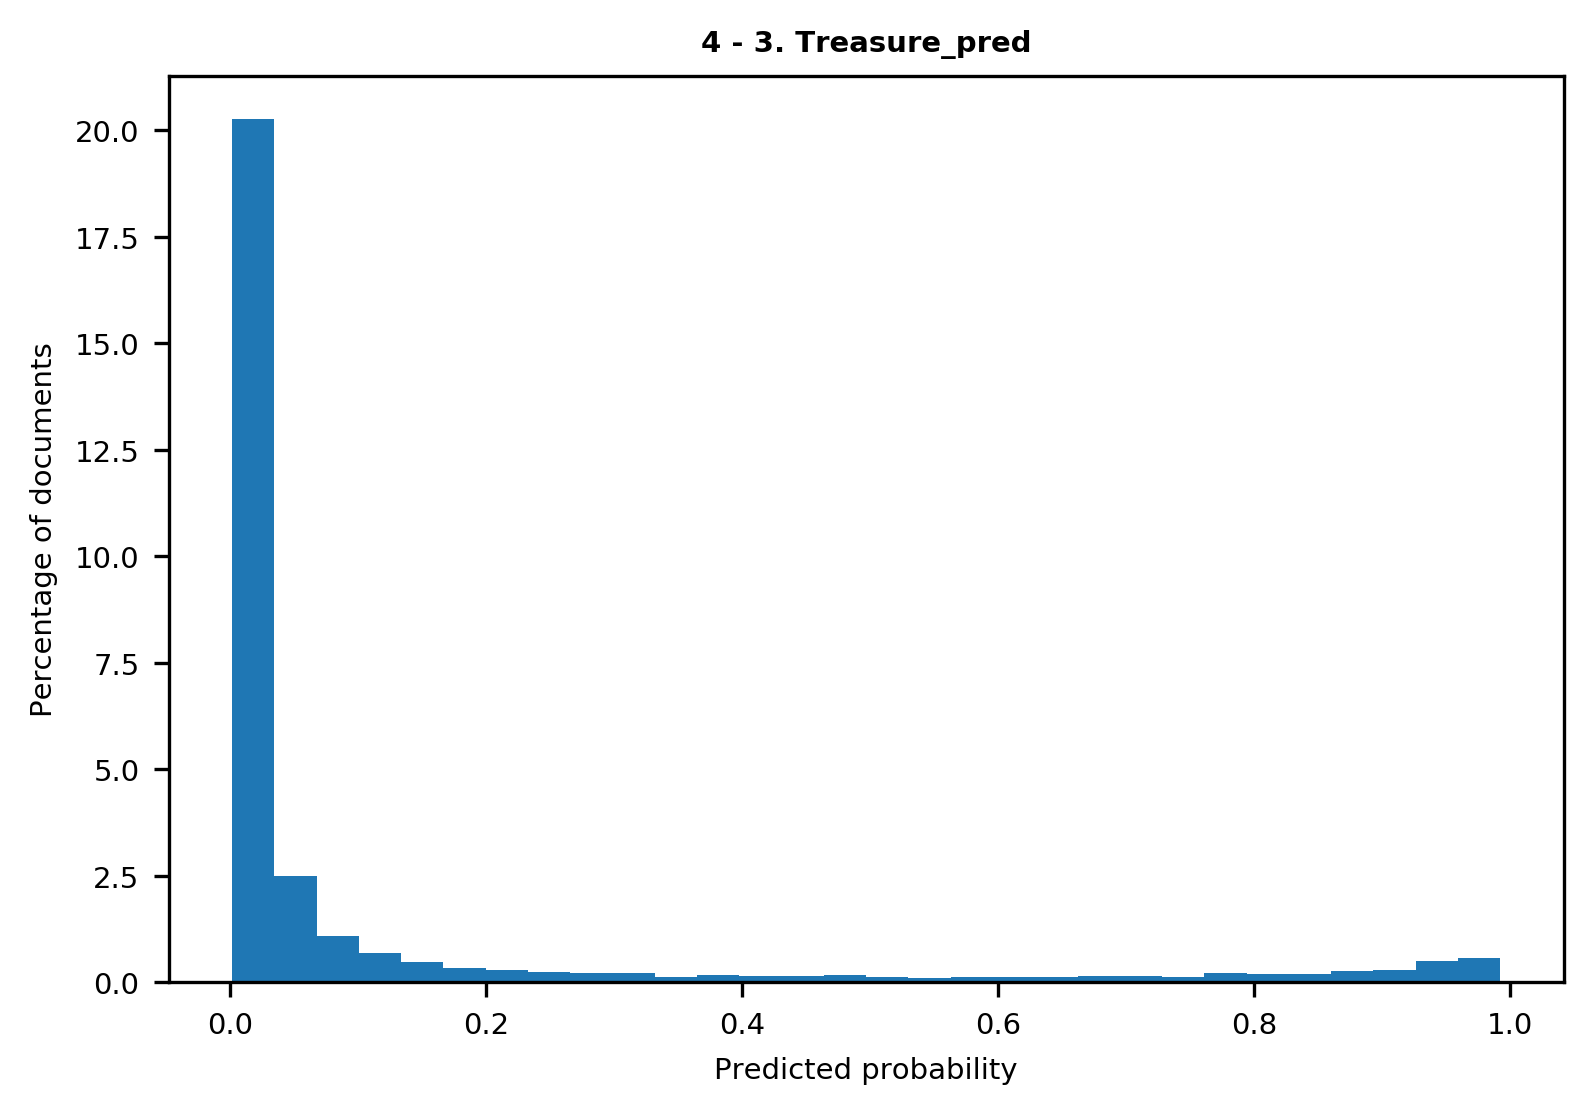

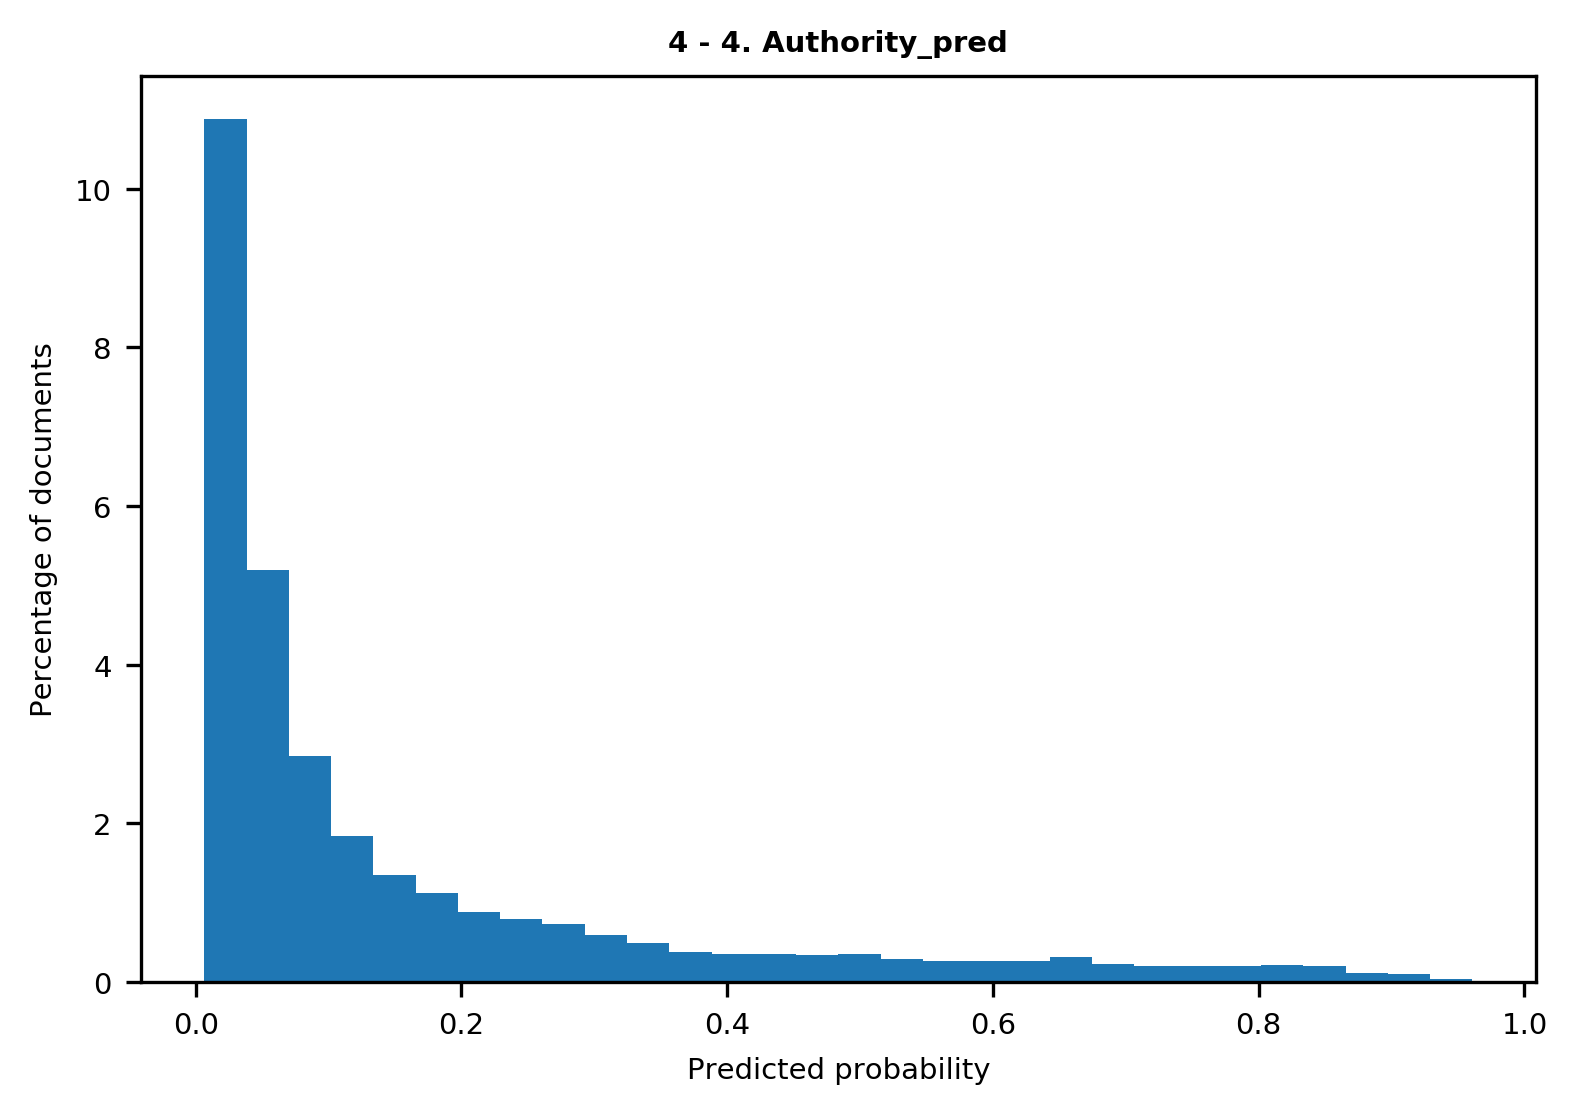

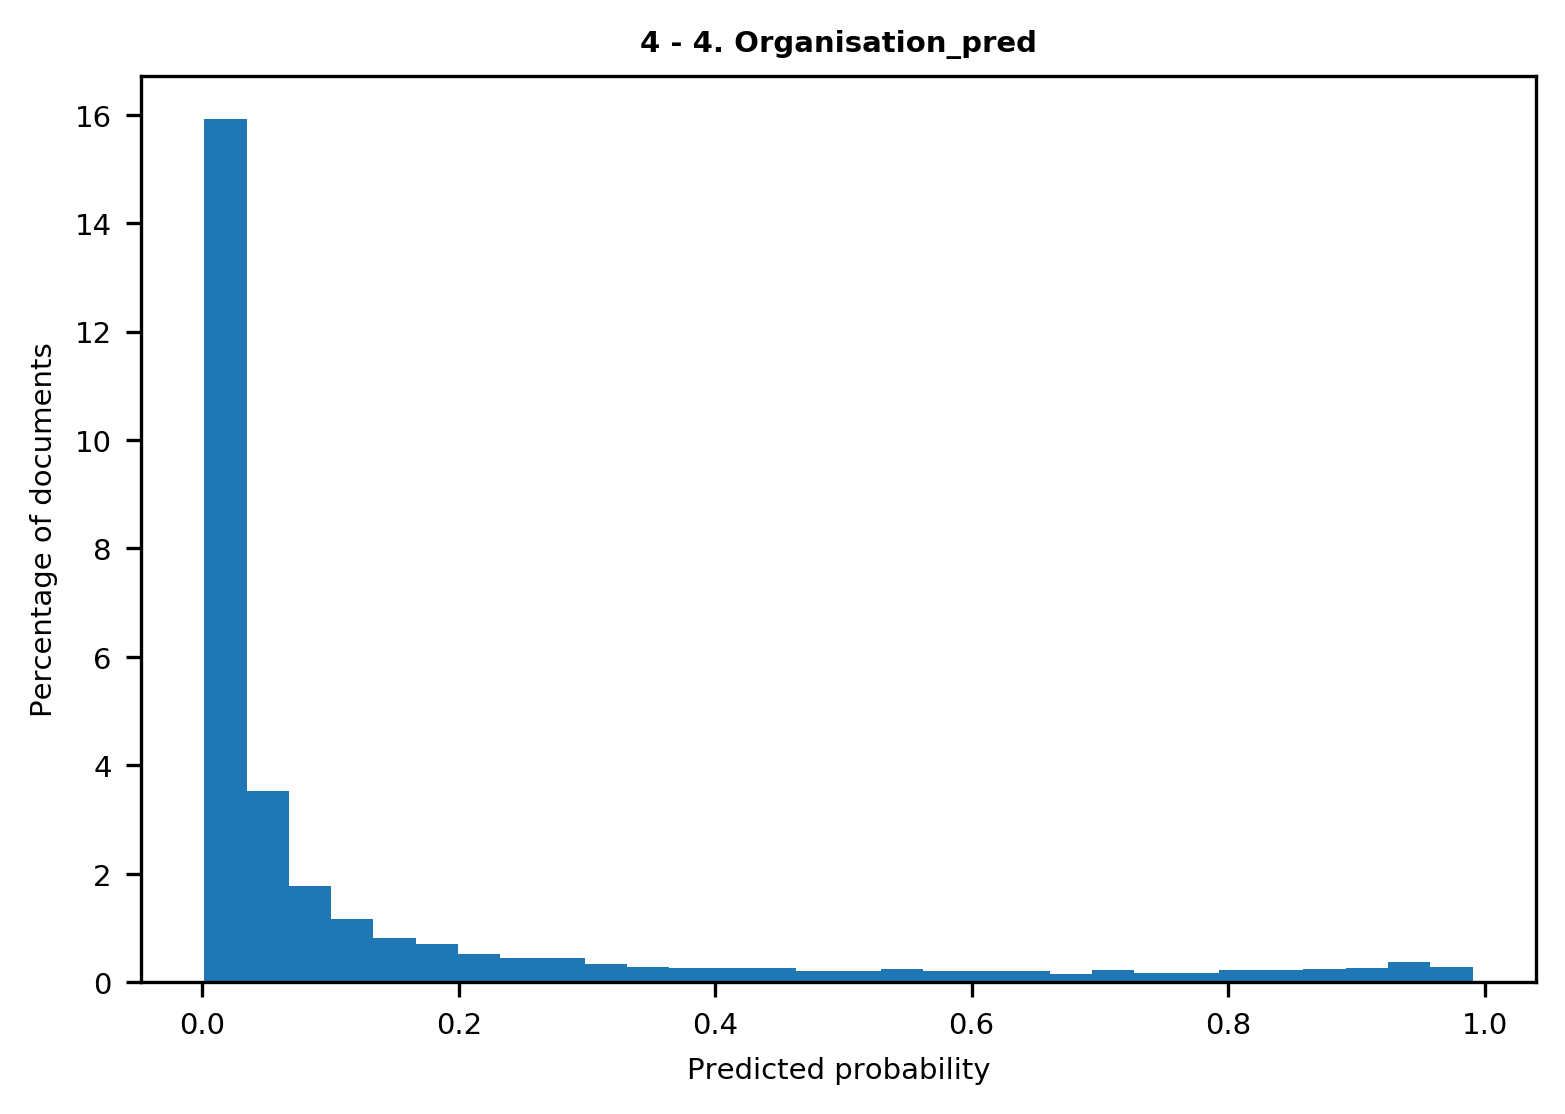

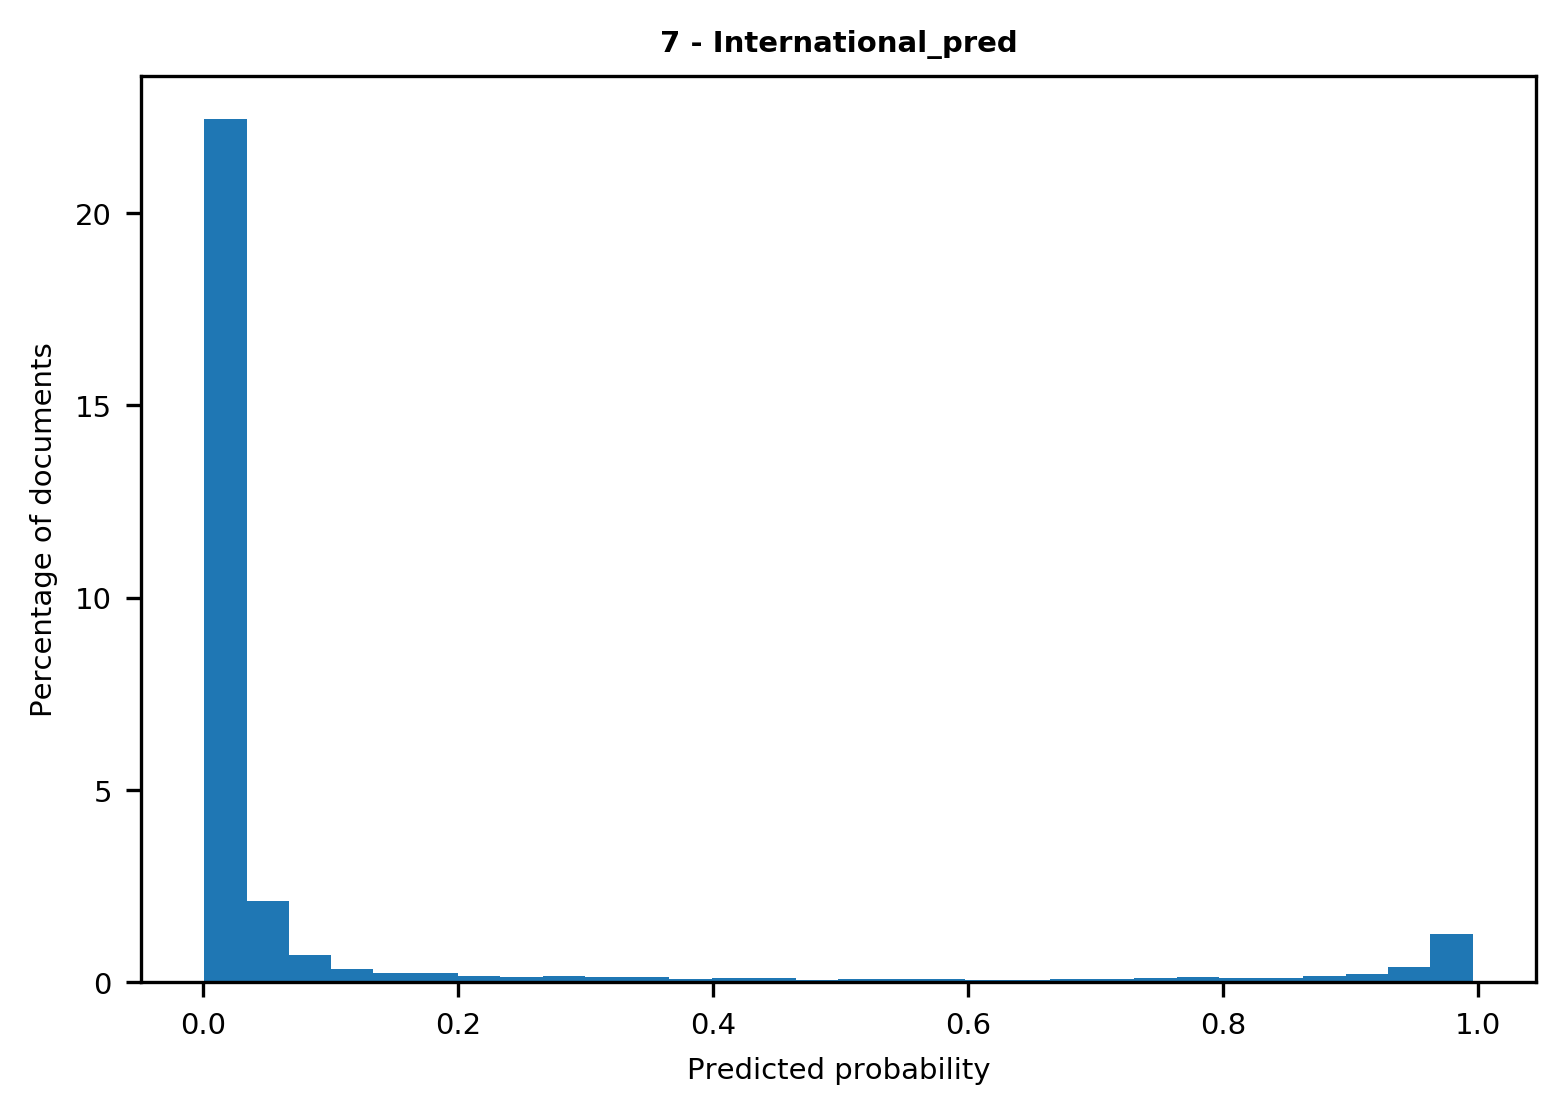

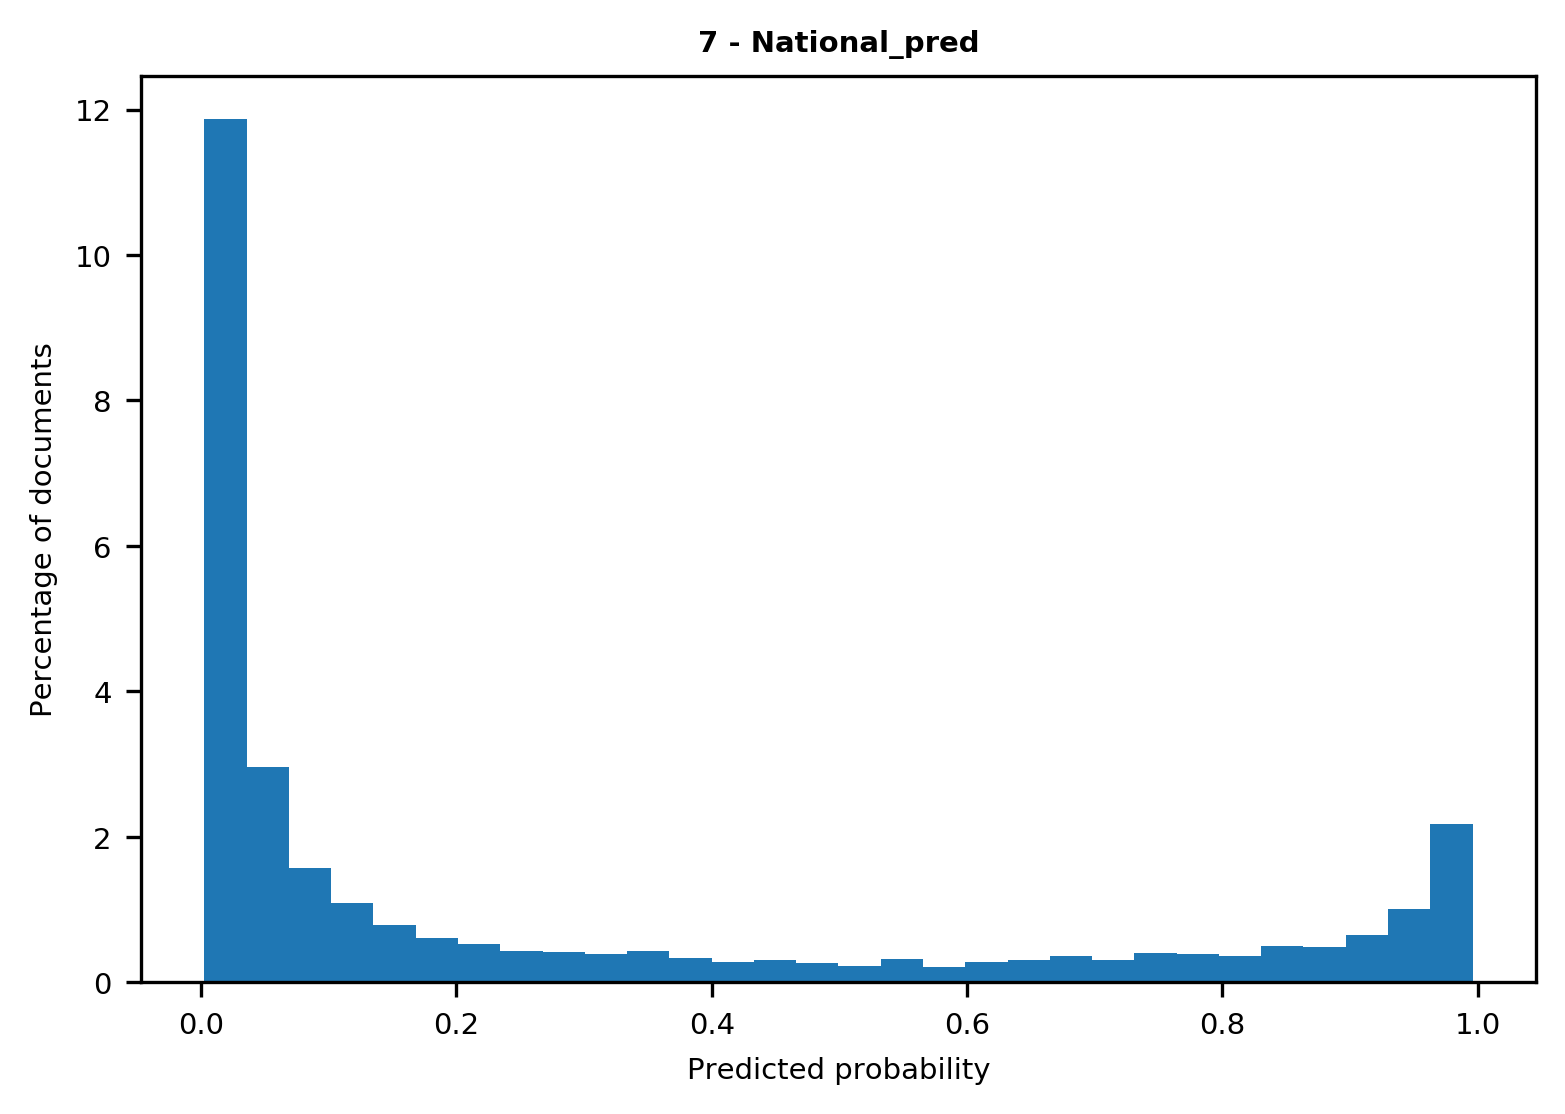

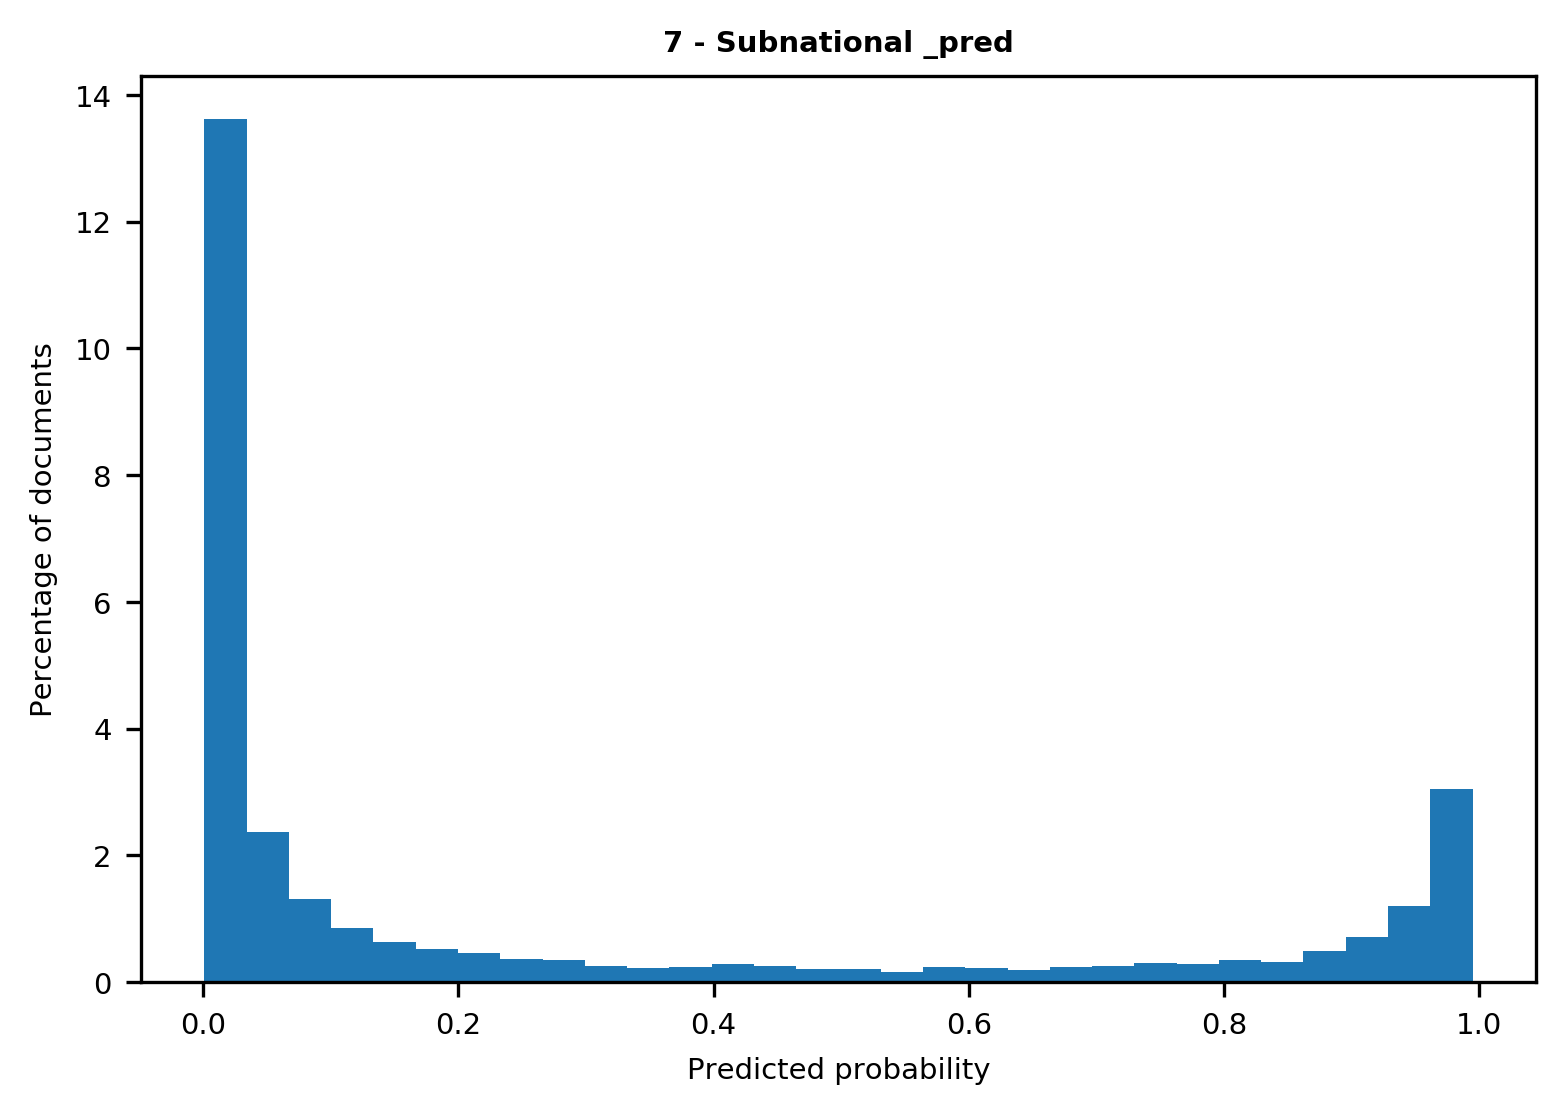

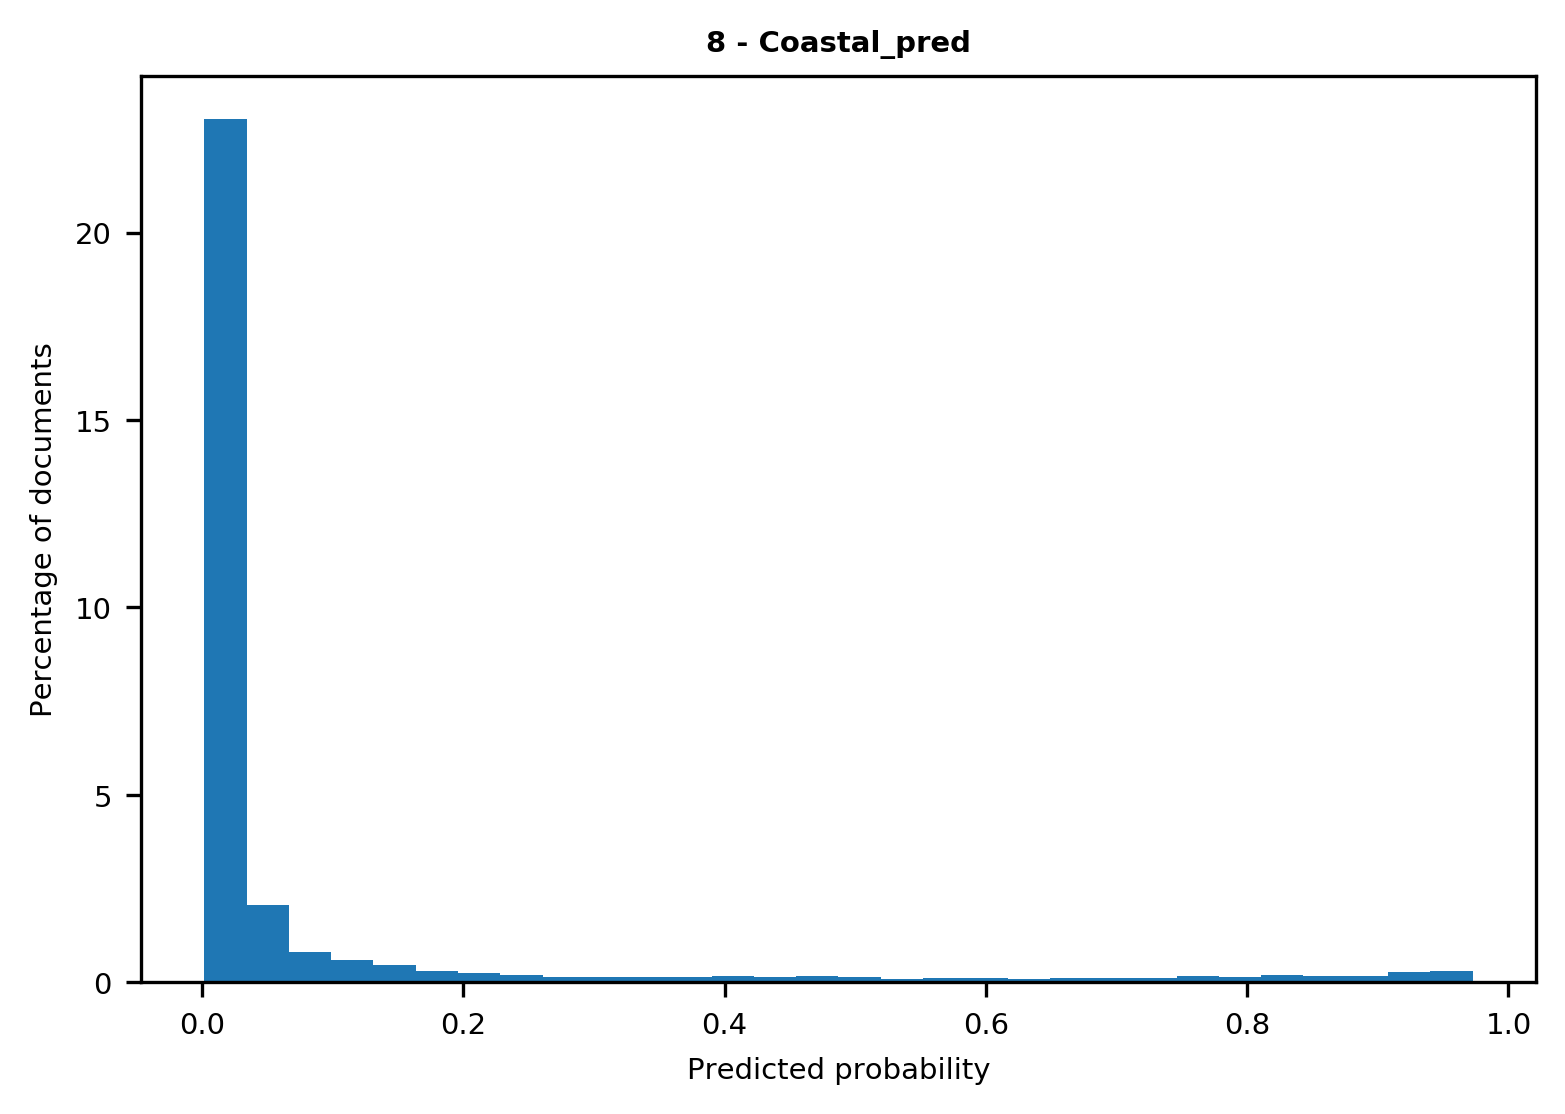

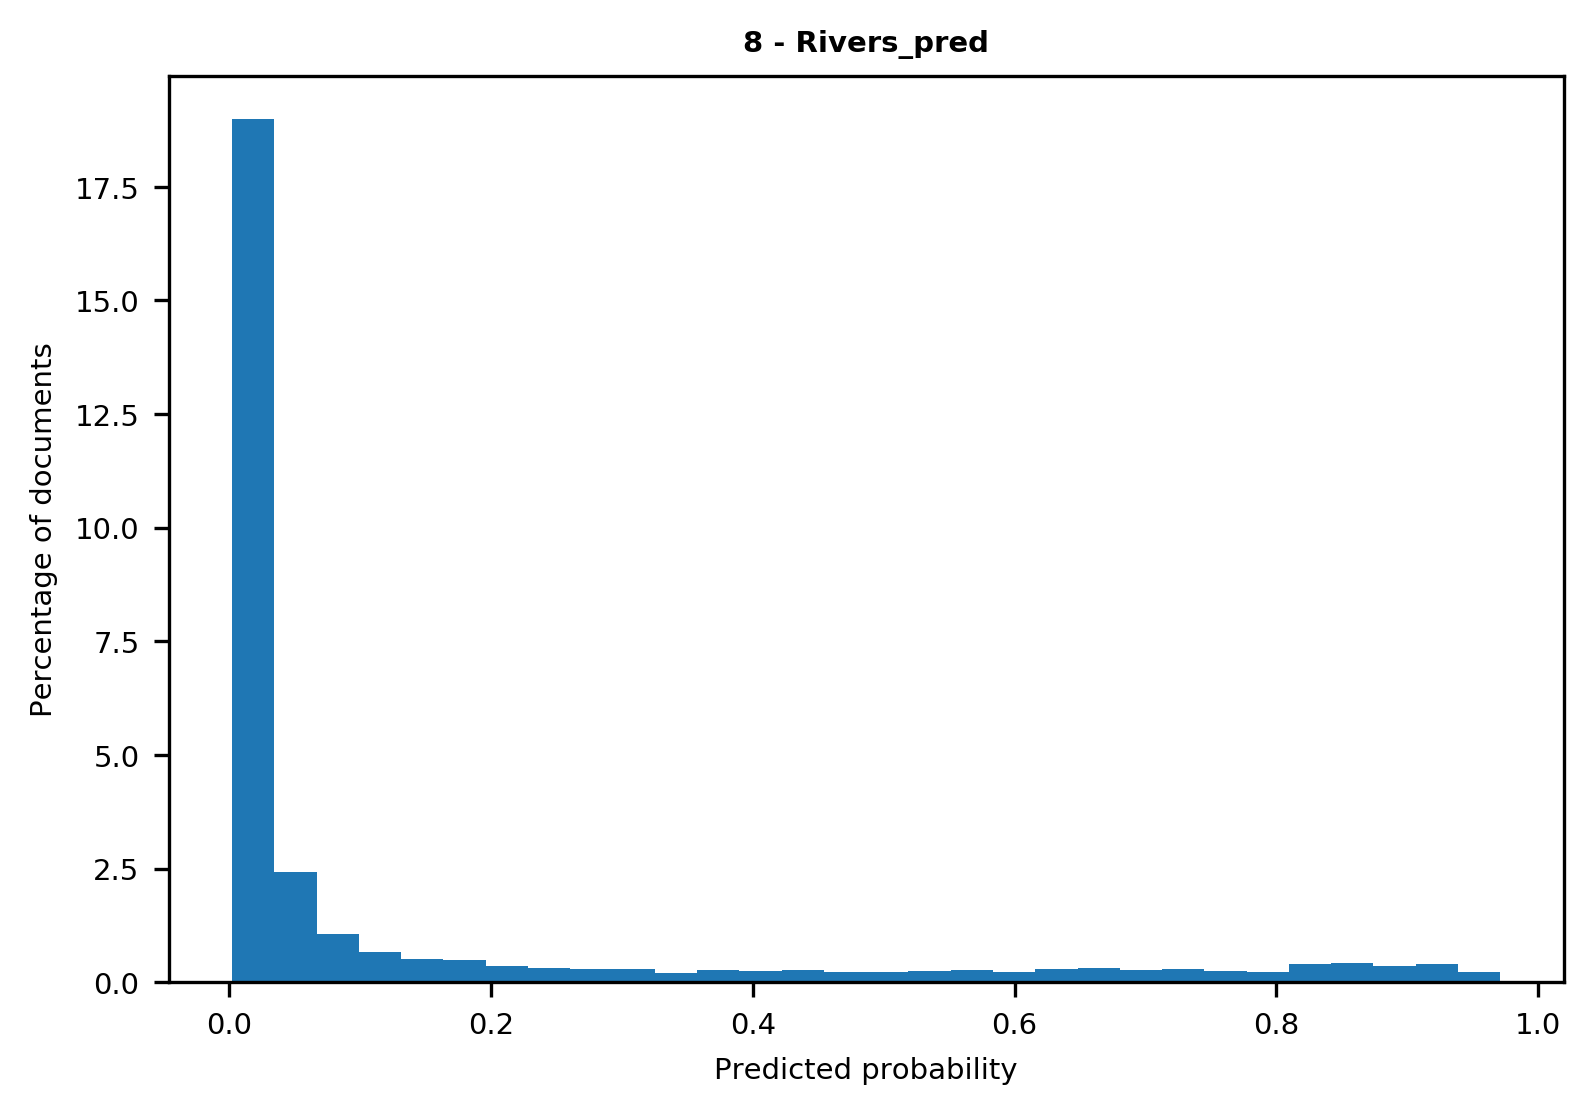

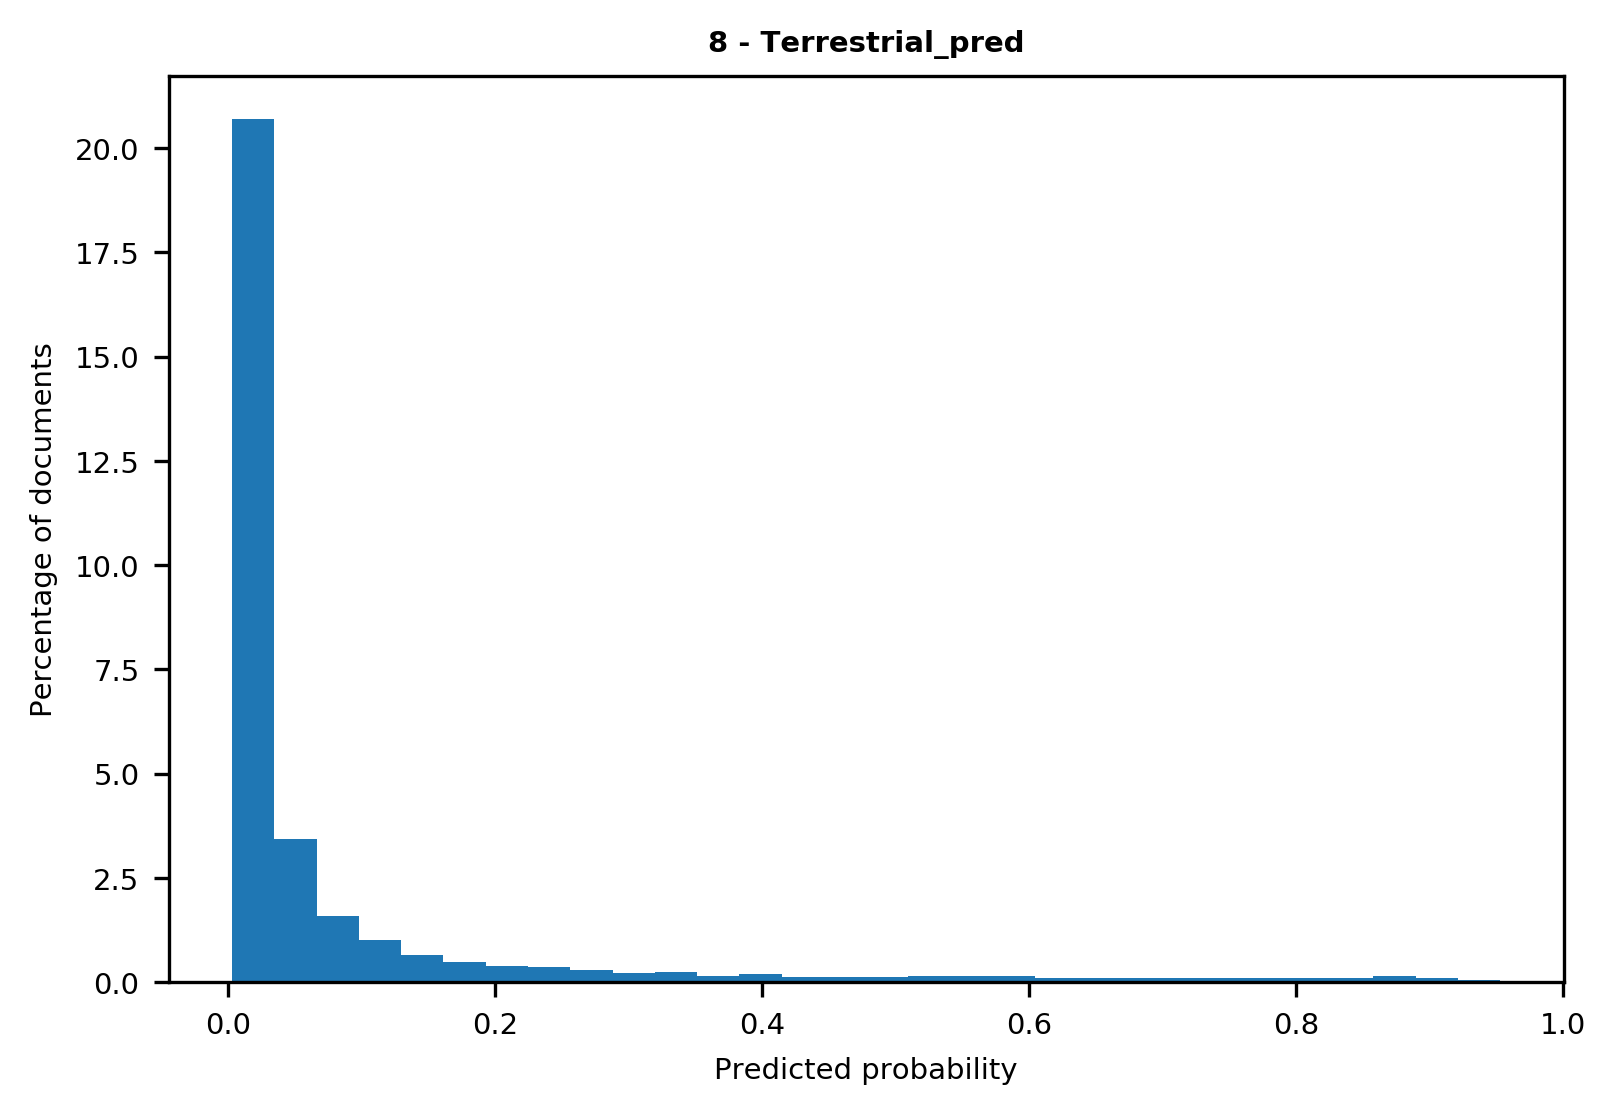

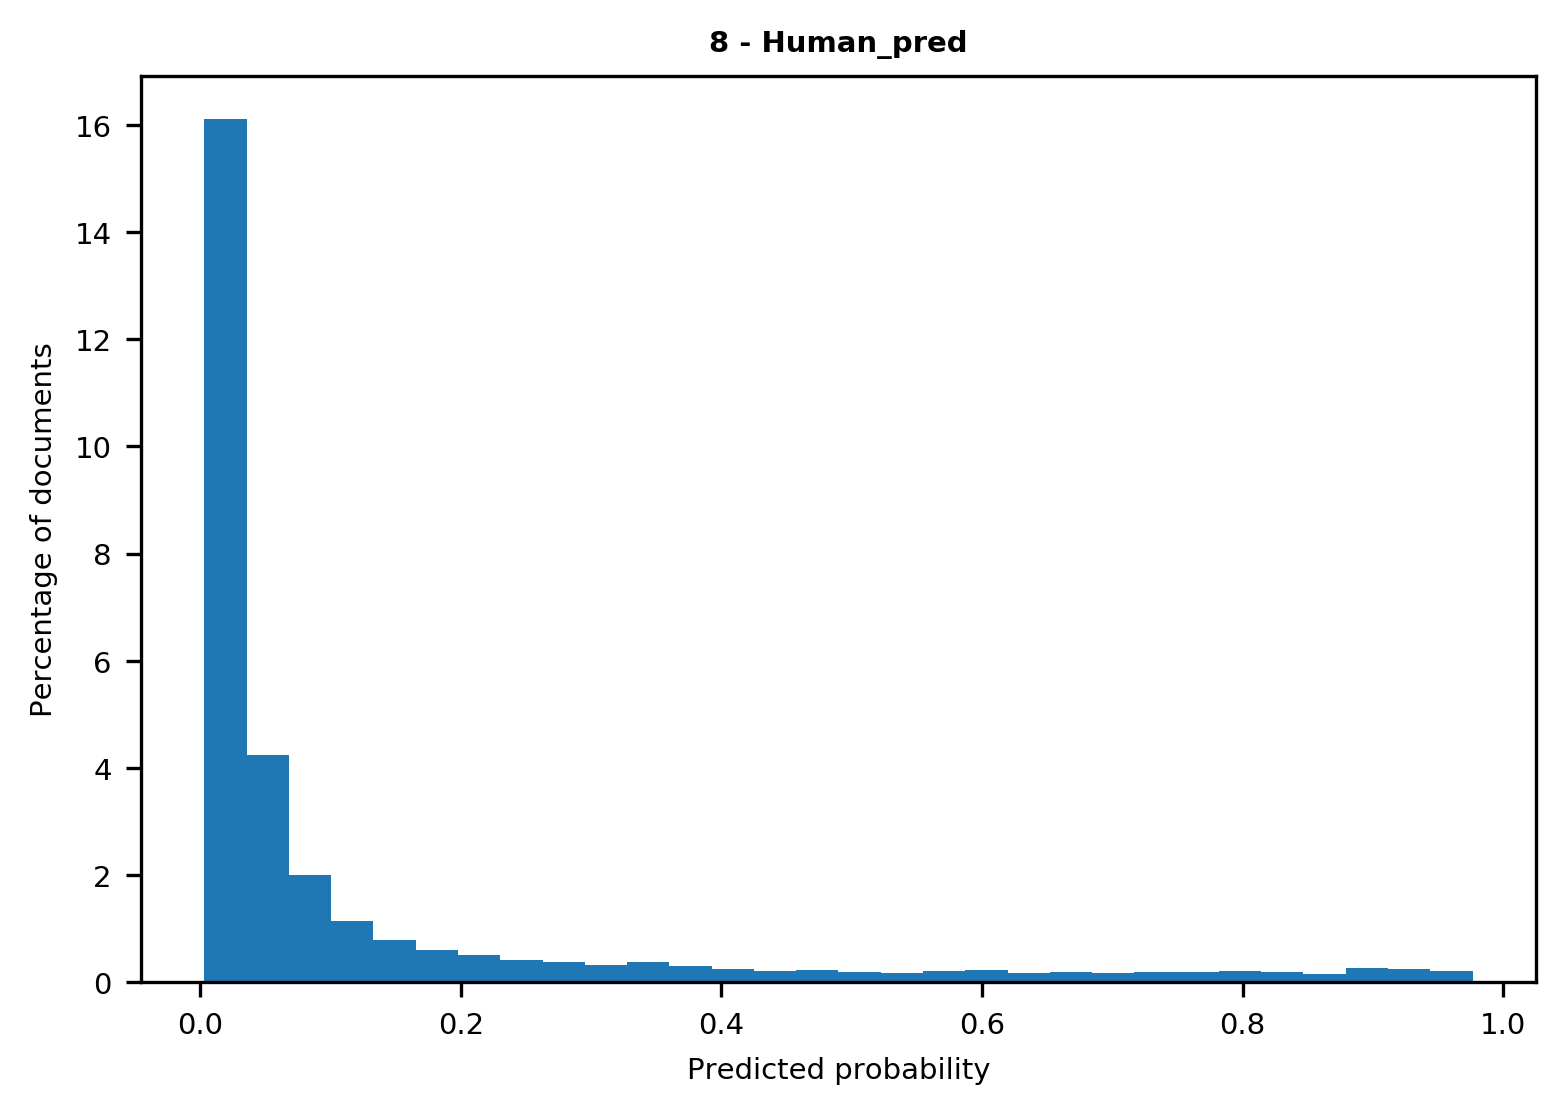

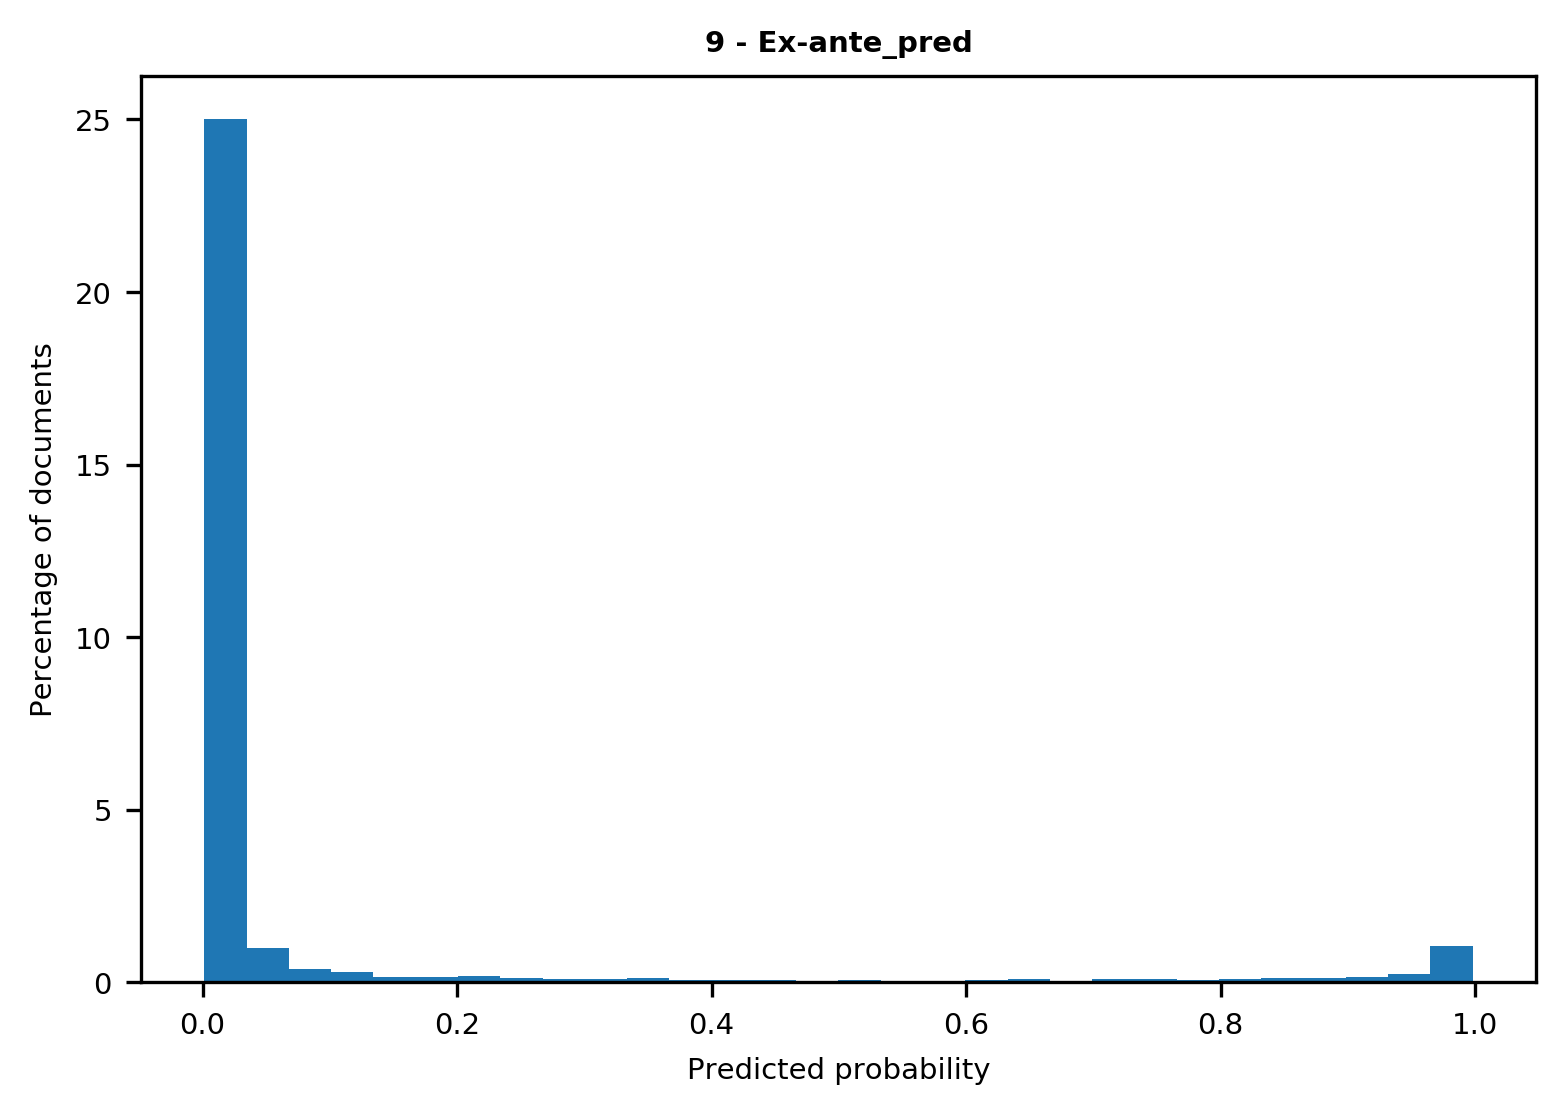

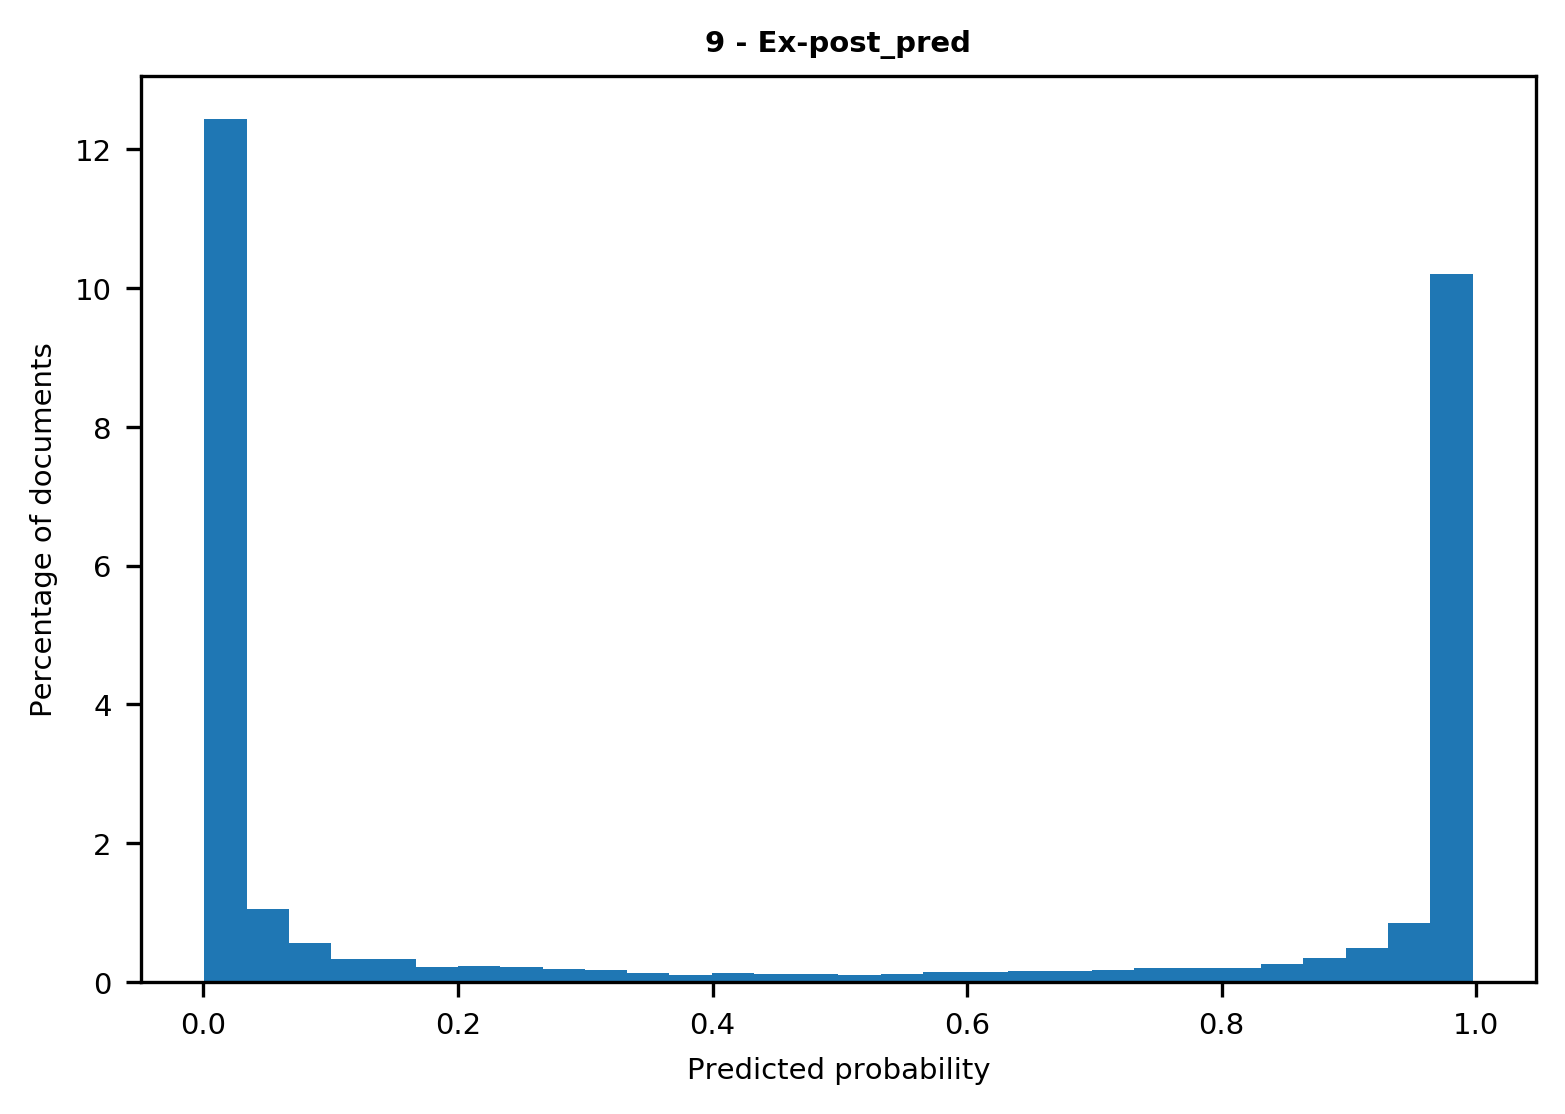

In [136]:
for c in classes_pred:
    fig, ax = plt.subplots(dpi=300)
    plt.hist(cdf[c], density=True, bins=30)  # density=False would make counts
    plt.title(c, weight="bold")
    plt.xlabel("Predicted probability")
    plt.ylabel("Percentage of documents")
    fig.patch.set_facecolor("white")
    plt.show()

In [13]:
#create a new query that can be used for topic modelling for example
newq, created = Query.objects.get_or_create(
    project=p,
    creator=User.objects.get(username="eeajs@leeds.ac.uk"),
    title=f"{now}_PredictedRelevant_BERT"
)

T = Doc.query.through
dqs = [T(doc_id=did, query=newq) for did in cdf['id'].tolist()]
T.objects.bulk_create(dqs)
newq.r_count = newq.doc_set.count()
newq.save()

In [230]:
#Year info was stripped on export. Add back
rdf = cdf.merge(df[['PY', 'id']], on = 'id', how='inner', )
rdf['PY'] = pd.to_numeric(rdf['PY'], downcast = 'integer', errors = 'coerce')
rdf.shape

(8299, 65)

In [231]:
#To make it a bit easier, merge the prediction scores into the non-prediction categories
#This way, we don't have to select both the labelled and the predicted classes separately
keepCol =  ['id', 'title', 'content', 'PY','seen','random','include_score']
for pred in classes_pred:
    lab = pred.split("_pred")[0]
    keepCol.append(lab)
    #rdf[lab]=np.where(rdf['seen'].eq(1),rdf[pred],rdf[lab])
    #rdf[lab]=rdf[lab].mask(rdf['seen'].eq(1),rdf[pred])
    rdf.loc[rdf['seen'].isna(), lab] = rdf[pred]

rdf = rdf[keepCol]
print(rdf.shape)
print(rdf.columns)

#rdf.to_csv('data/withPredictions_minimal.csv', index=False, encoding='UTF-8')

rdf.head()

(8299, 23)
Index(['id', 'title', 'content', 'PY', 'seen', 'random', 'include_score',
       '2 - Adaptation', '2 - Mitigation', '2 - Other', '4 - 1. Nodality',
       '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation',
       '7 - International', '7 - National', '7 - Subnational ', '8 - Coastal',
       '8 - Rivers', '8 - Terrestrial', '8 - Human', '9 - Ex-ante',
       '9 - Ex-post'],
      dtype='object')


,id,title,content,PY,seen,random,include_score,2 - Adaptation,2 - Mitigation,2 - Other,...,4 - 4. Organisation,7 - International,7 - National,7 - Subnational,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,9 - Ex-ante,9 - Ex-post
0,505468,Community pond rehabilitation to deal with cli...,A large number of small- to medium-sized commu...,2016,NaN,NaN,0.968089,0.783095,0.003115,0.246469,...,0.959119,0.013613,0.022471,0.961818,0.039962,0.874821,0.068860,0.103273,0.619294,0.936461
1,3286707,Vulnerability to global environmental changes:...,The purpose of this paper is to demonstrate th...,2018,NaN,NaN,0.587677,0.030497,0.003366,0.003145,...,0.048519,0.001559,0.017716,0.100522,0.003420,0.005188,0.004376,0.022849,0.003031,0.012849
2,1962940,Migratory issues in climate adaptation policie...,The issue of climate change has shed a new lig...,2012,NaN,NaN,0.996653,0.851657,0.075038,0.011788,...,0.003477,0.053642,0.857579,0.003639,0.007104,0.007903,0.014083,0.123407,0.006712,0.995119
3,1047270,Women's Empowerment and Climate Change Adaptat...,(1) As on-the-ground projects come into existe...,2018,NaN,NaN,0.948534,0.622924,0.003628,0.018892,...,0.910039,0.007457,0.016662,0.070956,0.003045,0.003763,0.004649,0.016103,0.002465,0.052423
4,770190,Climatic and Environmental Changes Affecting C...,Small rural coastal communities located in Atl...,2017,NaN,NaN,0.866686,0.814135,0.004539,0.028920,...,0.060801,0.002592,0.009204,0.564695,0.891267,0.044223,0.035439,0.026959,0.008394,0.801332


In [220]:
rdf[rdf['relevant'] ==1].head()

,id,content,title,relevant,seen,random,relevant_high,2 - Adaptation,2 - Mitigation,2 - Other,...,4 - 4. Organisation,7 - International,7 - National,7 - Subnational,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,9 - Ex-ante,9 - Ex-post
11,3829738,The Caribbean Community Climate Change Centre ...,"Adaptation, Official Development Assistance, a...",1.0,1.0,NaN,NaN,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,610470,Serious attempts have been made to manage the ...,Managing the Indian coast in the face of disas...,1.0,1.0,NaN,NaN,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40,2185632,"Due to increased urbanisation, and climate cha...",Assessment of barriers and drivers for impleme...,1.0,1.0,NaN,NaN,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
85,2282838,We use concepts drawn from the adaptive govern...,Adapting wildland fire governance to climate c...,1.0,1.0,1.0,NaN,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
93,774009,The objective of the article is to give a comp...,Impact of physical geographical factors on sus...,1.0,1.0,1.0,NaN,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [209]:
cdf[cdf['seen'] == 1].head()

,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,4 - 1. Nodality,...,7 - Subnational _pred_y,8 - Coastal_pred_y,8 - Rivers_pred_y,8 - Terrestrial_pred_y,8 - Human_pred_y,9 - Ex-ante_pred,9 - Ex-post_pred,7 - International_pred,7 - National_pred,7 - Subnational _pred
11,3829738,The Caribbean Community Climate Change Centre ...,"Adaptation, Official Development Assistance, a...",1.0,1.0,NaN,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,610470,Serious attempts have been made to manage the ...,Managing the Indian coast in the face of disas...,1.0,1.0,NaN,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,2185632,"Due to increased urbanisation, and climate cha...",Assessment of barriers and drivers for impleme...,1.0,1.0,NaN,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,2282838,We use concepts drawn from the adaptive govern...,Adapting wildland fire governance to climate c...,1.0,1.0,1.0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,774009,The objective of the article is to give a comp...,Impact of physical geographical factors on sus...,1.0,1.0,1.0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


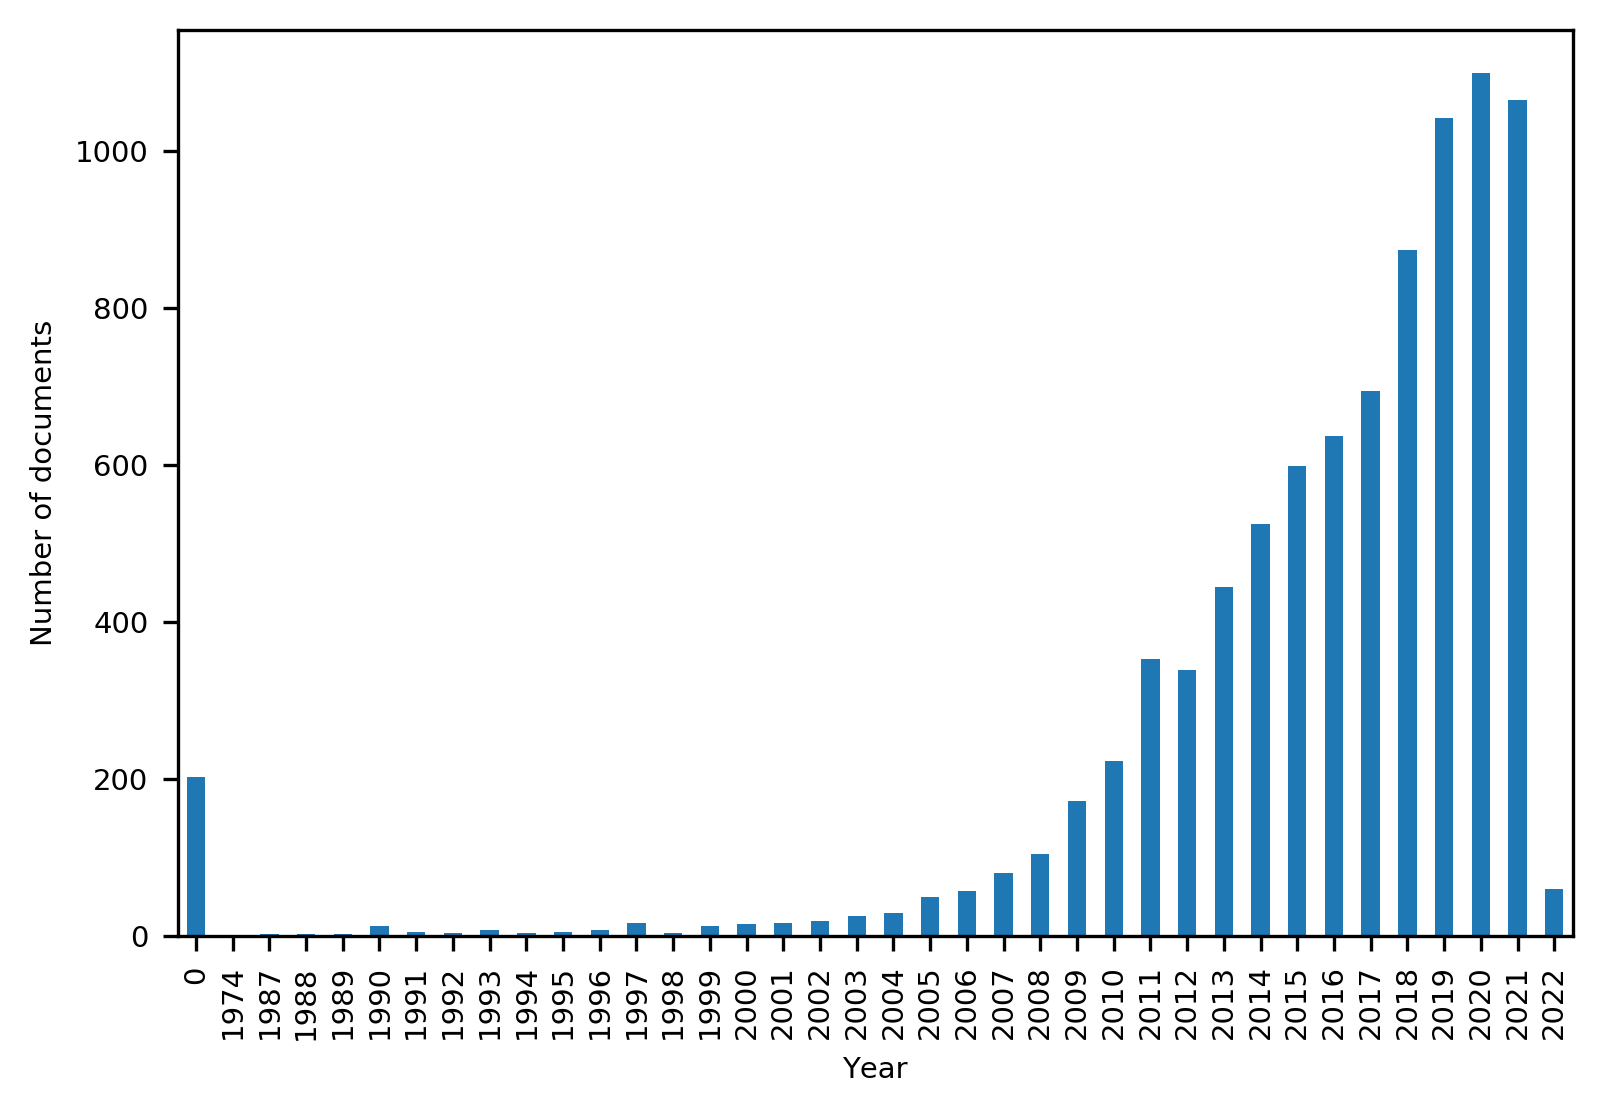

In [65]:
#Plot publications per year
fig, ax = plt.subplots(dpi=300)
rdf.sort_values('PY', inplace=True)
#rdf['PY'].value_counts(sort=False).plot(ax=ax, kind='bar', xlabel='Year', ylabel='Number of documents')
rdf.groupby('PY').size().plot.bar( xlabel='Year', ylabel='Number of documents')
plt.show()

In [66]:
exportCols = ['id', 'content', 'title', 'relevant',
       'seen', 'random', '2 - Adaptation', '2 - Mitigation', '2 - Other',
       '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority',
       '4 - 4. Organisation', '7 - International', '7 - National',
       '7 - Subnational ', '8 - Coastal', '8 - Rivers', '8 - Terrestrial',
       '8 - Human', '9 - Ex-ante', '9 - Ex-post', 'y_k_prediction_SVM-rbf',
       '0 - relevance - prediction', 'text', 'labels', 'exclude_score',
       'include_score', 'relevant_high', '2 - Adaptation_pred',
       '2 - Mitigation_pred', '2 - Other_pred', '4 - 1. Nodality_pred',
       '4 - 3. Treasure_pred', '4 - 4. Authority_pred',
       '4 - 4. Organisation_pred', '7 - International_pred',
       '7 - National_pred', '7 - Subnational _pred', '8 - Coastal_pred',
       '8 - Rivers_pred', '8 - Terrestrial_pred', '8 - Human_pred',
       '9 - Ex-ante_pred_x', '9 - Ex-post_pred_x', '2 - Adaptation_pred_y',
       '2 - Mitigation_pred_y', '2 - Other_pred_y', '4 - 1. Nodality_pred_y',
       '4 - 3. Treasure_pred_y', '4 - 4. Authority_pred_y',
       '4 - 4. Organisation_pred_y', '7 - International_pred_y',
       '7 - National_pred_y', '7 - Subnational _pred_y', '8 - Coastal_pred_y',
       '8 - Rivers_pred_y', '8 - Terrestrial_pred_y', '8 - Human_pred_y',
       '9 - Ex-ante_pred', '9 - Ex-post_pred', 'PY'

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'content', 'title', 'relevant',
       'seen', 'random', '2 - Adaptation', '2 - Mitigation', '2 - Other',
       '4 - 1. Nodality', '4 - 3. Treasure', '4 - 4. Authority',
       '4 - 4. Organisation', '7 - International', '7 - National',
       '7 - Subnational ', '8 - Coastal', '8 - Rivers', '8 - Terrestrial',
       '8 - Human', '9 - Ex-ante', '9 - Ex-post', 'y_k_prediction_SVM-rbf',
       '0 - relevance - prediction', 'text', 'labels', 'exclude_score',
       'include_score', 'relevant_high', '2 - Adaptation_pred',
       '2 - Mitigation_pred', '2 - Other_pred', '4 - 1. Nodality_pred',
       '4 - 3. Treasure_pred', '4 - 4. Authority_pred',
       '4 - 4. Organisation_pred', '7 - International_pred',
       '7 - National_pred', '7 - Subnational _pred', '8 - Coastal_pred',
       '8 - Rivers_pred', '8 - Terrestrial_pred', '8 - Human_pred',
       '9 - Ex-ante_pred_x', '9 - Ex-post_pred_x', '2 - Adaptation_pred_y',
       '2 - Mitigation_pre

#### Comparing the outcomes of both classifiers

In [46]:
rdf'0 - relevance - prediction',

Index(['Unnamed: 0', 'id', 'content', 'title', 'relevant', 'seen', 'random',
       '2 - Adaptation', '2 - Mitigation', '2 - Other', '4 - 1. Nodality',
       '4 - 3. Treasure', '4 - 4. Authority', '4 - 4. Organisation',
       '7 - International', '7 - National', '7 - Subnational ', '8 - Coastal',
       '8 - Rivers', '8 - Terrestrial', '8 - Human', '9 - Ex-ante',
       '9 - Ex-post', 'y_k_prediction_SVM-rbf', '0 - relevance - prediction',
       'text', 'labels', 'exclude_score', 'include_score', 'relevant_high',
       '2 - Adaptation_pred', '2 - Mitigation_pred', '2 - Other_pred',
       '4 - 1. Nodality_pred', '4 - 3. Treasure_pred', '4 - 4. Authority_pred',
       '4 - 4. Organisation_pred', '7 - International_pred',
       '7 - National_pred', '7 - Subnational _pred', '8 - Coastal_pred',
       '8 - Rivers_pred', '8 - Terrestrial_pred', '8 - Human_pred',
       '9 - Ex-ante_pred', '9 - Ex-post_pred', 'PY'],
      dtype='object')

In [49]:
print(f"Average SVM score for relevant: {rdf['0 - relevance - prediction'].mean()}") #Skips NaN (i.e. seen docs) by default

Average SVM score for relevant: 0.3680695281295279


In [54]:
#Let's print a few random ones that have an exceptionally low SVM score
#-- i.e.: if relevant, ones that SVM has missed. If irrelevant, ones that BERT wrongfully includes
#Doing a print statement so that text isn't truncated on jupyter
lowSvm = rdf[(rdf['0 - relevance - prediction'] < 0.2) & (rdf['include_score'] > 0.75)]
print(f"There are {lowSvm.shape[0]} documents in this set\n\n")
for i, row in lowSvm.sample(frac=1).head(10).iterrows():
    print(row["title"],
          "\n", 
          row["content"],
          "\n"*2
    )

There are 1929 documents in this set


Reframing urban governance for resilience implementation: The role of network closure and other insights from a network approach 
 The concept of urban resilience, particularly through a systems framework, has advanced tremendously over the past decade. Relatedly, collaborative and network governance is increasingly considered essential for the sustainability of urban social-ecological-technical systems. However, empirical evidence explicitly linking metropolitan networks to resilience planning and implementation is sparse. We address this gap by researching a network of organizations pursuing resilience strategies within and across two major metropolitan areas in Texas - Austin and San Antonio. Utilizing a mixed-methods approach that includes qualitative and social network analysis (descriptive and exponential random graph modeling), we examine the factors that drive network formation around blue-green infrastructure in the study area. The planni

In [57]:
#Now the opposite: print a few random ones with a high SVM score but predicted irrelevant by BERT
#--i.e. if relevant, ones that BERT missed
#Doing a print statement so that text isn't truncated on jupyter
highSvm = df[(~df["id"].isin(rdf["id"])) & (rdf['0 - relevance - prediction'] > 0.75)]
print(f"There are {highSvm.shape[0]} documents in this set\n\n")
for i, row in highSvm.sample(frac=1).head(10).iterrows():
    print(row["title"],
          "\n", 
          row["content"],
          "\n"*2
    )

There are 675 documents in this set


Predicting and mapping malaria under climate change scenarios: the potential redistribution of malaria vectors in Africa 
 Background: Malaria is rampant in Africa and causes untold mortality and morbidity. Vector-borne diseases are climate sensitive and this has raised considerable concern over the implications of climate change on future disease risk. The problem of malaria vectors (Anopheles mosquitoes) shifting from their traditional locations to invade new zones is an important concern. The vision of this study was to exploit the sets of information previously generated by entomologists, e. g. on geographical range of vectors and malaria distribution, to build models that will enable prediction and mapping the potential redistribution of Anopheles mosquitoes in Africa. Methods: The development of the modelling tool was carried out through calibration of CLIMEX parameters. The model helped estimate the potential geographical distribution and se

In [58]:
rdf.to_csv('data/forSTM.csv', encoding='UTF-8', index=False)

In [59]:
df.columns

,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,random,2 - Adaptation,...,7 - Subnational,8 - Coastal,8 - Rivers,8 - Terrestrial,8 - Human,9 - Ex-ante,9 - Ex-post,10 - Governance,10 - Resources,10 - Other
0,3792331,To construct a long-term energy plan for renew...,Climate change impacts on potential solar ener...,2020.0,Climate change; Impact assessment; Climate sce...,[Green & Sustainable Science & Technology; Ene...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,280262,Mid-season drainage (MSD) decreases methane em...,Interannual variations in methane emission fro...,2016.0,Methane; Rice paddy; Mid-season drainage; Eddy...,"[Agriculture, Multidisciplinary; Ecology; Envi...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1288320,Understanding the extent to which agriculture ...,The potential benefits of agricultural adaptat...,2018.0,Climate change; adaptation capacity; agricultu...,[Economics; Environmental Studies],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,129554,This study investigates future impacts of glob...,Potential influences of global warming on futu...,2013.0,Global warming; Nigeria; Ecological zone; Clim...,[Environmental Sciences; Environmental Studies],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,345398,"Zebra mussels (Dreissena polymorpha, Pallas, 1...",Effects of increasing temperatures on populati...,2007.0,global change; thermal tolerance; life history...,[Ecology],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50457,4919565,Dianzhong cattle is a classic Chinese indigeno...,Assessing Genomic Diversity and Productivity S...,2021.0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50458,2477439,Nuclear sites around the world are being decom...,Strategic considerations for the sustainable r...,2019.0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50459,211149,Runoff water management is among the inherent ...,Rainfall conditions and rainwater harvesting p...,2014.0,Rainwater harvesting; Urban runoff; Rainfall c...,"[Engineering, Environmental; Environmental Sci...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50460,514479,"The analysis of the growth behaviour, wood ana...",Morpho-anatomical and physiological traits of ...,2017.0,Leaf water potential; Quantitative wood anatom...,[Forestry],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compare to GAMI

In [28]:
gadf = pd.read_csv('data/GAMI_Database_with_bibinfo.csv', encoding = 'utf-8')
print(gadf.columns.to_list())
print(gadf.shape)
gadf.head()

['Article.ID', 'Summarize', '1.1.Geography', 'GEOG_REGION', '1.1.1.Geography-Country', '1.2.Sector', '1.3.Cross.cutting.topics', '1.4.Indigenous.knowledge', '1.5.Local.knowledge', '2.1.1.Actors.Institutions', '2.1.2.Actors-Other', '2.1.3.Actors-QUOTES', '2.2.1.Equity-Planning', '2.2.2.Equity-PlanOther', '2.2.3.Equity-PlanQUOTES', '2.3.1.Equity-Targeting', '2.3.2.Equity-TarOther', '2.3.3.Equity-TarQUOTES', '3.1.1.ResponseType', '3.1.2.Response-QUOTES', '3.2.1.Implementation.tools', '3.2.2.ImpTools-QUOTES', '3.3.1.Hazards', '3.3.2.Hazards-Other', '3.3.3.Hazards-QUOTES', '3.4.1.Exposure.vulnerability', '3.4.2.Exposure-Other', '3.4.3.Exposure-QUOTES', '3.5.1.Link.to.risks', '3.5.2.Links-QUOTES', 'Implementation widespread.Vulnerability assessment and/or early planning.Vulnerability assessment and/or early planning.Implementation', '4.1.2.Implement-QUOTES', '4.2.Finance', '4.3.Costs', '4.4.1.Depth', '4.4.2.Depth-QUOTES', '4.5.1.Scope', '4.5.2.Scope-QUOTES', '4.6.1.Speed', '4.6.2.Speed-QUOTE

,Article.ID,Summarize,1.1.Geography,GEOG_REGION,1.1.1.Geography-Country,1.2.Sector,1.3.Cross.cutting.topics,1.4.Indigenous.knowledge,1.5.Local.knowledge,2.1.1.Actors.Institutions,...,Book Series Title,Special Issue,ISSN,Publication Name,Conference Sponsors,Supplement,Times Cited,Volume,Web of Science Category,APSIS ID
0,6205478,The study documents the effect of human capita...,Africa,Africa|,Bawku West district located in the north-easte...,Poverty livelihoods & sustainable development,Deserts/semi-arid areas/desertification,False,False,Individuals or households||| Local government,...,NaN,NaN,9781629489858 (ISBN); 9781629489759 (ISBN),Agric. and Trade: Int. Perspect.,NaN,NaN,1.0,NaN,NaN,449876.0
1,6205479,he aim of this study was to understand how fam...,Africa,Africa|,Tunisia,Food fibre & other ecosystem products|||Healt...,Biodiversity hotspots,True,True,Civil Society- sub-national or local||| Indiv...,...,NaN,NaN,1166-7699,CAHIERS AGRICULTURES,NaN,NaN,4.0,25,"Agriculture, Multidisciplinary; Agronomy",72692.0
2,6205480,This study assessed the influence of climate v...,Africa,Africa|,Tanzania,Poverty livelihoods & sustainable development,None,False,False,Individuals or households,...,NaN,NaN,20487010 (ISSN),Agric. Food Secur.,NaN,NaN,1.0,5,NaN,559201.0
3,6205481,the study evaluates cropping adaptation option...,Africa,Africa|,"Zimbabwe|||Samburu County, Kenya",Poverty livelihoods & sustainable development,None,False,False,Individuals or households,...,NaN,NaN,0305-750X,WORLD DEVELOPMENT,NaN,NaN,14.0,84,Development Studies; Economics,268986.0
4,6205482,Using field-based data collected from two stud...,Africa,Africa|Europe,Mukonchi and Lunchu settlements in Central Pro...,"Health, well-being & communities",Deserts/semi-arid areas/desertification,False,False,Individuals or households,...,NaN,NaN,0361-3666,DISASTERS,NaN,NaN,11.0,39,"Environmental Studies; Social Sciences, Interd...",46347.0


In [37]:
#How many of the predicted relevant BERT articles are also in GAMI?
QueryDf = pd.merge(df, gadf, how='inner', left_on = 'id', right_on = 'APSIS ID')
print(f"In the query, we have {QueryDf.shape[0]} documents out of the selected {gadf.shape[0]} GAMI documents")
bothDf = pd.merge(rdf, gadf, how='inner', left_on = 'id', right_on = 'APSIS ID')
print(f"The BERT classifier selects {bothDf.shape[0]} documents as relevant to both")
OutsideGamiTime = rdf[(rdf["PY"] < 2009) | (rdf['PY'] > 2019)].shape[0]
print(f"{OutsideGamiTime} documents were out of the gami timescale. This is {100*OutsideGamiTime/rdf.shape[0]} of the total")
bothDf.head()

In the query, we have 1243 documents out of the selected 1682 GAMI documents
The BERT classifier selects 358 documents as relevant to both
2793 documents were out of the gami timescale. This is 32.136693130824995 of the total


,Unnamed: 0,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,...,Book Series Title,Special Issue,ISSN,Publication Name,Conference Sponsors,Supplement,Times Cited,Volume,Web of Science Category,APSIS ID
0,17685,9328.0,"Tribal communities in the United States, parti...",The impact of climate change on tribal communi...,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,SI,0165-0009,CLIMATIC CHANGE,NaN,NaN,85.0,120,Environmental Sciences; Meteorology & Atmosphe...,9328.0
1,49065,431950.0,This article explores local adaptation strateg...,ADAPTATION STRATEGIES TO CLIMATE CHANGE IN TWO...,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,0212-9426,BOLETIN DE LA ASOCIACION DE GEOGRAFOS ESPANOLES,NaN,NaN,0.0,NaN,Geography,431950.0
2,20297,716209.0,Flood risk has increased in France in the last...,Stimulating flood damage mitigation through in...,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,1747-7891,ENVIRONMENTAL HAZARDS-HUMAN AND POLICY DIMENSIONS,NaN,NaN,32.0,12,Environmental Studies,716209.0
3,13024,3527.0,Urban planning can contribute to reducing vuln...,Drowning the suburb: settlement planning and c...,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,17535069 (ISSN),Urban Res. Pract.,NaN,NaN,1.0,6,NaN,3527.0
4,21710,328035.0,River basin organizations serve as potential f...,Adaptation in a transboundary river basin: Lin...,1.0,1.0,NaN,1.0,0.0,0.0,...,NaN,NaN,1462-9011,ENVIRONMENTAL SCIENCE & POLICY,NaN,NaN,11.0,25,Environmental Sciences,328035.0


In [55]:
#Let's print a few random ones from GAMI that we missed
#Doing a print statement so that text isn't truncated on jupyter
MissedFromGami = gadf[~gadf["APSIS ID"].isin(rdf["id"])]
print(f"There are {MissedFromGami.shape[0]} documents in this set \n\n")
for i, row in MissedFromGami.sample(frac=1).head(10).iterrows():
    print(row["Title"],
          "\n", 
          row["Abstract"],
          "\n"*2
    )
 

There are 1324 documents in this set 


Old wine, new bottles? Investigating the differential adoption of 'climate-smart' agricultural practices in western Kenya 
 This study assesses factors influencing the adoption of land management practices associated with a World Bank-financed project on' climate-smart' agriculture: the Kenya Agricultural Carbon Project. Drawing upon mixed-methods research with participating farmers in Bungoma County, western Kenya, we find modest reported adoption rates overall for project-encouraged practices, amounting to 53.6 percent on average. However, we also find that there are systematic differences in the reported adoption rates of individual practices. Disaggregating our sample into three classes or 'wealth groups', we find that the 'very poor' and 'poor' groups exhibit substantially lower adoption rates (42 percent and 49 percent, respectively) relative to the 'less poor' wealth group (73 percent). Across these groups, practices related to livestock m

## Compare to IPCC CCB FEASIB

In [22]:
ipccDF = pd.read_csv('data/export.csv', encoding = 'ISO-8859-1') #=default windows ANSI

print(ipccDF.columns.to_list())
print(ipccDF.shape)
ipccDF.head()

['Unnamed: 0', 'CATEGORY', 'BIBTEXKEY', 'ADDRESS', 'ANNOTE', 'AUTHOR', 'BOOKTITLE', 'CHAPTER', 'CROSSREF', 'EDITION', 'EDITOR', 'HOWPUBLISHED', 'INSTITUTION', 'JOURNAL', 'KEY', 'MONTH', 'NOTE', 'NUMBER', 'ORGANIZATION', 'PAGES', 'PUBLISHER', 'SCHOOL', 'SERIES', 'TITLE', 'TYPE', 'VOLUME', 'YEAR', 'ABSTRACT', 'URL', 'DOI', 'ISSUE', 'KEYWORDS', 'CITY', 'ISBN', 'ISSN', 'PMID']
(7029, 36)


,Unnamed: 0,CATEGORY,BIBTEXKEY,ADDRESS,ANNOTE,AUTHOR,BOOKTITLE,CHAPTER,CROSSREF,EDITION,...,YEAR,ABSTRACT,URL,DOI,ISSUE,KEYWORDS,CITY,ISBN,ISSN,PMID
0,1,ARTICLE,Sauka2020,NaN,NaN,Siyasanga Sauka,NaN,NaN,NaN,NaN,...,2020.0,Natural disasters are a threat to both natural...,https://www.cbd.int/sbstta/sbstta-22-sbi-2/EbA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ARTICLE,NaN,NaN,NaN,James Jolliffe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,ARTICLE,NaN,NaN,NaN,Pia Jolliffe,NaN,NaN,NaN,NaN,...,NaN,NaN,http://www.springer.com/series/14569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ARTICLE,NaN,NaN,NaN,IPCC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,ARTICLE,White2017,NaN,NaN,"Christopher J. White, Henrik Carlsen, Andrew W...",NaN,NaN,NaN,NaN,...,2017.0,While seasonal outlooks have been operational ...,NaN,10.1002/MET.1654,3,"climate prediction,decision-support,ensemble f...",NaN,NaN,NaN,NaN


In [34]:
#simple matching on the title
df['title'] = df['title'].str.lower()
rdf['title'] = rdf['title'].str.lower()
ipccDF['TITLE'] = ipccDF['TITLE'].str.lower()

QueryDf = pd.merge(df, ipccDF, how='inner', left_on = 'title', right_on = 'TITLE')
print(f"In the query, we have {QueryDf.shape[0]} documents out of the selected {ipccDF.shape[0]} IPCC references")
bothDf = pd.merge(rdf, ipccDF, how='inner', left_on = 'title', right_on = 'TITLE')
print(f"The BERT classifier selects {bothDf.shape[0]} documents as relevant to both")
OutsideIPCCTime = rdf[rdf["PY"] < 2018].shape[0]
print(f"{OutsideIPCCTime} of predicted relevant documents were published before SR1.5. " ,
      f"This is {100*OutsideIPCCTime/rdf.shape[0]} percent of the total")
OutsideIPCCTime = rdf[rdf["PY"] < 2013].shape[0]
print(f"{OutsideIPCCTime} of predicted relevant documents were published before AR5. " ,
      f"This is {100*OutsideIPCCTime/rdf.shape[0]} percent of the total")
bothDf.head()

In the query, we have 1527 documents out of the selected 7029 IPCC references
The BERT classifier selects 543 documents as relevant to both
4554 of predicted relevant documents were published before SR1.5.  This is 52.39903348291336 percent of the total
1656 of predicted relevant documents were published before AR5.  This is 19.054193993786676 percent of the total


,Unnamed: 0_x,id,content,title,relevant,seen,random,2 - Adaptation,2 - Mitigation,2 - Other,...,YEAR,ABSTRACT,URL,DOI,ISSUE,KEYWORDS,CITY,ISBN,ISSN,PMID
0,106,481902.0,There are two principal strategies for managin...,the value of linking mitigation and adaptation...,NaN,NaN,NaN,0.0,0.0,0.0,...,2009.0,There are two principal strategies for managin...,http://www.ncbi.nlm.nih.gov/pubmed/18956222,10.1007/s00267-008-9223-2,5,"*Climate,*Greenhouse Effect,*Public Policy,Ban...",NaN,1432-1009 (Electronic) 0364-152X (Linking),NaN,18956222.0
1,324,401384.0,More than half the world's population lives in...,governance of flood risk management in a time ...,NaN,NaN,NaN,0.0,0.0,0.0,...,2013.0,More than half the world's population lives in...,NaN,10.1080/09644016.2012.683155,3,"adaptation governance,adaptive management,chal...",NaN,0964-4016,NaN,NaN
2,446,644595.0,Scholars have focused on understanding the mot...,institutional capacity for climate change resp...,NaN,NaN,NaN,0.0,0.0,0.0,...,2013.0,Scholars have focused on understanding the mot...,NaN,10.1068/c12173,5,"Climate change responses,Institutional capacit...",NaN,0263-774X; 1472-3425,0263774X,NaN
3,536,690437.0,Future flood risk in Europe is likely to incre...,increasing flood risk under climate change: a ...,NaN,NaN,NaN,0.0,0.0,0.0,...,2016.0,NaN,NaN,NaN,3-4,NaN,NaN,NaN,NaN,NaN
4,741,812150.0,Superstorm Sandy hit the northeastern United S...,smart grid electricity system planning and cli...,NaN,NaN,NaN,0.0,0.0,0.0,...,2017.0,Â© 2017. Superstorm Sandy hit the northeastern...,NaN,10.1016/j.rser.2017.06.015,NaN,NaN,NaN,NaN,NaN,NaN


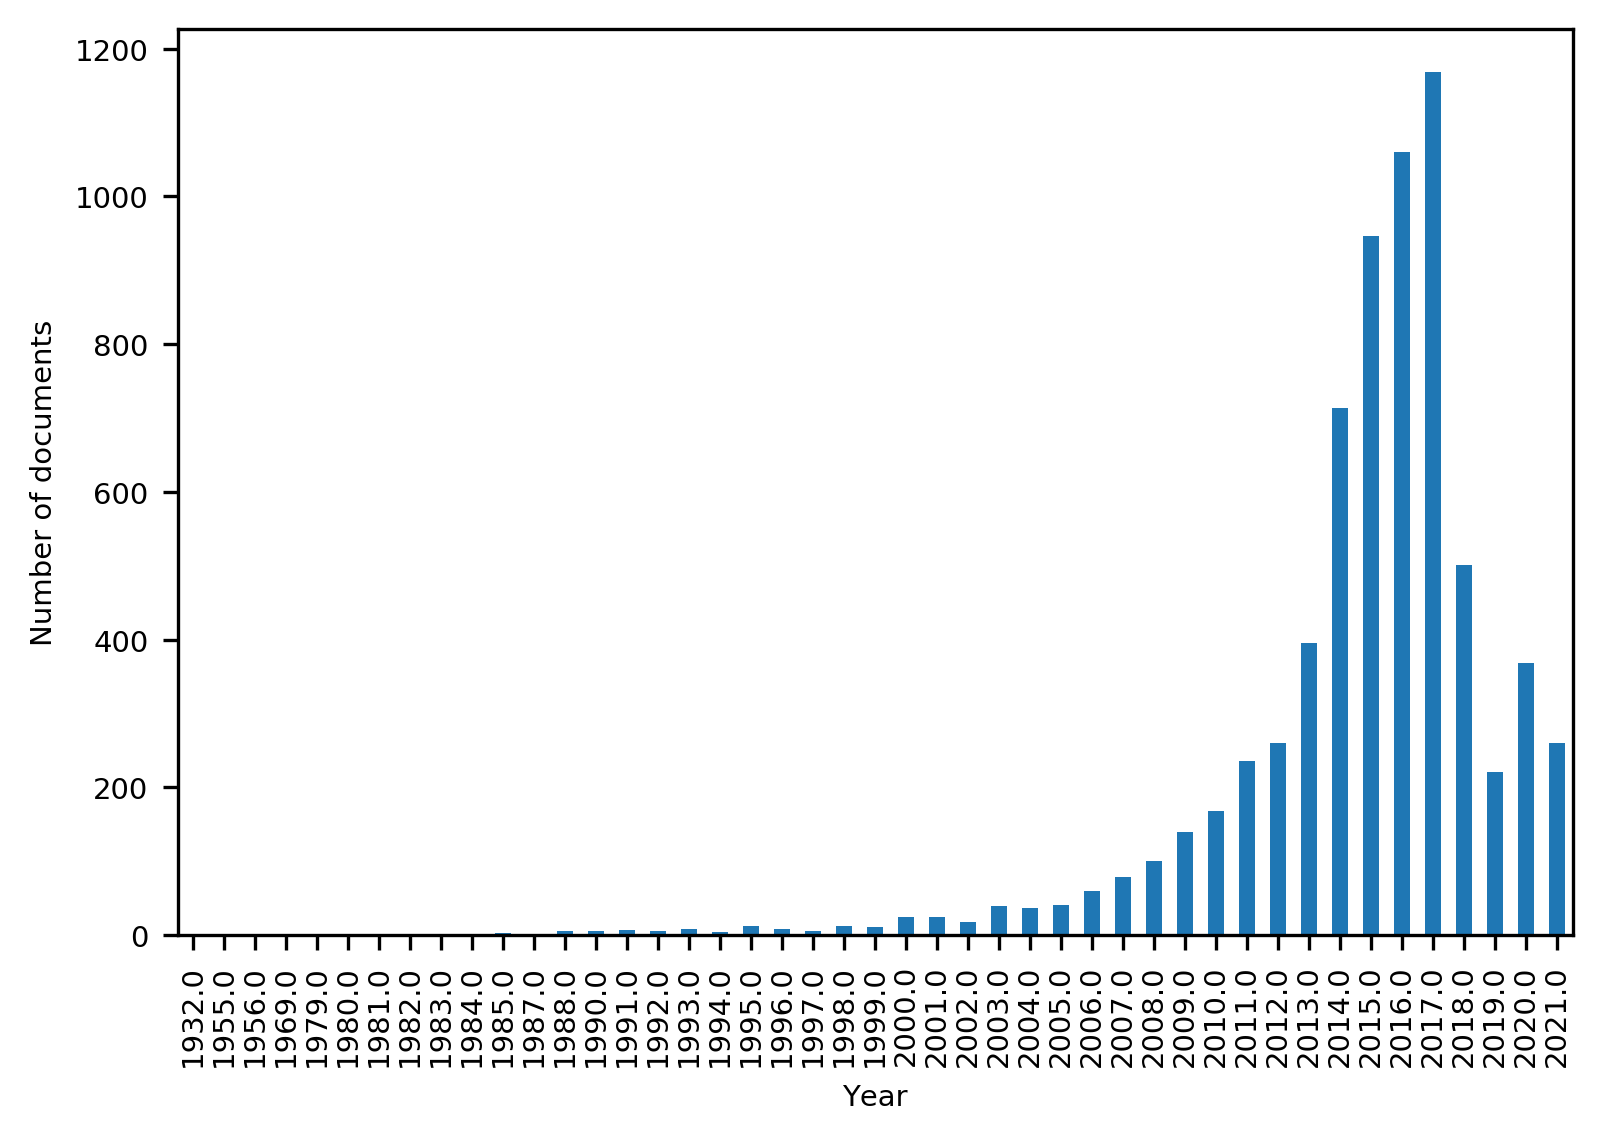

In [33]:
#Plot publications per year, just to investigate if indeed the IPCC authors kept it to >=2018
fig, ax = plt.subplots(dpi=300)
ipccDF.sort_values('YEAR', inplace=True)
#rdf['PY'].value_counts(sort=False).plot(ax=ax, kind='bar', xlabel='Year', ylabel='Number of documents')
ipccDF.groupby('YEAR').size().plot.bar( xlabel='Year', ylabel='Number of documents')
plt.show()